<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).


<a id='qn1'></a>
<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

<a id='top'></a>
Bookmarks
- [Question 1](#qn1)
    - [Analyzing the data](#qn1a)
    - [Data Cleaning](#qn1b)
    - [Data Processing](#qn1c)
    - [Identifying Features](#qn1d)
    - [Features Engineering](#qn1e)
    - [Prepare Training Data](#qn1f)
    - [Predictor and Target](#qn1g)
    - [Model Preparation](#qn1h)
    - [Regularization](#qn1i)
    - [Model Accuray](#qn1j)
    - [Features Elimination](#qn1k)
    - [Model Validation](#qn1l)
    - [Holdout Test](#qn1m)
    - [Conclusion](#qn1n)
    - [Model Optimization](#qn1o)    
- [Question 2](#qn2)
    - [Section 2.1](#qn2_1)
        - [Analyzing the data](#qn2a)
        - [Identifying Features](#qn2b)
        - [Model Preparation](#qn2c)
        - [Regularization](#qn2d)
        - [Model Accuray](#qn2e)
        - [Features Elimination](#qn2f)
        - [Model Validation](#qn2g)
        - [Holdout Test](#qn2h)
        - [Conclusion](#qn2i)
        - [Model Optimization](#qn2j)
    - [Section 2.2](#qn2_2)
    - [Section 2.3](#qn2_3)
    - [Section 2.4](#qn2_4)
- [Question 3](#qn3)
    - [Section 3.1](#qn3_1)
        - [Analyzing the data](#qn3a)
        - [Data Modelling](#qn3b)
        - [Conclusion](#qn3c)
    - [Section 3.2](#qn3_2)
    - [Section 3.3](#qn3_3)
- [Revised Data Description](#columns)

In [1]:
# Data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
sns.set_style('whitegrid')

# Make sure your charts appear in the notebook
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
# Stats/regressions packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn import metrics
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings('ignore') 
import re, os, sys, requests
import datetime as d_t

def display_df(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

def list_df(list1d, maxcols=3):
    if type(list1d)=='list':
        newlist = list1d
    else:
        newlist = list(list1d)
    n = len(newlist) % maxcols
    n = 0 if n==0 else (maxcols -n)
    if n > 0:
        newlist = newlist + [''] * n 
    df=pd.DataFrame( {' '+str(n) : [v for x,v in enumerate(newlist) if x % maxcols == n] for n in range(maxcols)} )
    return df

def overview(df, keycol=''): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nuniq = list(df.nunique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)

    dt = df.dtypes.to_frame()
    dtitle = 'Data type'
    dt.columns = [dtitle]
    print( dt.groupby(dtitle)[dtitle].count() )
    
    if keycol == '':
        cols = ['types', 'counts', 'distincts', 'nulls', 'uniques', 'skewness', 'kurtosis']
        df_overview = pd.concat([types, counts, distincts, nulls,  uniques, skewness, kurtosis], axis = 1)
    else:
        corr = df.corr()
        cols = ['types', 'counts', 'distincts', 'nulls', 'uniques', 'skewness', 'kurtosis', 'corr' ]
        df_overview = pd.concat([types, counts, distincts, nulls, uniques, skewness, kurtosis, corr[keycol]], axis = 1)
        
    df_overview.columns = cols
    df.columns.name="Cols"
    df.index.name=""
    print('\n')
    return df_overview

def dtype_by(df, datatype):
    return df.select_dtypes(include=datatype).T.index

<a id='qn1a'></a>
## Analyzing the data
[Back to top](#top)

In [3]:
# Load the data
fname = './housing.csv'
if os.path.isfile(fname):
    house = pd.read_csv(fname)
else:
    print(f"pls check if the file {fname} in the same folder")
    sys.exit(0)

In [4]:
display_df(house.head())

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [5]:
house.drop(['Id'], axis=1, inplace=True)

In [6]:
# checking the columns
list_df(house.columns,5)

0             1              2              3             4
0     MSSubClass      MSZoning    LotFrontage        LotArea        Street
1          Alley      LotShape    LandContour      Utilities     LotConfig
2      LandSlope  Neighborhood     Condition1     Condition2      BldgType
3     HouseStyle   OverallQual    OverallCond      YearBuilt  YearRemodAdd
4      RoofStyle      RoofMatl    Exterior1st    Exterior2nd    MasVnrType
5     MasVnrArea     ExterQual      ExterCond     Foundation      BsmtQual
6       BsmtCond  BsmtExposure   BsmtFinType1     BsmtFinSF1  BsmtFinType2
7     BsmtFinSF2     BsmtUnfSF    TotalBsmtSF        Heating     HeatingQC
8     CentralAir    Electrical       1stFlrSF       2ndFlrSF  LowQualFinSF
9      GrLivArea  BsmtFullBath   BsmtHalfBath       FullBath      HalfBath
10  BedroomAbvGr  KitchenAbvGr    KitchenQual   TotRmsAbvGrd    Functional
11    Fireplaces   FireplaceQu     GarageType    GarageYrBlt  GarageFinish
12    GarageCars    GarageArea     GarageQual     GarageCond    PavedDrive
13    WoodDeckSF   OpenPorchSF  EnclosedPorch      3SsnPorch   ScreenPorch
14      PoolArea        PoolQC          Fence    MiscFeature       MiscVal
15        MoSold        YrSold       SaleType  SaleCondition     SalePrice

In [7]:
# Quick glance of null columns
house.columns[house.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [8]:
# not so clean data
house_info = overview(house)

# prepare to fix the null values, lookup for the top counts
list_null = house_info[house_info.nulls>0].sort_values('nulls',ascending=False).nulls

house_info

Data shape: (1460, 80)
Data type
int64      34
float64     3
object     43
Name: Data type, dtype: int64




types  counts  distincts  nulls  \
1stFlrSF         int64    1460        753      0   
2ndFlrSF         int64    1460        417      0   
3SsnPorch        int64    1460         20      0   
Alley           object      91          3   1369   
BedroomAbvGr     int64    1460          8      0   
BldgType        object    1460          5      0   
BsmtCond        object    1423          5     37   
BsmtExposure    object    1422          5     38   
BsmtFinSF1       int64    1460        637      0   
BsmtFinSF2       int64    1460        144      0   
BsmtFinType1    object    1423          7     37   
BsmtFinType2    object    1422          7     38   
BsmtFullBath     int64    1460          4      0   
BsmtHalfBath     int64    1460          3      0   
BsmtQual        object    1423          5     37   
BsmtUnfSF        int64    1460        780      0   
CentralAir      object    1460          2      0   
Condition1      object    1460          9      0   
Condition2      object    1460          8      0   
Electrical      object    1459          6      1   
EnclosedPorch    int64    1460        120      0   
ExterCond       object    1460          5      0   
ExterQual       object    1460          4      0   
Exterior1st     object    1460         15      0   
Exterior2nd     object    1460         16      0   
Fence           object     281          5   1179   
FireplaceQu     object     770          6    690   
Fireplaces       int64    1460          4      0   
Foundation      object    1460          6      0   
FullBath         int64    1460          4      0   
...                ...     ...        ...    ...   
LotShape        object    1460          4      0   
LowQualFinSF     int64    1460         24      0   
MSSubClass       int64    1460         15      0   
MSZoning        object    1460          5      0   
MasVnrArea     float64    1452        328      8   
MasVnrType      object    1452          5      8   
MiscFeature     object      54          5   1406   
MiscVal          int64    1460         21      0   
MoSold           int64    1460         12      0   
Neighborhood    object    1460         25      0   
OpenPorchSF      int64    1460        202      0   
OverallCond      int64    1460          9      0   
OverallQual      int64    1460         10      0   
PavedDrive      object    1460          3      0   
PoolArea         int64    1460          8      0   
PoolQC          object       7          4   1453   
RoofMatl        object    1460          8      0   
RoofStyle       object    1460          6      0   
SaleCondition   object    1460          6      0   
SalePrice        int64    1460        663      0   
SaleType        object    1460          9      0   
ScreenPorch      int64    1460         76      0   
Street          object    1460          2      0   
TotRmsAbvGrd     int64    1460         12      0   
TotalBsmtSF      int64    1460        721      0   
Utilities       object    1460          2      0   
WoodDeckSF       int64    1460        274      0   
YearBuilt        int64    1460        112      0   
YearRemodAdd     int64    1460         61      0   
YrSold           int64    1460          5      0   

                                                         uniques   skewness  \
1stFlrSF       [[856, 1262, 920, 961, 1145, 796, 1694, 1107, ...   1.376757   
2ndFlrSF       [[854, 0, 866, 756, 1053, 566, 983, 752, 1142,...   0.813030   
3SsnPorch      [[0, 320, 407, 130, 180, 168, 140, 508, 238, 2...  10.304342   
Alley                                        [[nan, Grvl, Pave]]        NaN   
BedroomAbvGr                          [[3, 4, 1, 2, 0, 5, 6, 8]]   0.211790   
BldgType                 [[1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]]        NaN   
BsmtCond                                 [[TA, Gd, nan, Fa, Po]]        NaN   
BsmtExposure                             [[No, Gd, Mn, Av, nan]]        NaN   
BsmtFinSF1     [[706, 978, 486, 216, 655, 732, 1369, 859, 0, ...   1.685503   
Bs

In [9]:
list_df( dtype_by(house,'object') ,5)

0            1              2             3             4
0      MSZoning       Street          Alley      LotShape   LandContour
1     Utilities    LotConfig      LandSlope  Neighborhood    Condition1
2    Condition2     BldgType     HouseStyle     RoofStyle      RoofMatl
3   Exterior1st  Exterior2nd     MasVnrType     ExterQual     ExterCond
4    Foundation     BsmtQual       BsmtCond  BsmtExposure  BsmtFinType1
5  BsmtFinType2      Heating      HeatingQC    CentralAir    Electrical
6   KitchenQual   Functional    FireplaceQu    GarageType  GarageFinish
7    GarageQual   GarageCond     PavedDrive        PoolQC         Fence
8   MiscFeature     SaleType  SaleCondition

In [10]:
# highest 755,000
house['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [11]:
# 140,000 high frequency
house['SalePrice'].value_counts().head()

140000    20
135000    17
145000    14
155000    14
190000    13
Name: SalePrice, dtype: int64

In [12]:
house.head()

Cols  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
                                                                        
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   

Cols LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
                                        ...                             
0            Lvl    AllPub    Inside    ...            0    NaN   NaN   
1            Lvl    AllPub       FR2    ...            0    NaN   NaN   
2            Lvl    AllPub    Inside    ...            0    NaN   NaN   
3            Lvl    AllPub    Corner    ...            0    NaN   NaN   
4            Lvl    AllPub       FR2    ...            0    NaN   NaN   

Cols MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
                                                                             
0            NaN       0      2    2008        WD         Normal     208500  
1            NaN       0      5    2007        WD         Normal     181500  
2            NaN       0      9    2008        WD         Normal     223500  
3            NaN       0      2    2006        WD        Abnorml     140000  
4            NaN       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [13]:
# keeping a list of new columns
original_columns = house.columns

In [14]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

<a id='qn1b'></a>
## Data Cleaning
[Back to top](#top)

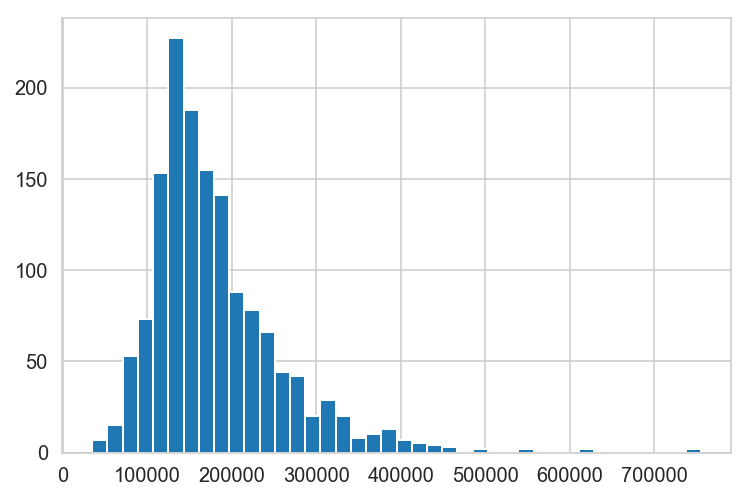

In [15]:
# SalePrice is not uniformly distributed and is skewed towards the left .
# Quick glance, take this variable to be our objective
house['SalePrice'].hist(bins = 40)

In [16]:
# Use log1p to remove the skewness 
house['SalePrice'] = np.log(house['SalePrice'])
status = house['SalePrice'].reset_index(drop=True)

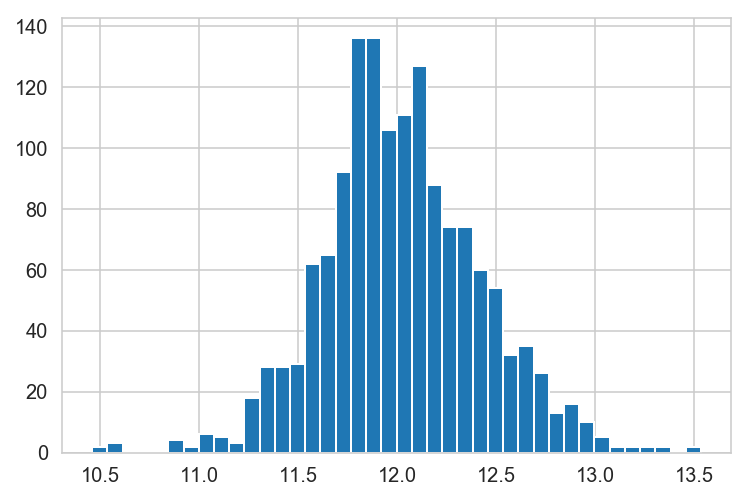

In [17]:
# The distribution of SalesPrice is more balanced 
# Quick glance, take this variable to be our objective
house['SalePrice'].hist(bins = 40)

In [18]:
# to fix these columns having missing values
list_null

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageFinish      81
GarageQual        81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Name: nulls, dtype: int64

In [19]:
#after running thru each columns via .unique and listing, basic fixing in action 
#LotFrontage
house['LotFrontage'] = house['LotFrontage'].fillna(0)
#Alley
house['Alley'] = house['Alley'].fillna('None')
#MasVnrType
house['MasVnrType'] = house['MasVnrType'].fillna('None')
#MasVnrArea
house['MasVnrArea'] = house['MasVnrArea'].fillna(0)
#BsmtQual
house['BsmtQual'] = house['BsmtQual'].fillna('None')
#BsmtCond
house['BsmtCond'] = house['BsmtCond'].fillna('None')
#BsmtExposure
house['BsmtExposure'] = house['BsmtExposure'].fillna('None')
#BsmtFinType1
house['BsmtFinType1'] = house['BsmtFinType1'].fillna('None')
#BsmtFinType2
house['BsmtFinType2'] = house['BsmtFinType2'].fillna('None')
#Electrical
house['Electrical'] = house['Electrical'].fillna('None')
#FireplaceQu
house['FireplaceQu'] = house['FireplaceQu'].fillna('None')
#GarageType
house['GarageType'] = house['GarageType'].fillna('None')
#GarageYrBlt
house['GarageYrBlt'] = house['GarageYrBlt'].fillna(0)
#GarageFinish
house['GarageFinish'] = house['GarageFinish'].fillna(0)
#GarageQual
house['GarageQual'] = house['GarageQual'].fillna('None')
#GarageCond
house['GarageCond'] = house['GarageCond'].fillna('None')
#PoolQC
house['PoolQC'] = house['PoolQC'].fillna('None')
#Fence
house['Fence'] = house['Fence'].fillna('None')
#MiscFeature
house['MiscFeature'] = house['MiscFeature'].fillna('None')

In [20]:
#no more missing values
house.isnull().sum().sum()

0

In [21]:
# Since those area related columns having definition with square feet , should be float

list_cols = ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', \
'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', \
'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', \
'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

print("changing data type from int64 to float for :")
for col in list_cols:
    print(col)
    house[col] = house[col].astype(float)    

changing data type from int64 to float for :
LotArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea


In [22]:
# list out those columns to check again    
house[ dtype_by(house,'int64') ].head()    

Cols  MSSubClass  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
                                                                      
0             60            7            5       2003          2003   
1             20            6            8       1976          1976   
2             60            7            5       2001          2002   
3             70            7            5       1915          1970   
4             60            8            5       2000          2000   

Cols  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
                                                                     
0                1             0         2         1             3   
1                0             1         2         0             3   
2                1             0         2         1             3   
3                1             0         1         0             3   
4                1             0         2         1             4   

Cols  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  MiscVal  MoSold  \
                                                                            
0                1             8           0           2        0       2   
1                1             6           1           2        0       5   
2                1             6           1           2        0       9   
3                1             7           1           3        0       2   
4                1             9           1           3        0      12   

Cols  YrSold  
              
0       2008  
1       2007  
2       2008  
3       2006  
4       2008

In [23]:
# Could these be float instead of integer ? Such as 'Area' related ?
list_df( dtype_by(house,'int64') ,5)

0             1            2           3             4
0    MSSubClass   OverallQual  OverallCond   YearBuilt  YearRemodAdd
1  BsmtFullBath  BsmtHalfBath     FullBath    HalfBath  BedroomAbvGr
2  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageCars       MiscVal
3        MoSold        YrSold

In [24]:
house[ dtype_by(house,'int64') ].head()

Cols  MSSubClass  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
                                                                      
0             60            7            5       2003          2003   
1             20            6            8       1976          1976   
2             60            7            5       2001          2002   
3             70            7            5       1915          1970   
4             60            8            5       2000          2000   

Cols  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
                                                                     
0                1             0         2         1             3   
1                0             1         2         0             3   
2                1             0         2         1             3   
3                1             0         1         0             3   
4                1             0         2         1             4   

Cols  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  MiscVal  MoSold  \
                                                                            
0                1             8           0           2        0       2   
1                1             6           1           2        0       5   
2                1             6           1           2        0       9   
3                1             7           1           3        0       2   
4                1             9           1           3        0      12   

Cols  YrSold  
              
0       2008  
1       2007  
2       2008  
3       2006  
4       2008

In [25]:
# Find float64 that can be in the continuous variables 
list_df( dtype_by(house,'float') ,5)

0            1            2           3             4
0    LotFrontage      LotArea   MasVnrArea  BsmtFinSF1    BsmtFinSF2
1      BsmtUnfSF  TotalBsmtSF     1stFlrSF    2ndFlrSF  LowQualFinSF
2      GrLivArea  GarageYrBlt   GarageArea  WoodDeckSF   OpenPorchSF
3  EnclosedPorch    3SsnPorch  ScreenPorch    PoolArea     SalePrice

In [26]:
# one of above should be integer for keeping years value.
house.GarageYrBlt = house.GarageYrBlt.apply(lambda x: int(x) )
house['GarageYrBlt'] = house['GarageYrBlt'].astype(int)

In [27]:
# checked , no need to convert anything to integer type
house[ dtype_by(house,'float') ].head()

Cols  LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
                                                                            
0            65.0   8450.0       196.0       706.0         0.0      150.0   
1            80.0   9600.0         0.0       978.0         0.0      284.0   
2            68.0  11250.0       162.0       486.0         0.0      434.0   
3            60.0   9550.0         0.0       216.0         0.0      540.0   
4            84.0  14260.0       350.0       655.0         0.0      490.0   

Cols  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  GarageArea  \
                                                                             
0           856.0     856.0     854.0           0.0     1710.0       548.0   
1          1262.0    1262.0       0.0           0.0     1262.0       460.0   
2           920.0     920.0     866.0           0.0     1786.0       608.0   
3           756.0     961.0     756.0           0.0     1717.0       642.0   
4          1145.0    1145.0    1053.0           0.0     2198.0       836.0   

Cols  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
                                                                       
0            0.0         61.0            0.0        0.0          0.0   
1          298.0          0.0            0.0        0.0          0.0   
2            0.0         42.0            0.0        0.0          0.0   
3            0.0         35.0          272.0        0.0          0.0   
4          192.0         84.0            0.0        0.0          0.0   

Cols  PoolArea  SalePrice  
                           
0          0.0  12.247694  
1          0.0  12.109011  
2          0.0  12.317167  
3          0.0  11.849398  
4          0.0  12.429216

In [28]:
# these will be out of training data
list_yrs_col=['YearBuilt', 'YrSold', 'YearRemodAdd', 'GarageYrBlt']
house[list_yrs_col][house.YrSold>=2010].head()

Cols  YearBuilt  YrSold  YearRemodAdd  GarageYrBlt
                                                  
16         1970    2010          1970         1970
24         1968    2010          2001         1968
26         1951    2010          2000         2005
27         2007    2010          2008         2008
33         1959    2010          1959         1959

In [29]:
house[list_yrs_col][house.YearBuilt>=2010]

Cols  YearBuilt  YrSold  YearRemodAdd  GarageYrBlt
                                                  
378        2010    2010          2010         2010

In [30]:
house[list_yrs_col][house.YearRemodAdd>=2010]

Cols  YearBuilt  YrSold  YearRemodAdd  GarageYrBlt
                                                  
157        2009    2010          2010         2009
378        2010    2010          2010         2010
819        2009    2010          2010         2010
855        1962    2010          2010         1962
898        2009    2010          2010         2009
987        2009    2010          2010         2010

In [31]:
house[list_yrs_col][house.GarageYrBlt>=2010]

Cols  YearBuilt  YrSold  YearRemodAdd  GarageYrBlt
                                                  
378        2010    2010          2010         2010
819        2009    2010          2010         2010
987        2009    2010          2010         2010

In [32]:
print(house.YearBuilt.unique())
print(house.YrSold.unique())
print(house.YearRemodAdd.unique())
print(house.GarageYrBlt.unique())

[2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]
[2008 2007 2006 2009 2010]
[2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]
[2003 1976 2001 1998 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1991 1970 1967 1

In [33]:
# make it number of years by now, later on will rename the columns
year_now = d_t.datetime.now().year
house['Yrs_Sold'] = house.eval(str(year_now) + ' - YrSold')
house['Yrs_Built'] = house.eval(str(year_now) + ' - YearBuilt')
house['Yrs_Remodel'] = house.eval(str(year_now) + ' - YearRemodAdd')
house['Yrs_GarageBlt'] = house.eval(str(year_now) + ' - GarageYrBlt')

In [34]:
list_yrs_col=['YearBuilt', 'YrSold', 'YearRemodAdd', 'GarageYrBlt', \
'Yrs_Built', 'Yrs_Remodel' , 'Yrs_GarageBlt' , 'Yrs_Sold']

house[list_yrs_col].head()

Cols  YearBuilt  YrSold  YearRemodAdd  GarageYrBlt  Yrs_Built  Yrs_Remodel  \
                                                                             
0          2003    2008          2003         2003         16           16   
1          1976    2007          1976         1976         43           43   
2          2001    2008          2002         2001         18           17   
3          1915    2006          1970         1998        104           49   
4          2000    2008          2000         2000         19           19   

Cols  Yrs_GarageBlt  Yrs_Sold  
                               
0                16        11  
1                43        12  
2                18        11  
3                21        13  
4                19        11

In [35]:
# rename columns to make it readable if possible

original_columns = house.columns

new_columns = \
["BuildingSalestype", "ZoningClassification", "StreetDistance", "LotSize", "Street", "Alley", \
"GeneralShape", "Flatness", "Utilities", "LotConfig", "Slope", "Neighborhood", "Condition1", \
"Condition2", "BuildingType", "HouseStyle", "OverallQuality", "RatingCondition", "YearBuilt", \
"YearRemodAdd", "RoofStyle", "RoofMaterial", "Exterior1st", "Exterior2nd", "MasonryType", "MasonryArea", \
"ExteriorQuality", "ExterCond", "Foundation", "BasementHeight", "BasementCondition", "BasementExposure",  \
"RatingBasement1", "BasementArea1", "RatingBasement2", "BasementArea2", "BasementUnfinished", "TotalBasementArea",  \
"Heating", "HeatingQC", "CentralAir", "Electrical", "FirstFloor", "SecondFloor", \
"LowQualFinSF", "AreaAboveGround", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", \
"KitchenAbvGr", "KitchenQual", "TotRmsAbvGrd", "Functional", "Fireplaces", "FireplaceQu", "GarageType", \
"GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond", "PavedDrive", \
"WoodDeckArea", "OpenPorchArea", "EnclosedPorchArea", "SeasonPorchArea", "ScreenPorch", "PoolArea", \
"PoolQC", "Fence", "MiscFeature", "MiscVal", "MoSold", "YrSold", "SaleType", "SaleCondition", "SalePrice", \
 "Yrs_Built", "Yrs_Sold", "Yrs_Remodel", "Yrs_GarageBlt"]

house.columns = new_columns

house.head()

BuildingSalestype ZoningClassification  StreetDistance  LotSize Street  \
                                                                            
0                 60                   RL            65.0   8450.0   Pave   
1                 20                   RL            80.0   9600.0   Pave   
2                 60                   RL            68.0  11250.0   Pave   
3                 70                   RL            60.0   9550.0   Pave   
4                 60                   RL            84.0  14260.0   Pave   

  Alley GeneralShape Flatness Utilities LotConfig      ...       MiscVal  \
                                                       ...                 
0  None          Reg      Lvl    AllPub    Inside      ...             0   
1  None          Reg      Lvl    AllPub       FR2      ...             0   
2  None          IR1      Lvl    AllPub    Inside      ...             0   
3  None          IR1      Lvl    AllPub    Corner      ...             0   
4  None          IR1      Lvl    AllPub       FR2      ...             0   

  MoSold YrSold SaleType SaleCondition  SalePrice  Yrs_Built  Yrs_Sold  \
                                                                         
0      2   2008       WD        Normal  12.247694         11        16   
1      5   2007       WD        Normal  12.109011         12        43   
2      9   2008       WD        Normal  12.317167         11        18   
3      2   2006       WD       Abnorml  11.849398         13       104   
4     12   2008       WD        Normal  12.429216         11        19   

   Yrs_Remodel  Yrs_GarageBlt  
                               
0           16             16  
1           43             43  
2           17             18  
3           49             21  
4           19             19  

[5 rows x 84 columns]

In [36]:
# backup of a list of old/new columns name
# reason , old columns with descriptions to help identifying fixed columns
# but we moved to new columns.
# with this , we just can looks at original columns with description (data_description.txt)
# Easily come out list of fixed columns(new name) with this dictionary  


#column_map = {new_columns[indx] : original_columns[indx] for indx,val in enumerate(original_columns) }
column_dict = {original_columns[indx] : new_columns[indx] for indx,val in enumerate(original_columns) }


In [37]:
# remove NA for remaining columns if I still missed 
house.dropna(inplace=True)

<a id='columns'></a>
##  Data_description Revised
[Back to top](#top)

In [38]:
# saved copy can be found as "new_data_desc.txt"

<a id='qn1c'></a>
## Data Processing
[Back to top](#top)

In [39]:
house.drop(house[house.ZoningClassification=='C (all)'].index, inplace=True)

In [40]:
house.shape

(1450, 84)

In [41]:
house.groupby('ZoningClassification')['ZoningClassification'].head(1)


0      RL
8      RM
47     FV
341    RH
Name: ZoningClassification, dtype: object

In [42]:
# now clean data, run again
house_info = overview(house , "SalePrice")
house_info

Data shape: (1450, 84)
Data type
int32       2
int64      20
float64    19
object     43
Name: Data type, dtype: int64




types  counts  distincts  nulls  \
Alley                  object    1450          3      0   
AreaAboveGround       float64    1450        858      0   
BasementArea1         float64    1450        636      0   
BasementArea2         float64    1450        144      0   
BasementCondition      object    1450          5      0   
BasementExposure       object    1450          5      0   
BasementHeight         object    1450          5      0   
BasementUnfinished    float64    1450        776      0   
BedroomAbvGr            int64    1450          8      0   
BsmtFullBath            int64    1450          4      0   
BsmtHalfBath            int64    1450          3      0   
BuildingSalestype       int64    1450         15      0   
BuildingType           object    1450          5      0   
CentralAir             object    1450          2      0   
Condition1             object    1450          9      0   
Condition2             object    1450          8      0   
Electrical             object    1450          6      0   
EnclosedPorchArea     float64    1450        118      0   
ExterCond              object    1450          5      0   
Exterior1st            object    1450         15      0   
Exterior2nd            object    1450         16      0   
ExteriorQuality        object    1450          4      0   
Fence                  object    1450          5      0   
FireplaceQu            object    1450          6      0   
Fireplaces              int64    1450          4      0   
FirstFloor            float64    1450        746      0   
Flatness               object    1450          4      0   
Foundation             object    1450          6      0   
FullBath                int64    1450          4      0   
Functional             object    1450          7      0   
...                       ...     ...        ...    ...   
OverallQuality          int64    1450         10      0   
PavedDrive             object    1450          3      0   
PoolArea              float64    1450          8      0   
PoolQC                 object    1450          4      0   
RatingBasement1        object    1450          7      0   
RatingBasement2        object    1450          7      0   
RatingCondition         int64    1450          9      0   
RoofMaterial           object    1450          8      0   
RoofStyle              object    1450          6      0   
SaleCondition          object    1450          6      0   
SalePrice             float64    1450        657      0   
SaleType               object    1450          9      0   
ScreenPorch           float64    1450         75      0   
SeasonPorchArea       float64    1450         20      0   
SecondFloor           float64    1450        413      0   
Slope                  object    1450          3      0   
Street                 object    1450          2      0   
StreetDistance        float64    1450        111      0   
TotRmsAbvGrd            int64    1450         12      0   
TotalBasementArea     float64    1450        719      0   
Utilities              object    1450          2      0   
WoodDeckArea          float64    1450        273      0   
YearBuilt               int64    1450        112      0   
YearRemodAdd            int64    1450         61      0   
YrSold                  int64    1450          5      0   
Yrs_Built               int64    1450          5      0   
Yrs_GarageBlt           int32    1450         97      0   
Yrs_Remodel             int64    1450         61      0   
Yrs_Sold                int64    1450        112      0   
ZoningClassification   object    1450          4      0   

                                                                uniques  \
Alley                                              [[None, Grvl, Pave]]   
AreaAboveGround       [[1710.0, 1262.0, 1786.0, 1717.0, 2198.0, 1362...   
BasementArea1         [[706.0, 978.0, 486.0, 216.0, 655.0, 732.0, 13...   
BasementArea2         [[0.0, 32.0, 668.0, 486.0, 93.0, 491.0, 506

<a id='qn1d'></a>
## Identifying Features
[Back to top](#top)

In [43]:
house.corr()

Cols                BuildingSalestype  StreetDistance   LotSize  \
Cols                                                              
BuildingSalestype            1.000000       -0.215415 -0.139725   
StreetDistance              -0.215415        1.000000  0.100273   
LotSize                     -0.139725        0.100273  1.000000   
OverallQuality               0.028891        0.183681  0.106457   
RatingCondition             -0.063504       -0.049826 -0.006074   
YearBuilt                    0.030056        0.041029  0.012958   
YearRemodAdd                 0.035989        0.081961  0.013475   
MasonryArea                  0.023617        0.106697  0.103071   
BasementArea1               -0.074762        0.079165  0.214794   
BasementArea2               -0.065991       -0.008637  0.111037   
BasementUnfinished          -0.139862        0.159562 -0.003035   
TotalBasementArea           -0.242933        0.239862  0.261034   
FirstFloor                  -0.256336        0.247524  0.299984   
SecondFloor                  0.304606        0.044531  0.051568   
LowQualFinSF                 0.049734        0.042045  0.006429   
AreaAboveGround              0.069245        0.223062  0.264359   
BsmtFullBath                 0.004554        0.012828  0.158232   
BsmtHalfBath                -0.011513       -0.027684  0.049121   
FullBath                     0.127755        0.123610  0.126324   
HalfBath                     0.178640       -0.011265  0.013691   
BedroomAbvGr                -0.030009        0.147850  0.120122   
KitchenAbvGr                 0.274877        0.035006 -0.017014   
TotRmsAbvGrd                 0.034751        0.223205  0.190489   
Fireplaces                  -0.049409        0.046450  0.271941   
GarageYrBlt                 -0.084350        0.023311  0.072148   
GarageCars                  -0.042209        0.166719  0.154124   
GarageArea                  -0.100045        0.201015  0.179251   
WoodDeckArea                -0.012677       -0.015127  0.171632   
OpenPorchArea               -0.002789        0.072127  0.087333   
EnclosedPorchArea           -0.011016        0.025923 -0.016954   
SeasonPorchArea             -0.044032        0.023823  0.020349   
ScreenPorch                 -0.030057        0.023599  0.043435   
PoolArea                     0.008308        0.114483  0.077652   
MiscVal                     -0.007172       -0.060943  0.037468   
MoSold                      -0.015808        0.017440  0.001500   
YrSold                      -0.019356       -0.013954 -0.013579   
SalePrice                   -0.081337        0.187609  0.261335   
Yrs_Built                    0.019356        0.013954  0.013579   
Yrs_Sold                    -0.030056       -0.041029 -0.012958   
Yrs_Remodel                 -0.035989       -0.081961 -0.013475   
Yrs_GarageBlt                0.084350       -0.023311 -0.072148   

Cols                OverallQuality  RatingCondition  YearBuilt  YearRemodAdd  \
Cols                                                                           
BuildingSalestype         0.028891        -0.063504   0.030056      0.035989   
StreetDistance            0.183681        -0.049826   0.041029      0.081961   
LotSize                   0.106457        -0.006074   0.012958      0.013475   
OverallQuality            1.000000        -0.107874   0.567392      0.544850   
RatingCondition          -0.107874         1.000000  -0.390446      0.067475   
YearBuilt                 0.567392        -0.390446   1.000000      0.590105   
YearRemodAdd              0.544850         0.067475   0.590105      1.000000   
MasonryArea               0.405799        -0.130376   0.308690      0.173008   
BasementArea1             0.235139        -0.053095   0.248222      0.123137   
BasementArea2            -0.062980         0.038818  -0.052726     -0.070913   
BasementUnfinished        0.313101        -0.135607   0.150407      0.182766   
TotalBasementArea         0.536622        -0.177514   0.390050      0.285987  

In [44]:
house_info = overview(house , "SalePrice")

# looking correlation value to SalesPrice
house_info.sort_values(by='corr',ascending=False)['corr'][:25]

Data shape: (1450, 84)
Data type
int32       2
int64      20
float64    19
object     43
Name: Data type, dtype: int64




SalePrice             1.000000
OverallQuality        0.816720
AreaAboveGround       0.704826
GarageCars            0.687597
GarageArea            0.663532
TotalBasementArea     0.614449
FirstFloor            0.596437
FullBath              0.591312
YearBuilt             0.582793
YearRemodAdd          0.559003
TotRmsAbvGrd          0.536118
Fireplaces            0.487557
MasonryArea           0.427965
BasementArea1         0.371376
OpenPorchArea         0.348537
GarageYrBlt           0.347238
WoodDeckArea          0.331199
SecondFloor           0.322372
HalfBath              0.311292
LotSize               0.261335
BsmtFullBath          0.234408
BasementUnfinished    0.226712
BedroomAbvGr          0.199471
StreetDistance        0.187609
ScreenPorch           0.120502
Name: corr, dtype: float64

<Figure size 1440x1080 with 0 Axes>

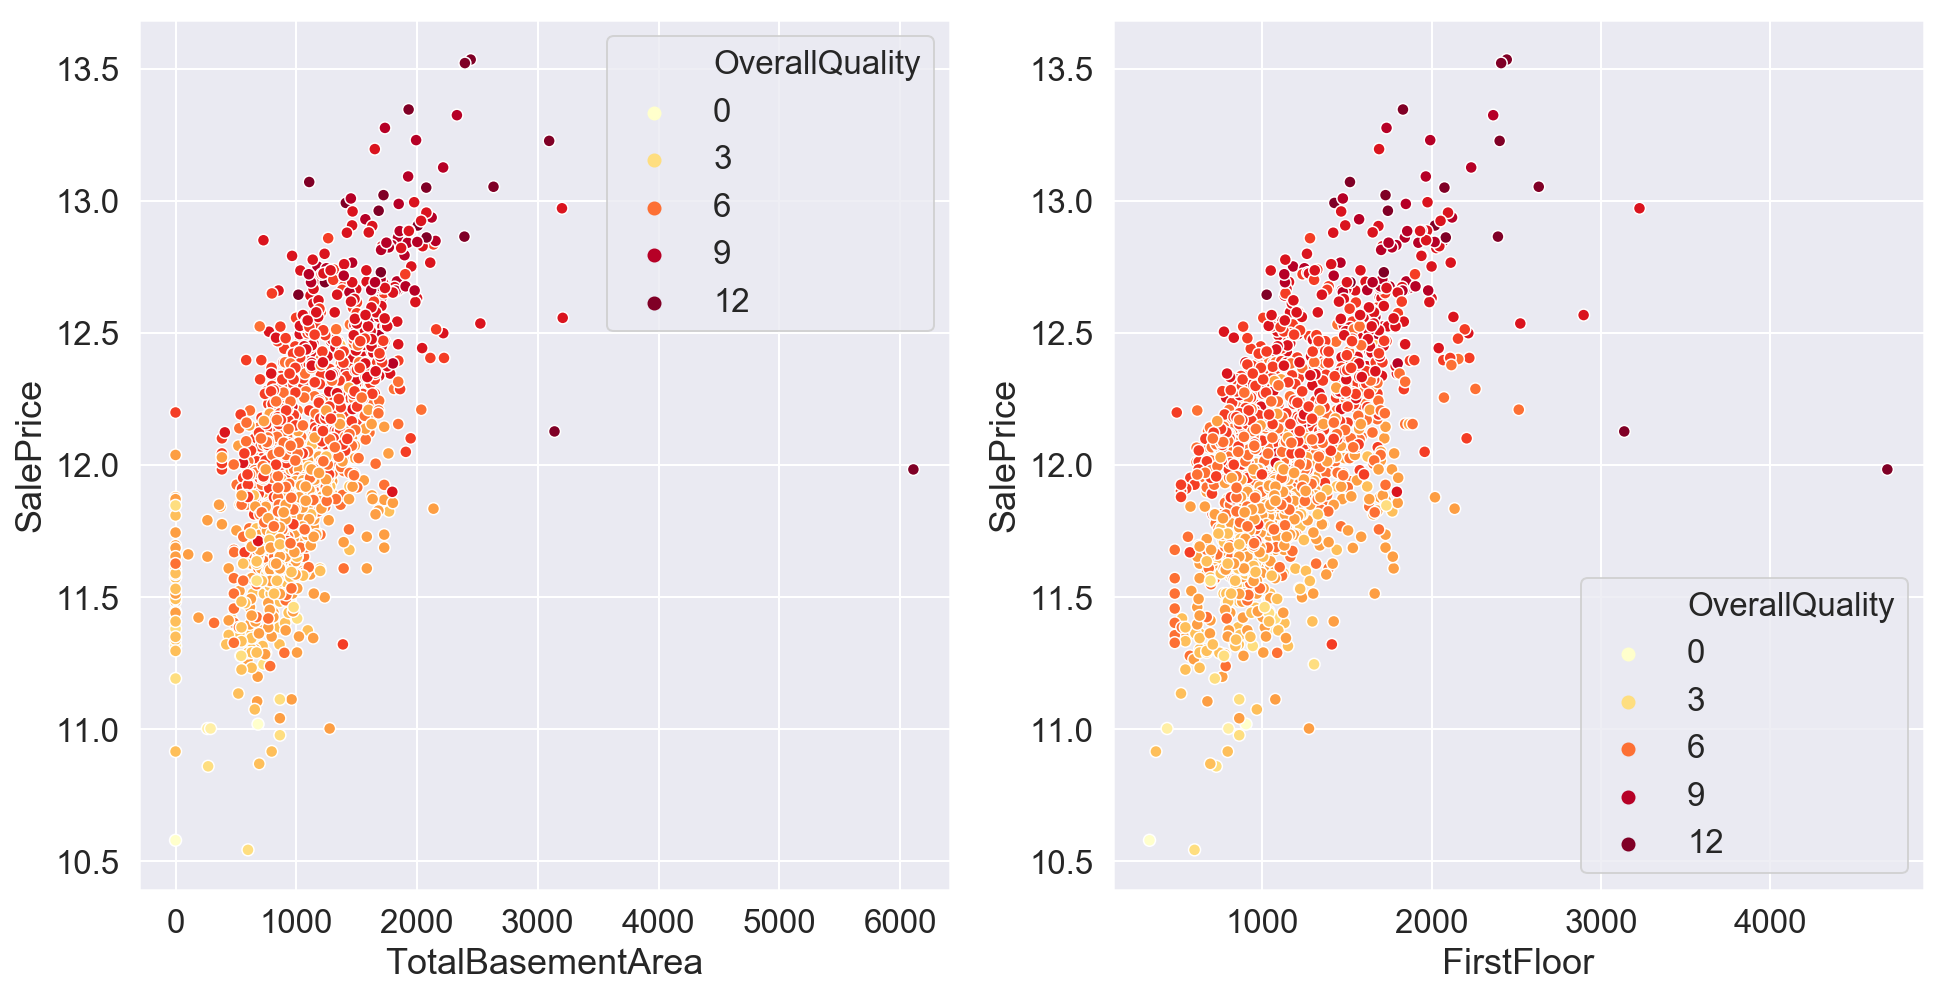

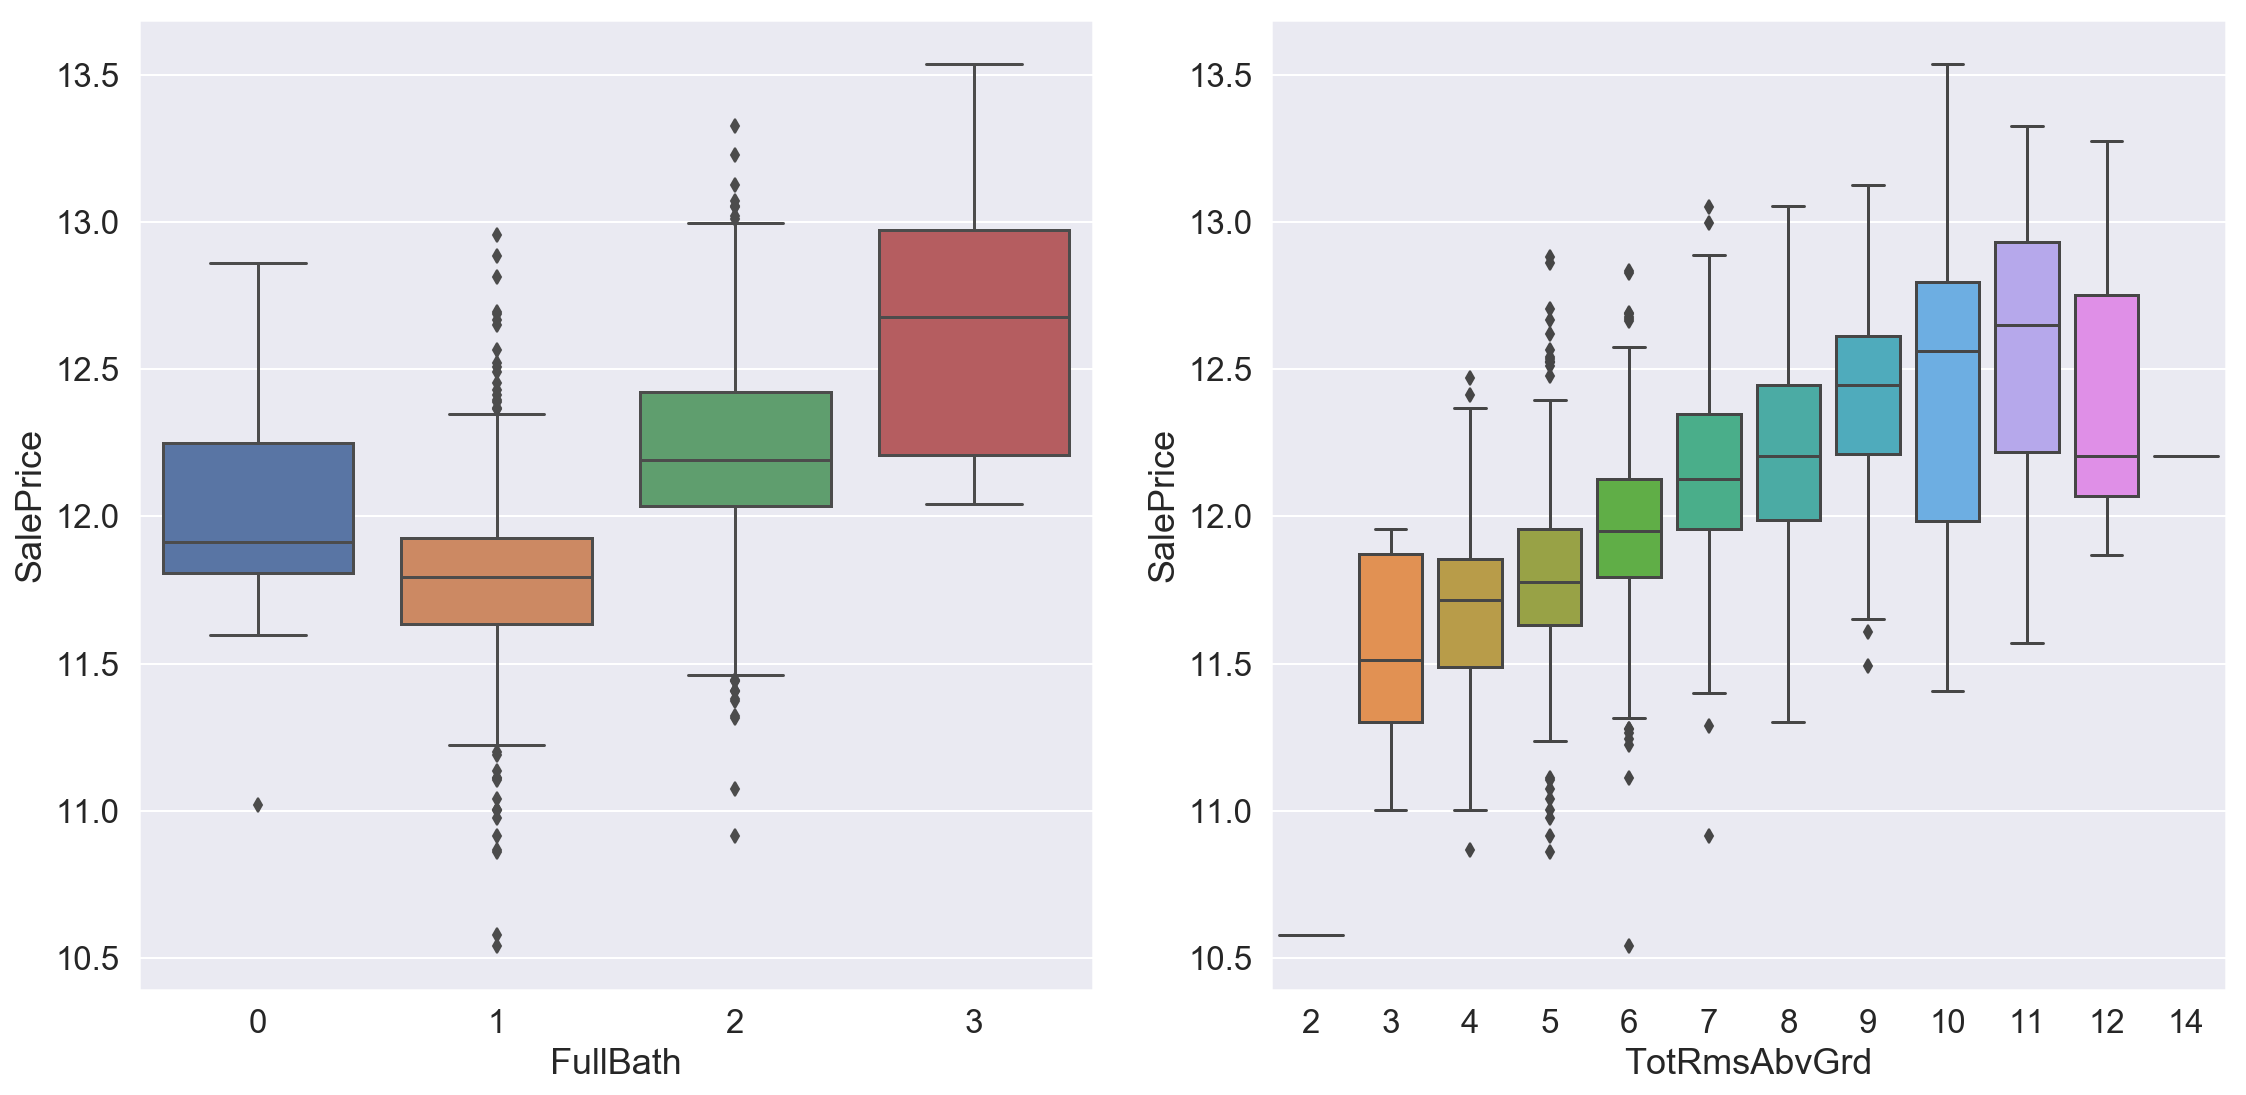

In [45]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig5 = plt.figure(figsize=(16, 8))
fig6 = fig5.add_subplot(121); 
sns.scatterplot(y = house.SalePrice , x = house.TotalBasementArea, hue=house.OverallQuality, palette= 'YlOrRd')
fig7 = fig5.add_subplot(122); 
sns.scatterplot(y = house.SalePrice, x = house['FirstFloor'], hue=house.OverallQuality, palette= 'YlOrRd')
fig8 = plt.figure(figsize=(16, 8))
fig9 = fig8.add_subplot(121); 
sns.boxplot(x='FullBath', y='SalePrice', data=house[['SalePrice', 'FullBath']])
fig10 = fig8.add_subplot(122); 
sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=house[['SalePrice', 'TotRmsAbvGrd']])
plt.tight_layout(); plt.show()


2305.1582524601554 11.44281302845143


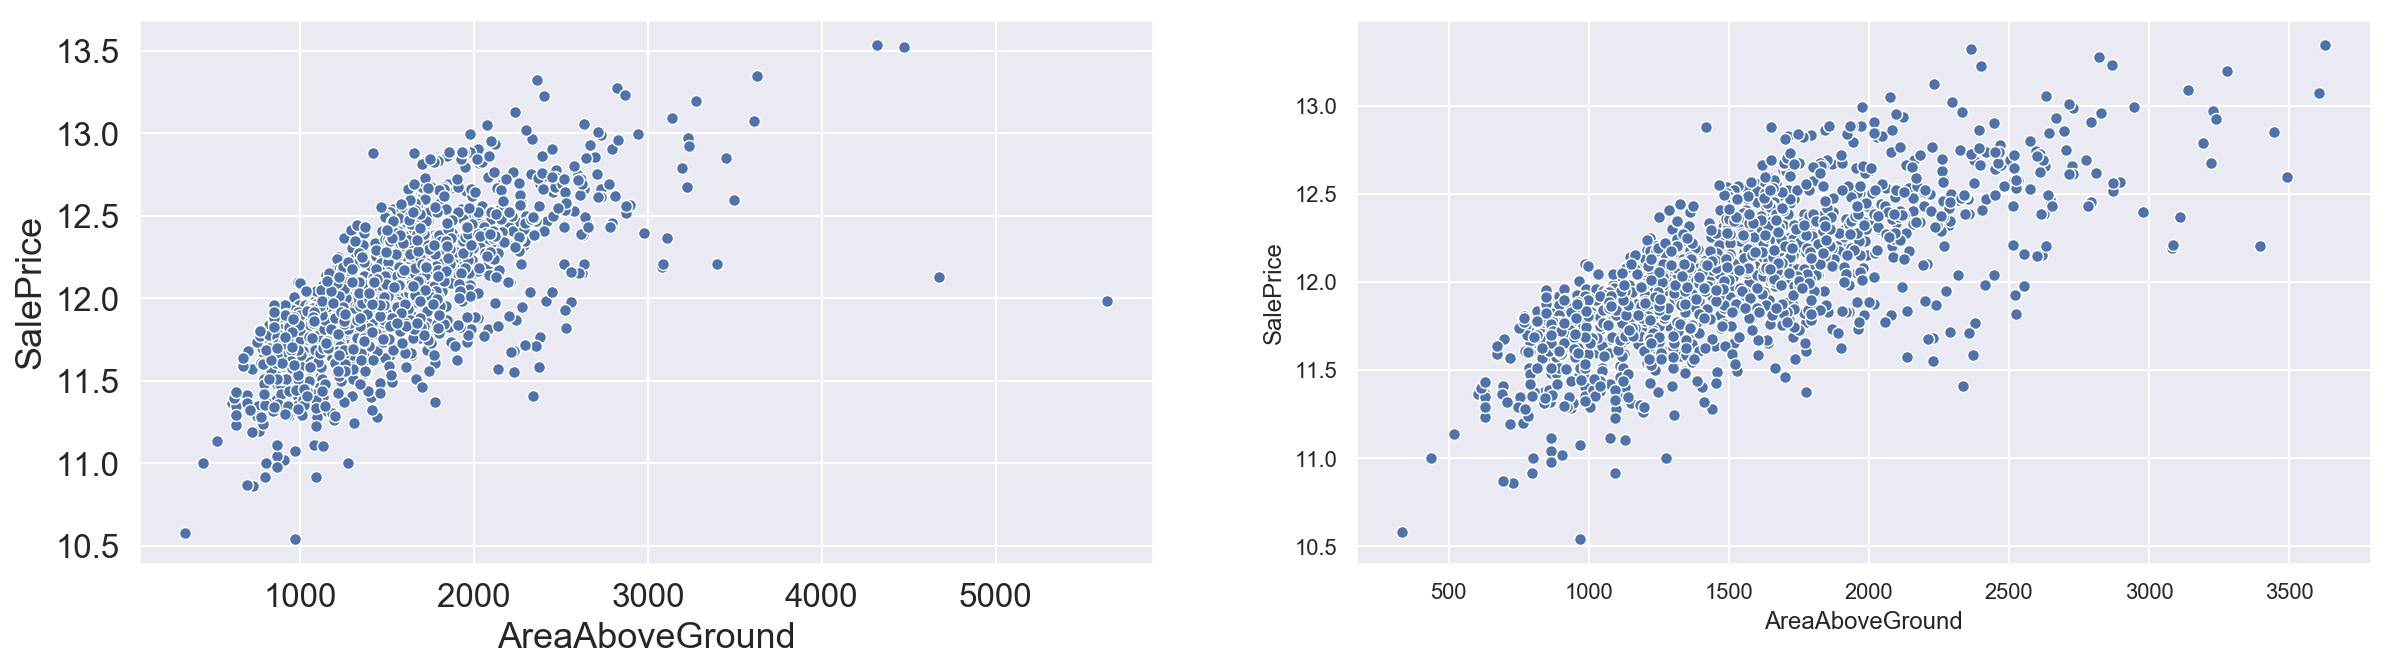

In [46]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
sns.set()
sns.scatterplot(x = house.AreaAboveGround, y = house.SalePrice, ax = ax)
plt.annotate('Outlier', xy=(4000, 10), xytext=(5642, 11.9), arrowprops=dict(facecolor='g', shrink=0.05)    )
plt.annotate('Outlier', xy=(4000, 10), xytext=(4676, 12.1), arrowprops=dict(facecolor='g', shrink=0.05)    )


# calculate outliers
outlier_high_x = np.mean(house.AreaAboveGround) + np.std(house.AreaAboveGround) * 1.5
outlier_low_y = np.mean(house.SalePrice) - np.std(house.SalePrice) * 1.5

print(outlier_high_x,outlier_low_y)
mask = (house.AreaAboveGround >= outlier_high_x) & (house.SalePrice <= outlier_low_y )

#Deleting outliers
idx=house.loc[mask].index[0]
house.drop( house.index[idx] )
mask = (house.AreaAboveGround >= outlier_high_x) & (house.SalePrice <= outlier_low_y )
idx=house.loc[mask].index[0]
house.drop( house.index[idx], inplace=True )
house.drop( house[(house.AreaAboveGround >=4000) & (house.SalePrice <=300000)].index, inplace=True)

#Check the graphic again
ax = fig.add_subplot(122)
sns.scatterplot(x = house.AreaAboveGround, y = house.SalePrice, ax = ax)
plt.show()

In [47]:
# list of fixed feature columns based on old column names due to the "data_description.txt"
fixed_columns_old = ["1stFlrSF","GrLivArea","BedroomAbvGr","BsmtFullBath", \
"BsmtHalfBath","Fireplaces","LandContour","FullBath","GarageArea","GarageCars",     \
"GarageType","LotShape","KitchenAbvGr","LotConfig","LandSlope","TotRmsAbvGrd",   \
"TotalBsmtSF","MSZoning", "HalfBath"]

In [48]:
# convert to new column name.
features = [ column_dict[col] for col in fixed_columns_old]
features

['FirstFloor',
 'AreaAboveGround',
 'BedroomAbvGr',
 'BsmtFullBath',
 'BsmtHalfBath',
 'Fireplaces',
 'Flatness',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageType',
 'GeneralShape',
 'KitchenAbvGr',
 'LotConfig',
 'Slope',
 'TotRmsAbvGrd',
 'TotalBasementArea',
 'ZoningClassification',
 'HalfBath']

<a id='qn1e'></a>
## Features Engineering
[Back to top](#top)

In [49]:
# Houses are often listed in terms of total number of bedrooms and total number of bathrooms. 
# Our data had total number of bedrooms, but lacked total number of bathrooms.
#
# Total number of bathrooms: Full Bath + Half Bath + Basement Full Bath + Basement Half Bath.

house['TotalBath'] = house.eval('FullBath + HalfBath + BsmtFullBath + BsmtHalfBath')
house.drop(['FullBath' , 'HalfBath' , 'BsmtFullBath' , 'BsmtHalfBath'], axis=1, inplace=True)

for col in ['FullBath' , 'HalfBath' , 'BsmtFullBath' , 'BsmtHalfBath']:
    features.remove(col)

features.append('TotalBath')

In [50]:
# Mapping ordinals features
house_info = overview(house , "SalePrice")

# dictionary of list for columns with unique values <= 10
cols_uniq = house_info[house_info.distincts<=50].uniques
print(cols_uniq)

Data shape: (1445, 81)
Data type
int32       2
int64      17
float64    19
object     43
Name: Data type, dtype: int64


Alley                                                [[None, Grvl, Pave]]
BasementCondition                                [[TA, Gd, None, Fa, Po]]
BasementExposure                                 [[No, Gd, Mn, Av, None]]
BasementHeight                                   [[Gd, TA, Ex, None, Fa]]
BedroomAbvGr                                   [[3, 4, 1, 2, 0, 5, 6, 8]]
BuildingSalestype       [[60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80...
BuildingType                      [[1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]]
CentralAir                                                       [[Y, N]]
Condition1              [[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn,...
Condition2              [[Norm, Artery, RRNn, Feedr, PosA, PosN, RRAn,...
Electrical                      [[SBrkr, FuseF, FuseA, FuseP, Mix, None]]
ExterCond                                          [[TA, Gd, Fa, 

In [51]:
def findcatcols(cols_uniq):
    cat_cols = []
    for c in cols_uniq.items():
        key=c[0]
        elem=c[1][0][0]   
        if len([c for c in str(elem) if c not in '0123456789.'])>0:
            cat_cols.append(key)
    print("# of columns : ",len(cat_cols))
    return cat_cols

# prepare a list of categorial columns, do a get_dummy
print('List of columns were categorial can be mapped to numeric category')
categorial_cols = findcatcols(cols_uniq)
list_df(categorial_cols, 4)

List of columns were categorial can be mapped to numeric category
# of columns :  43


0                  1                     2               3
0             Alley  BasementCondition      BasementExposure  BasementHeight
1      BuildingType         CentralAir            Condition1      Condition2
2        Electrical          ExterCond           Exterior1st     Exterior2nd
3   ExteriorQuality              Fence           FireplaceQu        Flatness
4        Foundation         Functional            GarageCond    GarageFinish
5        GarageQual         GarageType          GeneralShape         Heating
6         HeatingQC         HouseStyle           KitchenQual       LotConfig
7       MasonryType        MiscFeature          Neighborhood      PavedDrive
8            PoolQC    RatingBasement1       RatingBasement2    RoofMaterial
9         RoofStyle      SaleCondition              SaleType           Slope
10           Street          Utilities  ZoningClassification

In [52]:
dummydf = pd.get_dummies(house[categorial_cols], columns = categorial_cols)

In [53]:
# rename some columns that containing "." or "&"
for col in dummydf.columns:
    newcol = col.replace('.','').replace('&','')
    if col != newcol:
        print(col, newcol)
        dummydf.rename(columns={col:newcol}, inplace=True)
        
# does this affect the features columns ?

HouseStyle_1.5Fin HouseStyle_15Fin
HouseStyle_1.5Unf HouseStyle_15Unf
HouseStyle_2.5Fin HouseStyle_25Fin
HouseStyle_2.5Unf HouseStyle_25Unf
RoofMaterial_Tar&Grv RoofMaterial_TarGrv


In [54]:
# merge into housing data
house = pd.concat([house, dummydf], axis=1)

In [55]:
# Making sure features columns contains latest one

print("Updating features columns")
newlist = []
for col in categorial_cols:
    house.drop([col], axis=1, inplace=True)
    if col in features:
        print(f"'{col}' to be replaced with below in features")
        dummylist = [c for c in dummydf.columns if c.find(col)==0]
        print(dummylist)
        newlist = newlist + dummylist
        features.remove(col)

if newlist == []:
    print("nothing to update")
else:    
    features = features +  newlist        

Updating features columns
'Flatness' to be replaced with below in features
['Flatness_Bnk', 'Flatness_HLS', 'Flatness_Low', 'Flatness_Lvl']
'GarageType' to be replaced with below in features
['GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_None']
'GeneralShape' to be replaced with below in features
['GeneralShape_IR1', 'GeneralShape_IR2', 'GeneralShape_IR3', 'GeneralShape_Reg']
'LotConfig' to be replaced with below in features
['LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside']
'Slope' to be replaced with below in features
['Slope_Gtl', 'Slope_Mod', 'Slope_Sev']
'ZoningClassification' to be replaced with below in features
['ZoningClassification_FV', 'ZoningClassification_RH', 'ZoningClassification_RL', 'ZoningClassification_RM']


In [56]:
list_df(features)

0                        1                        2
0                FirstFloor          AreaAboveGround             BedroomAbvGr
1                Fireplaces               GarageArea               GarageCars
2              KitchenAbvGr             TotRmsAbvGrd        TotalBasementArea
3                 TotalBath             Flatness_Bnk             Flatness_HLS
4              Flatness_Low             Flatness_Lvl        GarageType_2Types
5         GarageType_Attchd       GarageType_Basment       GarageType_BuiltIn
6        GarageType_CarPort        GarageType_Detchd          GarageType_None
7          GeneralShape_IR1         GeneralShape_IR2         GeneralShape_IR3
8          GeneralShape_Reg         LotConfig_Corner        LotConfig_CulDSac
9             LotConfig_FR2            LotConfig_FR3         LotConfig_Inside
10                Slope_Gtl                Slope_Mod                Slope_Sev
11  ZoningClassification_FV  ZoningClassification_RH  ZoningClassification_RL
12  ZoningClassification_RM

In [57]:
house.head()

BuildingSalestype  StreetDistance  LotSize  OverallQuality  \
                                                                
0                 60            65.0   8450.0               7   
1                 20            80.0   9600.0               6   
2                 60            68.0  11250.0               7   
3                 70            60.0   9550.0               7   
4                 60            84.0  14260.0               8   

   RatingCondition  YearBuilt  YearRemodAdd  MasonryArea  BasementArea1  \
                                                                          
0                5       2003          2003        196.0          706.0   
1                8       1976          1976          0.0          978.0   
2                5       2001          2002        162.0          486.0   
3                5       1915          1970          0.0          216.0   
4                5       2000          2000        350.0          655.0   

   BasementArea2           ...             Slope_Mod  Slope_Sev  Street_Grvl  \
                           ...                                                 
0            0.0           ...                     0          0            0   
1            0.0           ...                     0          0            0   
2            0.0           ...                     0          0            0   
3            0.0           ...                     0          0            0   
4            0.0           ...                     0          0            0   

   Street_Pave  Utilities_AllPub  Utilities_NoSeWa  ZoningClassification_FV  \
                                                                              
0            1                 1                 0                        0   
1            1                 1                 0                        0   
2            1                 1                 0                        0   
3            1                 1                 0                        0   
4            1                 1                 0                        0   

   ZoningClassification_RH  ZoningClassification_RL  ZoningClassification_RM  
                                                                              
0                        0                        1                        0  
1                        0                        1                        0  
2                        0                        1                        0  
3                        0                        1                        0  
4                        0                        1                        0  

[5 rows x 303 columns]

<a id='qn1f'></a>
## Prepare Training Data
[Back to top](#top)

In [58]:
trainmask = (house.YearBuilt < 2010) & (house.Yrs_Remodel < 2010) & \
    (house.Yrs_GarageBlt < 2010) & (house.Yrs_Sold < 2010)

In [59]:
list_yrs_col=['YearBuilt', 'YrSold', 'YearRemodAdd', 'GarageYrBlt', \
'Yrs_Built', 'Yrs_Remodel' , 'Yrs_GarageBlt' , 'Yrs_Sold']

In [60]:
house[list_yrs_col][trainmask].count()

YearBuilt        1365
YrSold           1365
YearRemodAdd     1365
GarageYrBlt      1365
Yrs_Built        1365
Yrs_Remodel      1365
Yrs_GarageBlt    1365
Yrs_Sold         1365
dtype: int64

In [61]:
house_train = house[trainmask]
house_holdout = house[~trainmask]

In [62]:
house.shape, house_train.shape, house_holdout.shape

((1445, 303), (1365, 303), (80, 303))

In [63]:
house_train[list_yrs_col].head()

YearBuilt  YrSold  YearRemodAdd  GarageYrBlt  Yrs_Built  Yrs_Remodel  \
                                                                          
0       2003    2008          2003         2003         11           16   
1       1976    2007          1976         1976         12           43   
2       2001    2008          2002         2001         11           17   
3       1915    2006          1970         1998         13           49   
4       2000    2008          2000         2000         11           19   

   Yrs_GarageBlt  Yrs_Sold  
                            
0             16        16  
1             43        43  
2             18        18  
3             21       104  
4             19        19

In [64]:
house_train[features].head()

FirstFloor  AreaAboveGround  BedroomAbvGr  Fireplaces  GarageArea  \
                                                                       
0       856.0           1710.0             3           0       548.0   
1      1262.0           1262.0             3           1       460.0   
2       920.0           1786.0             3           1       608.0   
3       961.0           1717.0             3           1       642.0   
4      1145.0           2198.0             4           1       836.0   

   GarageCars  KitchenAbvGr  TotRmsAbvGrd  TotalBasementArea  TotalBath  \
                                                                          
0           2             1             8              856.0          4   
1           2             1             6             1262.0          3   
2           2             1             6              920.0          4   
3           3             1             7              756.0          2   
4           3             1             9             1145.0          4   

            ...             LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  \
            ...                                                              
0           ...                         0              0                 1   
1           ...                         1              0                 0   
2           ...                         0              0                 1   
3           ...                         0              0                 0   
4           ...                         1              0                 0   

   Slope_Gtl  Slope_Mod  Slope_Sev  ZoningClassification_FV  \
                                                              
0          1          0          0                        0   
1          1          0          0                        0   
2          1          0          0                        0   
3          1          0          0                        0   
4          1          0          0                        0   

   ZoningClassification_RH  ZoningClassification_RL  ZoningClassification_RM  
                                                                              
0                        0                        1                        0  
1                        0                        1                        0  
2                        0                        1                        0  
3                        0                        1                        0  
4                        0                        1                        0  

[5 rows x 37 columns]

<a id='qn1g'></a>
## Predictor and Target
[Back to top](#top)

In [65]:
target = 'SalePrice'
house_info = overview(house_train , target)
list_cols = features
X = house_train[list_cols]
y = house_train[target]

Data shape: (1365, 303)
Data type
uint8      265
int32        2
int64       17
float64     19
Name: Data type, dtype: int64




In [66]:
# looking at correlation value to SalesPrice
house_info.T[features].T.sort_values(by='corr',ascending=False)['corr'][:25]

Cols
AreaAboveGround              0.726671
GarageCars                   0.660927
TotalBath                    0.652657
TotalBasementArea            0.633318
GarageArea                   0.632402
FirstFloor                   0.602408
TotRmsAbvGrd                 0.540415
Fireplaces                   0.471095
GarageType_Attchd            0.354047
ZoningClassification_RL      0.267326
GeneralShape_IR1             0.245618
GarageType_BuiltIn           0.226008
BedroomAbvGr                 0.187969
LotConfig_CulDSac            0.144439
Flatness_HLS                 0.126797
GeneralShape_IR2             0.124172
ZoningClassification_FV      0.114297
Flatness_Low                0.0825282
Slope_Mod                   0.0700837
Slope_Sev                    0.042174
GeneralShape_IR3            0.0380078
LotConfig_FR3               0.0202359
LotConfig_FR2              0.00352681
LotConfig_Corner           -0.0208096
GarageType_Basment         -0.0271424
Name: corr, dtype: object

In [67]:
display_df(house_train[:10])

Cols  BuildingSalestype  StreetDistance  LotSize  OverallQuality  \
                                                                   
0                    60            65.0   8450.0               7   
1                    20            80.0   9600.0               6   
2                    60            68.0  11250.0               7   
3                    70            60.0   9550.0               7   
4                    60            84.0  14260.0               8   
5                    50            85.0  14115.0               5   
6                    20            75.0  10084.0               8   
7                    60             0.0  10382.0               7   
8                    50            51.0   6120.0               7   
9                   190            50.0   7420.0               5   

Cols  RatingCondition  YearBuilt  YearRemodAdd  MasonryArea  BasementArea1  \
                                                                             
0                   5       2003          2003        196.0          706.0   
1                   8       1976          1976          0.0          978.0   
2                   5       2001          2002        162.0          486.0   
3                   5       1915          1970          0.0          216.0   
4                   5       2000          2000        350.0          655.0   
5                   5       1993          1995          0.0          732.0   
6                   5       2004          2005        186.0         1369.0   
7                   6       1973          1973        240.0          859.0   
8                   5       1931          1950          0.0            0.0   
9                   6       1939          1950          0.0          851.0   

Cols  BasementArea2  BasementUnfinished  TotalBasementArea  FirstFloor  \
                                                                         
0               0.0               150.0              856.0       856.0   
1               0.0               284.0             1262.0      1262.0   
2               0.0               434.0              920.0       920.0   
3               0.0               540.0              756.0       961.0   
4               0.0               490.0             1145.0      1145.0   
5               0.0                64.0              796.0       796.0   
6               0.0               317.0             1686.0      1694.0   
7              32.0               216.0             1107.0      1107.0   
8               0.0               952.0              952.0      1022.0   
9               0.0               140.0              991.0      1077.0   

Cols  SecondFloor  LowQualFinSF  AreaAboveGround  BedroomAbvGr  KitchenAbvGr  \
                                                                               
0           854.0           0.0           1710.0             3             1   
1             0.0           0.0           1262.0             3             1   
2           866.0           0.0           1786.0             3             1   
3           756.0           0.0           1717.0             3             1   
4          1053.0           0.0           2198.0             4             1   
5           566.0           0.0           1362.0             1             1   
6             0.0           0.0           1694.0             3             1   
7           983.0           0.0           2090.0             3             1   
8           752.0           0.0           1774.0             2             2   
9             0.0           0.0           1077.0             2             2   

Cols  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
                                                                      
0                8           0         2003           2       548.0   
1                6           1         1976           2       460.0   
2                6           1         2001           2       608.0   
3                7           1         19

In [68]:
status = house_train.reset_index(drop=True)

<a id='qn1h'></a>
## Model Preparation
[Back to top](#top)

In [69]:
X = house_train[list_cols]
y = house_train[target]

In [70]:
# split into training and testing sets
hTrain, hTest, yTrain, yTest = train_test_split(house_train, y, test_size = 0.2, random_state = 1)
xTrain = hTrain[list_cols]
xTest = hTest[list_cols]
print(hTrain.shape, hTest.shape)

(1092, 303) (273, 303)


In [71]:
print(X.shape, xTrain.shape, xTest.shape, house_train.shape)

(1365, 37) (1092, 37) (273, 37) (1365, 303)


In [72]:
# standardize them
std = StandardScaler()
X_train_std = std.fit_transform(xTrain)
X_test_std = std.transform(xTest)

print(X_train_std.shape, X_test_std.shape)

(1092, 37) (273, 37)


<a id='qn1i'></a>
## Regularization
[Back to top](#top)

In [73]:
# loop through different penalty score (alpha) and obtain the estimated coefficient (weights)
# define alpha values range
alphas = 10 ** np.arange(1, 5)

# stores the weights of each feature
ridge_weight = []
for alpha in alphas:    
    ridge = Ridge(alpha = alpha, fit_intercept = True)
    ridge.fit(X_train_std, yTrain)
    ridge_weight.append(ridge.coef_)
    
ridge_weight    

[array([ 0.00286684,  0.12815848, -0.03891919,  0.0178054 ,  0.03460735,
         0.05084719, -0.04773701,  0.03225436,  0.08850612,  0.04865617,
        -0.00477367,  0.01731529,  0.00178669, -0.0083524 , -0.01479736,
         0.01398156,  0.00131926,  0.01880346, -0.02266724, -0.01971184,
         0.        ,  0.00497178,  0.00403444, -0.00456502, -0.00549843,
        -0.00344728,  0.00786427, -0.00550514,  0.00157427,  0.00057414,
        -0.00079512,  0.00123274, -0.00077901,  0.02910745, -0.00267893,
         0.00493133, -0.0239082 ]),
 array([ 2.00836293e-02,  1.01619387e-01, -2.93965475e-02,  2.13304223e-02,
         3.88946402e-02,  4.92137268e-02, -4.62697695e-02,  3.73734688e-02,
         7.37327612e-02,  5.32990843e-02, -4.95491360e-03,  1.69608810e-02,
         1.40514077e-03, -7.81727327e-03, -1.43556665e-02,  1.42397488e-02,
        -7.89022197e-05,  2.02414418e-02, -2.09248874e-02, -2.07251078e-02,
         0.00000000e+00,  5.37917985e-03,  4.94498807e-03, -3.96708476e-0

In [74]:
# loop through different penalty score (alpha) and obtain the estimated coefficient (weights)
def weight_versus_alpha_plot(Regressor, alphas, Xt, yt):
    weight = []
    for alpha in alphas:    
        ridge = Regressor(alpha = alpha, fit_intercept = True)
        ridge.fit(Xt, yTrain)
        weight.append(ridge.coef_)
        
    plt.rcParams['figure.figsize'] = 8, 6 
    plt.rcParams['font.size'] = 8
    fig = plt.figure(figsize = (22, 14))
    
    # ensure that the weight is an array
    wt = np.array(weight)
    for col in range(wt.shape[1]):
        plt.plot(alphas, wt[:, col], label = features[col])

    plt.axhline(0, color = 'black', linestyle = '--', linewidth = 3)
    
    # manually specify the coordinate of the legend
    plt.legend(bbox_to_anchor = (0.5, -0.1), loc=9, ncol=8)
    plt.title('Coefficient Weight as Alpha Grows')
    plt.ylabel('Coefficient weight')
    plt.xlabel('alpha')
    return weight

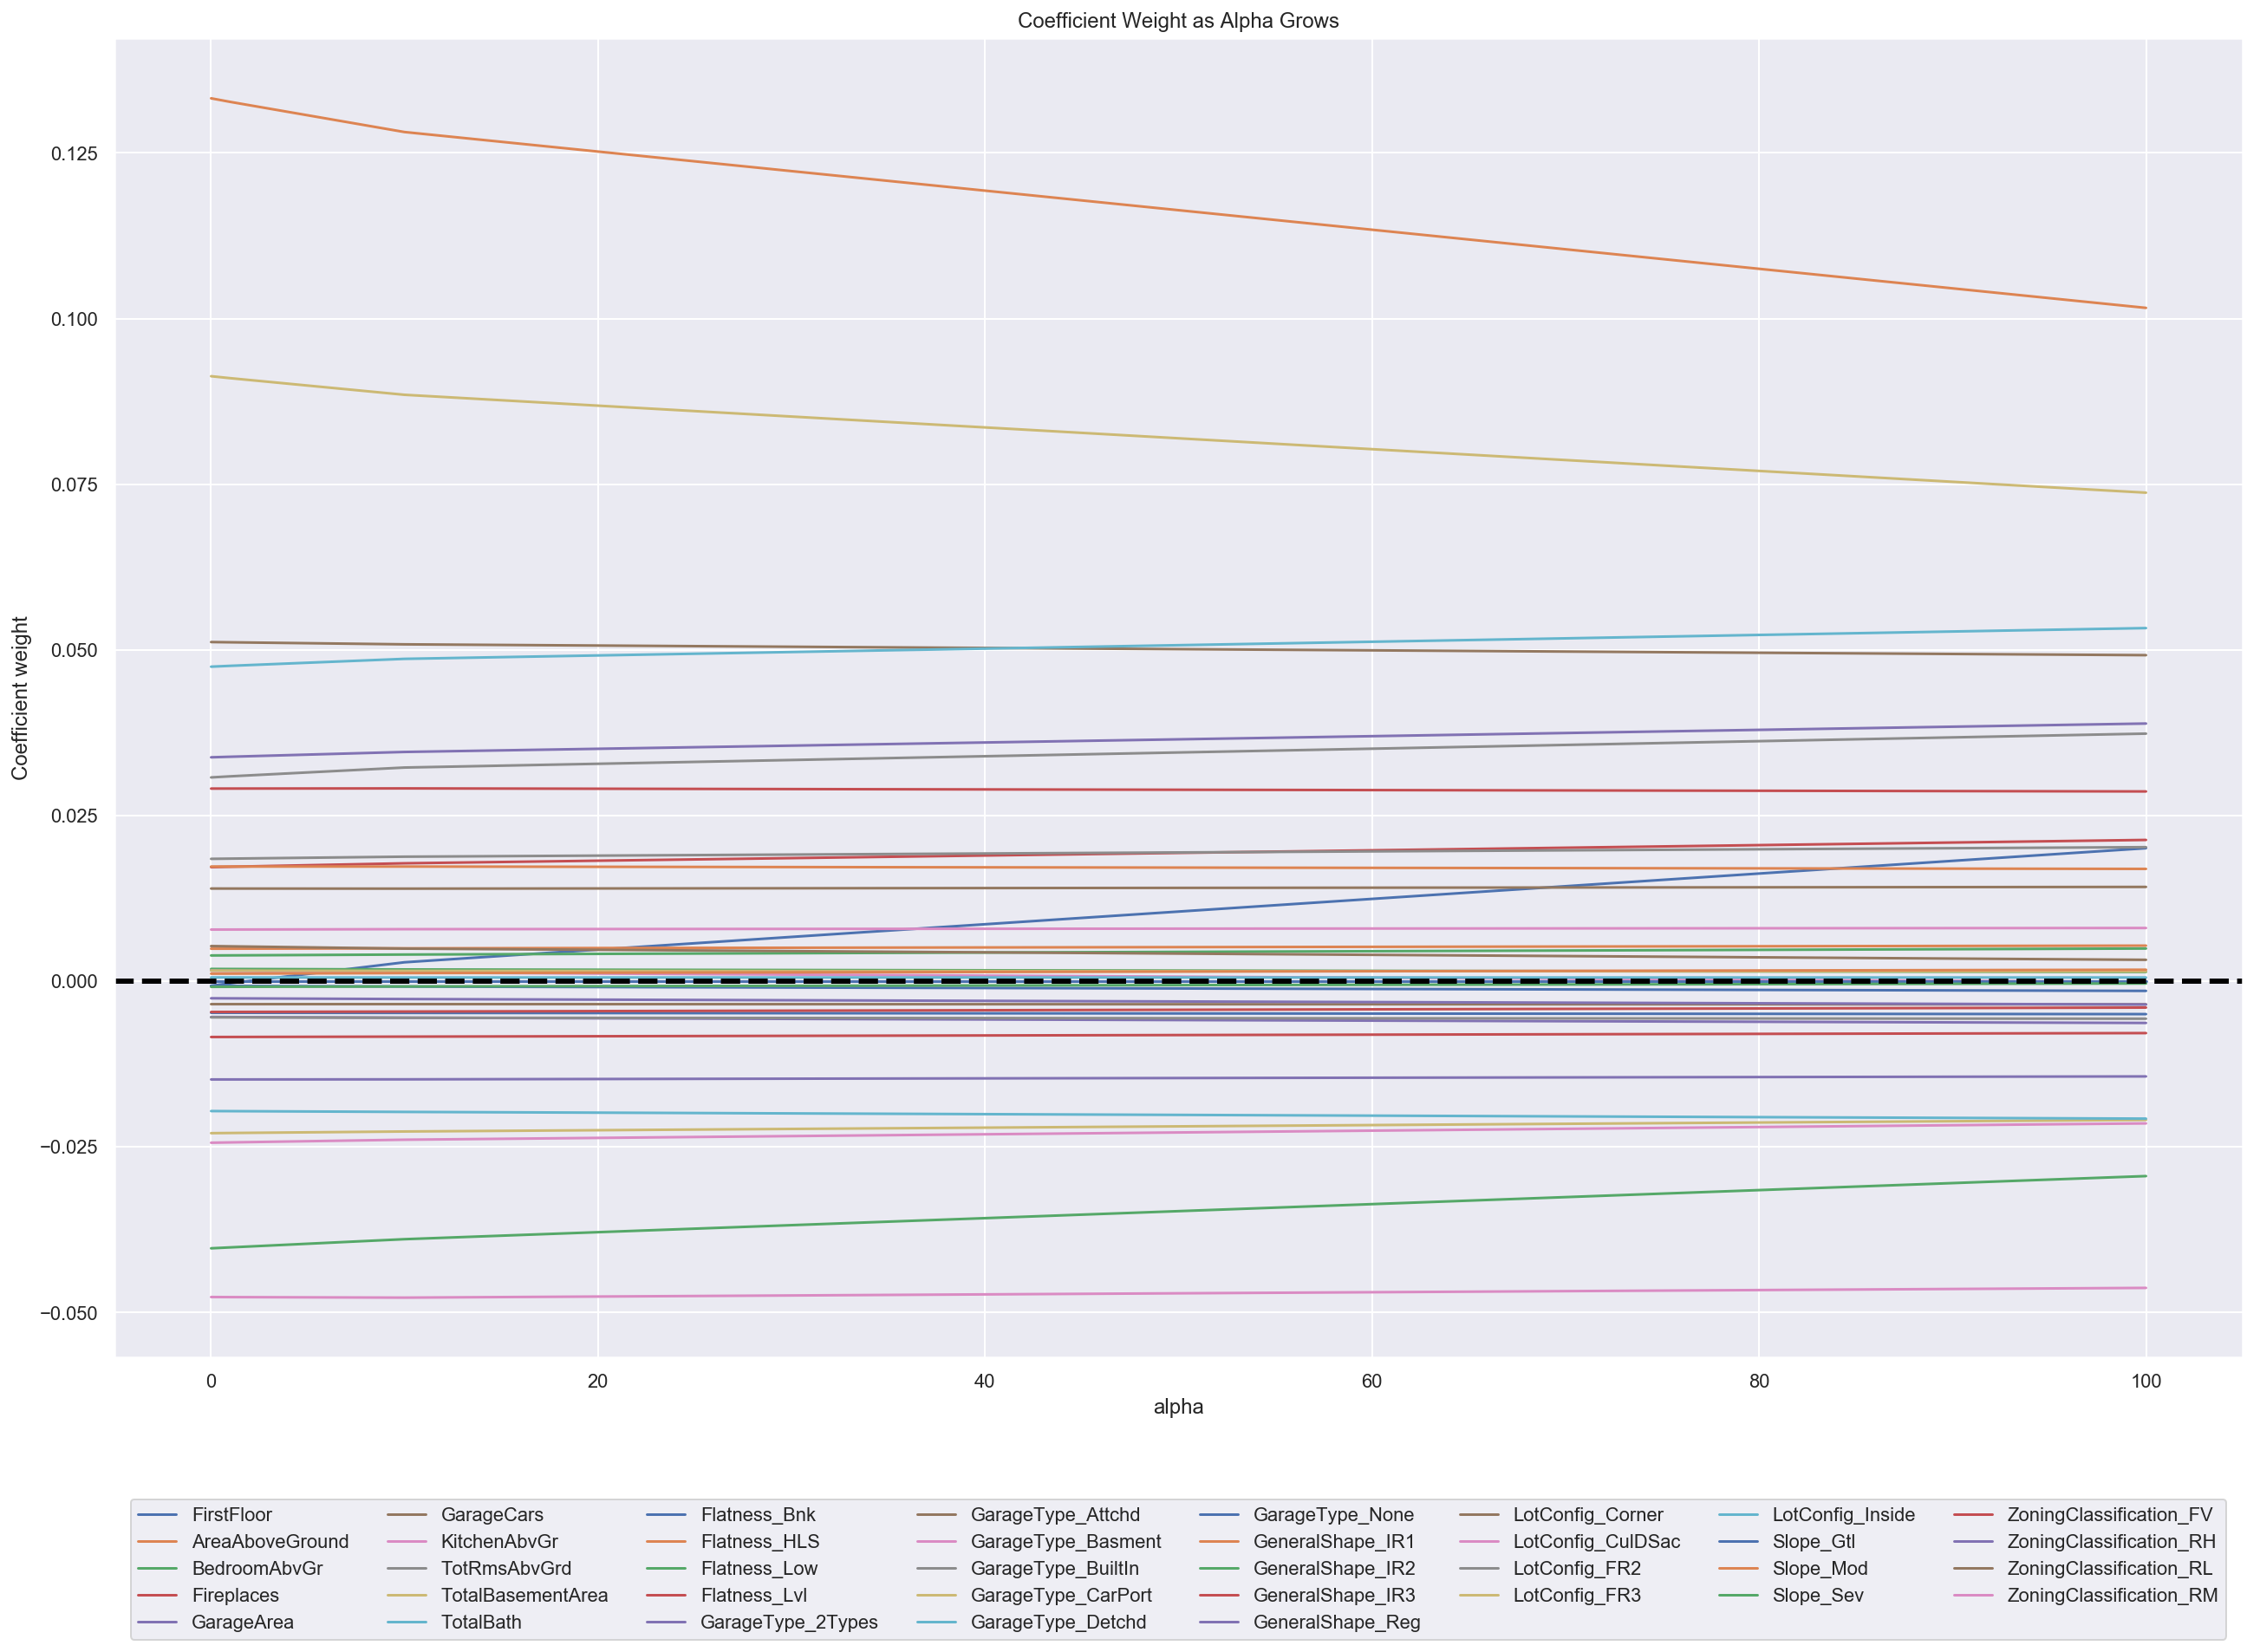

In [75]:
# does the same thing for Ridge mthd
# Regressor = Ridge()
alphas = 10. ** np.arange(-2, 3)
ridge_weight = weight_versus_alpha_plot(Ridge, alphas, X_train_std, yTrain)

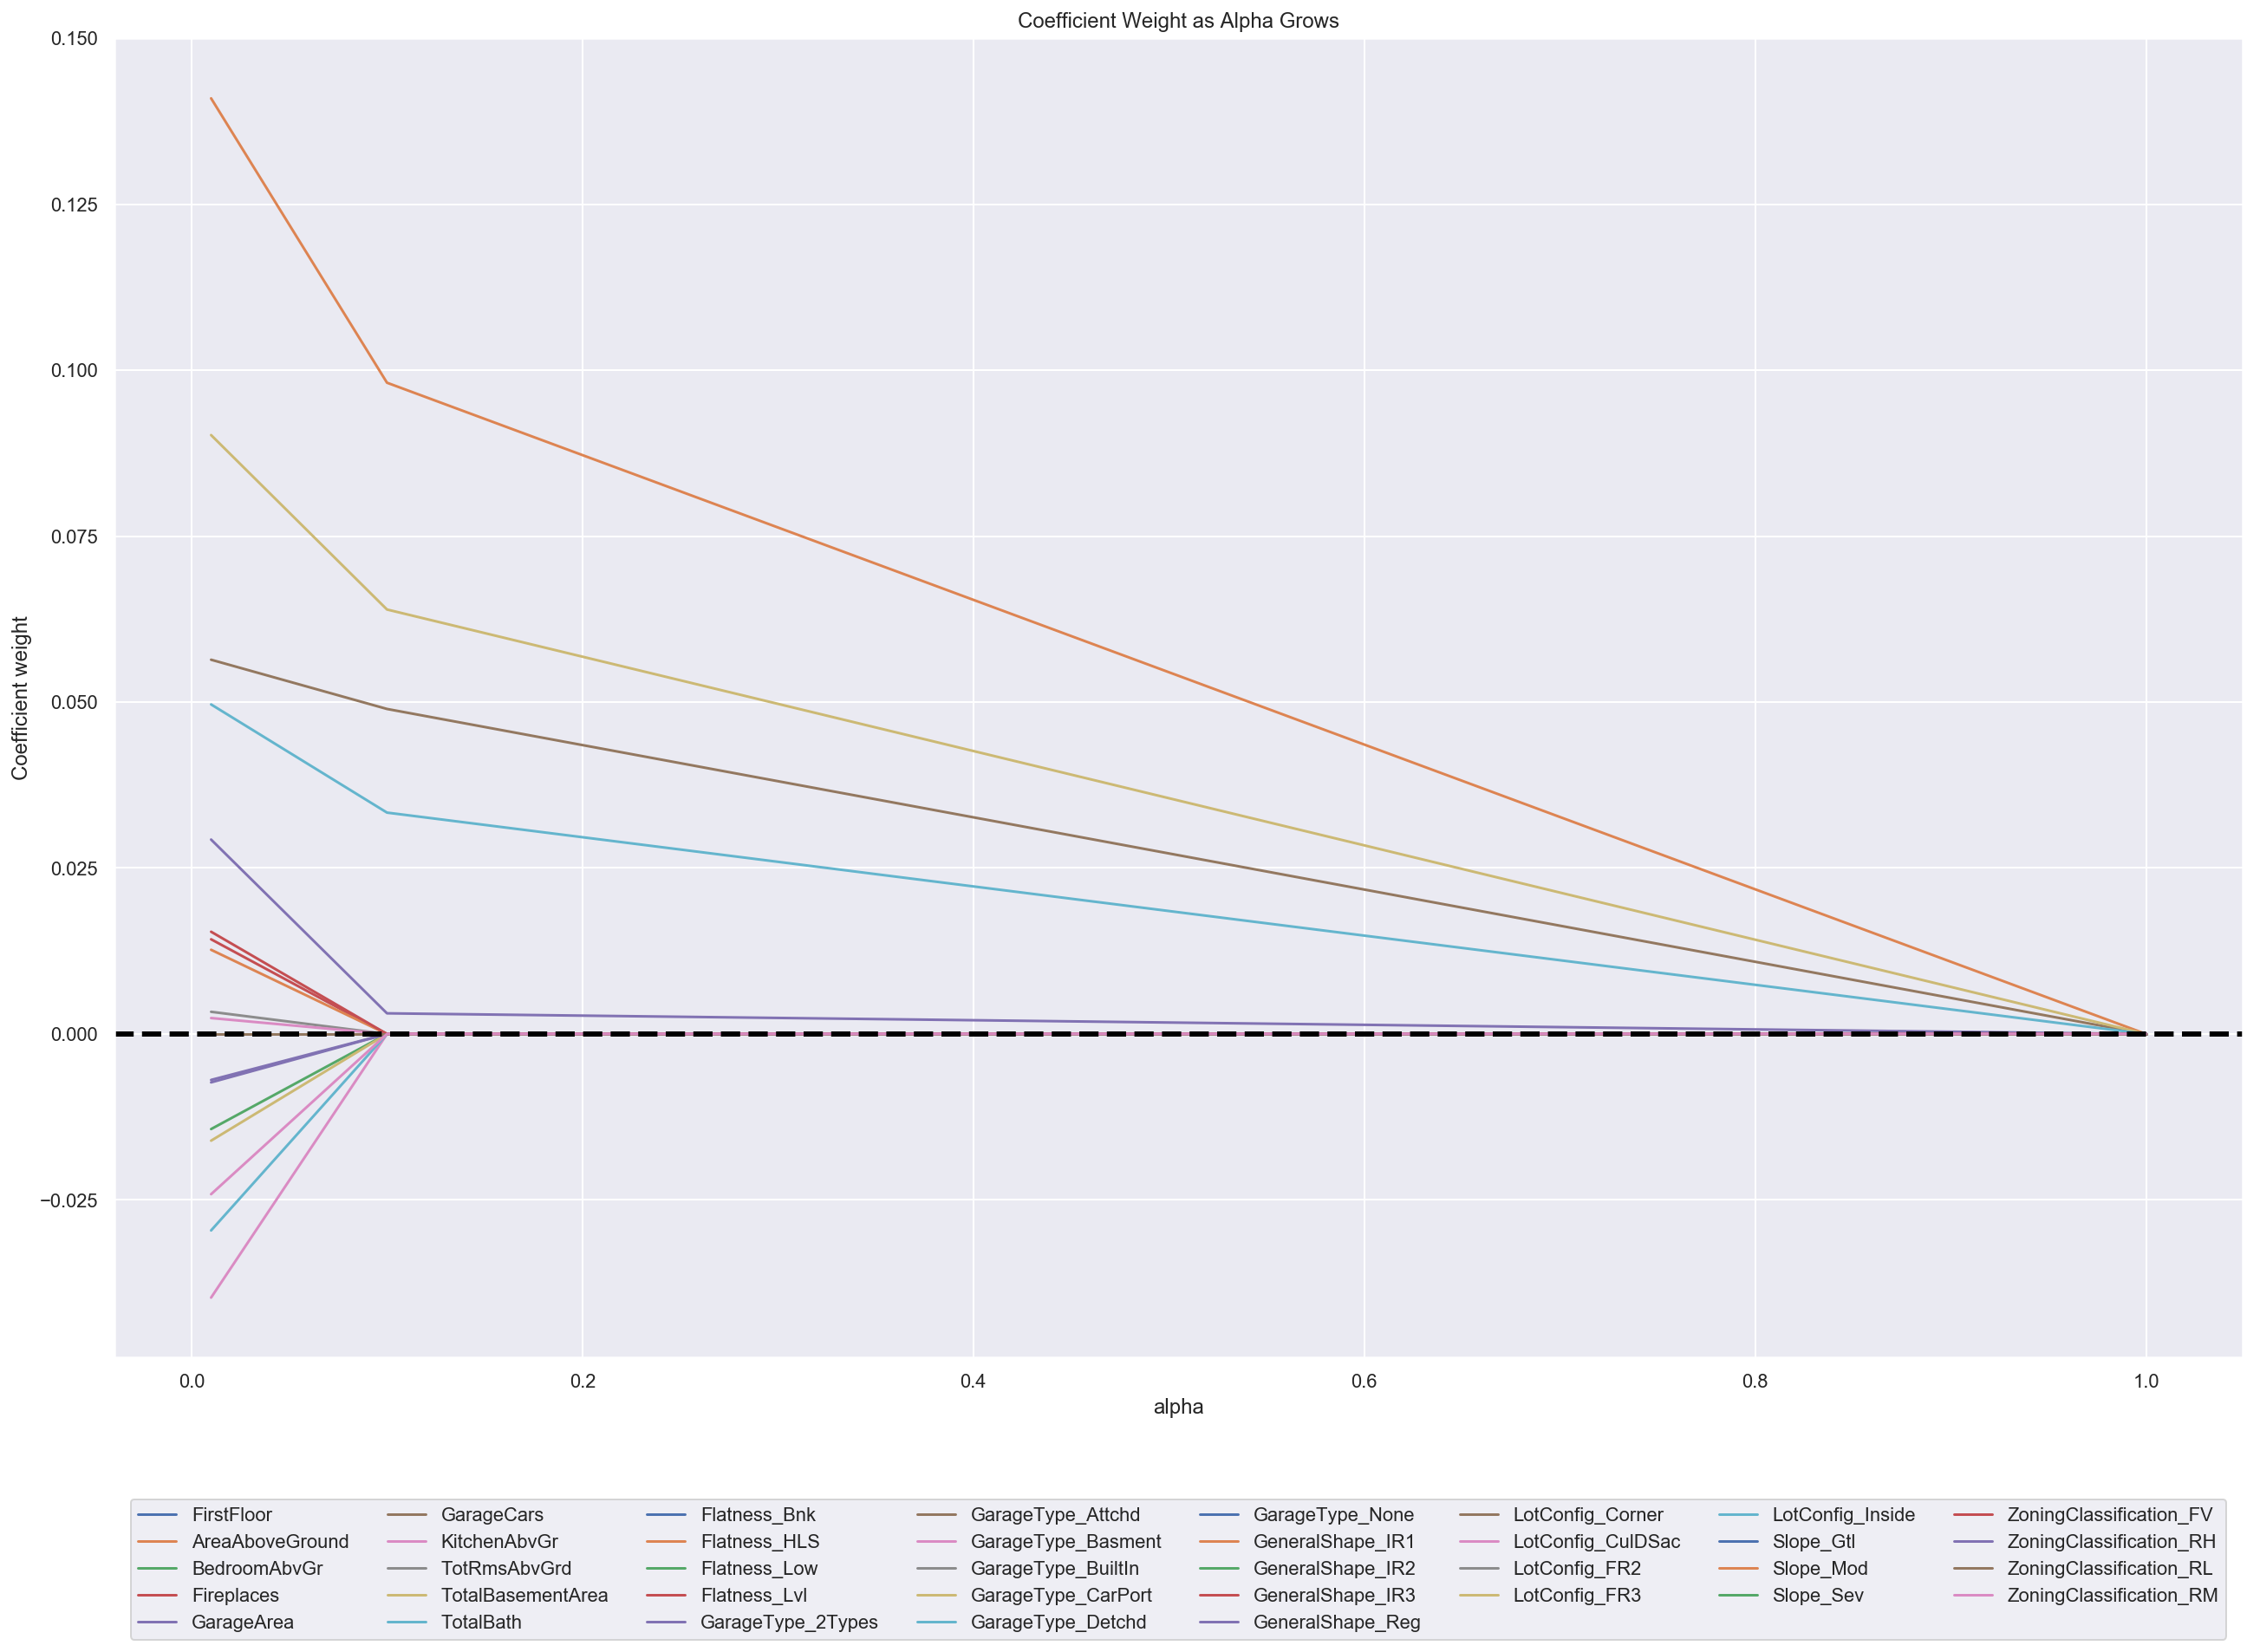

In [76]:
# does the same thing for Lasso mthd
# Regressor = Lasso()
alphas = [0.01, 0.1, 1]
lasso_weight = weight_versus_alpha_plot(Lasso, alphas, X_train_std, yTrain)

In [77]:
def best_alpha(CrossValidator, alpha_range, n_alphas, max_iter, Xtr, ytr, Xtt, ytt):
    # alpha: array of alpha values to try; must be positive, increase for more regularization
    # create an array of alpha values and select the best one with RidgeCV
    if max_iter == 0:
        if n_alphas  == 0:
            cv = CrossValidator(alphas = alpha_range, fit_intercept = True)
        else:
            cv = CrossValidator(n_alphas = n_alphas, fit_intercept = True)
    else:
        cv = CrossValidator(l1_ratio = alpha_range, 
                            n_alphas = n_alphas, 
                            cv = 10, max_iter=max_iter)
    cv.fit(Xtr, ytr)

    # examine the coefficients and the errors of the predictions 
    # using the best alpha value
    y_pred = cv.predict(Xtt)
    print('coefficients:\n', cv.coef_)
    print('\nbest alpha:\n' , cv.alpha_)
    print('\nRSS:', np.sum((ytt - y_pred) ** 2))
    coefs = cv.coef_
    optimal_alpha = cv.alpha_
    return coefs, optimal_alpha

In [78]:
# alpha: array of alpha values to try; must be positive, increase for more regularization
# create an array of alpha values and select the best one with RidgeCV

alpha_range = 10. ** np.arange(-2, 3)
ridge_coefs, ridge_alpha = best_alpha(RidgeCV,alpha_range,0,0,X_train_std, yTrain, X_test_std, yTest)


coefficients:
 [ 0.00286684  0.12815848 -0.03891919  0.0178054   0.03460735  0.05084719
 -0.04773701  0.03225436  0.08850612  0.04865617 -0.00477367  0.01731529
  0.00178669 -0.0083524  -0.01479736  0.01398156  0.00131926  0.01880346
 -0.02266724 -0.01971184  0.          0.00497178  0.00403444 -0.00456502
 -0.00549843 -0.00344728  0.00786427 -0.00550514  0.00157427  0.00057414
 -0.00079512  0.00123274 -0.00077901  0.02910745 -0.00267893  0.00493133
 -0.0239082 ]

best alpha:
 10.0

RSS: 7.83067665535502


In [79]:
# n_alphas: number of alpha values (automatically chosen) to try
# select the best alpha with LassoCV

lasso_coefs, lasso_alpha = best_alpha(LassoCV, [], 10, 0, X_train_std, yTrain, X_test_std, yTest)


coefficients:
 [ 0.          0.13566997 -0.03334244  0.01634731  0.03232165  0.05279068
 -0.0456317   0.02200274  0.09085294  0.0484502  -0.          0.0194173
  0.00370866 -0.00053445 -0.01379695  0.         -0.          0.00921887
 -0.02253616 -0.03154524  0.          0.          0.00089919 -0.00179854
 -0.00931433 -0.00136372  0.00654514 -0.00269142  0.          0.
 -0.          0.00017184  0.          0.02329638 -0.00206501  0.
 -0.02770145]

best alpha:
 0.0026706980242176153

RSS: 7.8589905012910295


In [80]:
# Similar things for ElasticNet
l1_ratios = np.linspace(0.01, 1.0, 25)
enet_coefs, enet_alpha = best_alpha(ElasticNetCV, l1_ratios, 30, 10000, X_train_std, yTrain, X_test_std, yTest)


coefficients:
 [ 0.          0.13525245 -0.03434827  0.01643968  0.03251609  0.05259675
 -0.04594467  0.0233091   0.09087319  0.04835055 -0.          0.01977095
  0.00400538 -0.00057524 -0.01419967  0.         -0.          0.00958543
 -0.02287705 -0.03166228  0.          0.          0.0010974  -0.00233141
 -0.00948349 -0.00176207  0.00666247 -0.00313379  0.          0.
 -0.          0.00040748  0.          0.0237252  -0.00231067  0.
 -0.02787623]

best alpha:
 0.0022785536977768172

RSS: 7.854453101523758


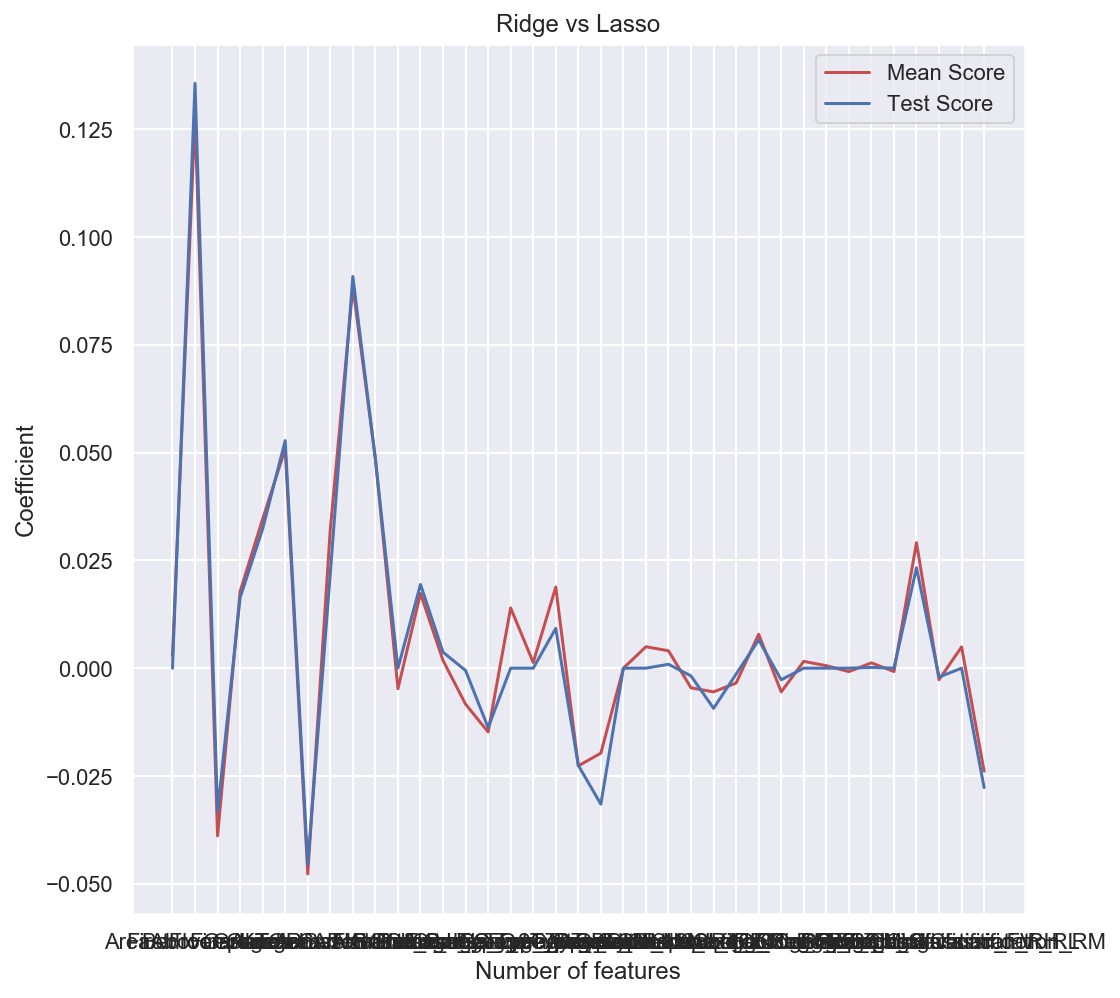

In [81]:
# Plot the coeficients vs number of features
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot(features, ridge_coefs , color='r', label='Mean Score')
ax1.plot(features, lasso_coefs , color='b', label='Test Score')
plt.xlabel('Number of features')
plt.ylabel('Coefficient')
plt.title('Ridge vs Lasso')
plt.legend(loc=1)
plt.show()

<a id='qn1j'></a>
## Model Accuray
[Back to top](#top)

In [82]:
model_list  = []
model_score = []
model_acc   = []
model_rmse   = []

def mode_accuracy(cvname, cv, Xts, yts, Xtt, ytt):
    cv_scores = cross_val_score(cv, Xts, yts, cv=10)
    print('cross_val_score : ', cv_scores)
    meanscore = np.mean(cv_scores)
    print('Mean Score ;', meanscore)
    
    cv.fit(Xts, yts)
    modescore = cv.score(Xtt, ytt)
    
    print(f'Model accuracy on test data: {modescore}')  
     
    y_pred = cv.predict(Xtt)
    rmse = np.sqrt(metrics.mean_squared_error(ytt, y_pred))
    print(f"RMSE = {rmse}")
    
    model_list.append(cvname)
    model_score.append(meanscore)
    model_acc.append(modescore)
    model_rmse.append(rmse)

    return 

In [83]:
cv = Ridge(ridge_alpha)
mode_accuracy('Ridge', cv, X_train_std, yTrain, X_test_std, yTest)

cross_val_score :  [0.81986729 0.82927693 0.86475979 0.81372708 0.86730251 0.85947313
 0.81751796 0.7683835  0.8754949  0.84392402]
Mean Score ; 0.8359727121424252
Model accuracy on test data: 0.8078592629477482
RMSE = 0.16936291587110044


In [84]:
cv = Lasso(lasso_alpha)
mode_accuracy('Lasso', cv, X_train_std, yTrain, X_test_std, yTest)

cross_val_score :  [0.81951641 0.82738105 0.8632297  0.81647317 0.87202797 0.86042653
 0.81711549 0.77092803 0.87838783 0.84756411]
Mean Score ; 0.83730502847268
Model accuracy on test data: 0.8071645281928308
RMSE = 0.16966882740721712


In [85]:
cv = ElasticNet(enet_alpha)
mode_accuracy('ElasticNet', cv, X_train_std, yTrain, X_test_std, yTest)

cross_val_score :  [0.82089382 0.82842893 0.86431249 0.81505951 0.86989455 0.86048847
 0.81780806 0.76986428 0.87690417 0.84624837]
Mean Score ; 0.8369902642846269
Model accuracy on test data: 0.8074993425810485
RMSE = 0.16952146799284493


In [86]:
models_performance = pd.DataFrame({'Model':model_list, 'mean score':model_score, 'accurary':model_acc, 'RMSE':model_rmse}).sort_values("accurary", ascending=False)
models_performance

Model  mean score  accurary      RMSE
0       Ridge    0.835973  0.807859  0.169363
2  ElasticNet    0.836990  0.807499  0.169521
1       Lasso    0.837305  0.807165  0.169669

<a id='qn1k'></a>
## Features Elimination
[Back to top](#top)

In [87]:
optimal_enet = ElasticNet(enet_alpha)
rfecv = RFECV(estimator=optimal_enet, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)
selector = rfecv.fit(xTrain, yTrain)

select_features_rfecv=selector.support_
print(selector.ranking_)

[ 2  1  1  1  1  1  1  1  1  1  9  1 12  1 16  1 13  1  1  1  7  4  8 10
  1  1  1 18 11 14 15 17  5  1  3  6  1]


In [88]:
# The column names correspond to the ones below. RFECV only excluded a few features.
enet_columns = np.array(list_cols)[selector.support_]

In [89]:
print(f"eliminated some, left with: {enet_columns.shape[0]} columns")

eliminated some, left with: 20 columns


In [90]:
optimal_ridge = Ridge(ridge_alpha)
rfecv = RFECV(estimator=optimal_ridge, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)
selector = rfecv.fit(xTrain, yTrain)

select_features_rfecv=selector.support_
print(selector.ranking_)

[2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [91]:
# The column names correspond to the ones below. RFECV only excluded a few features.
ridge_columns = np.array(list_cols)[selector.support_]

In [92]:
print(f"eliminated some, left with: {ridge_columns.shape[0]} columns")

eliminated some, left with: 35 columns


In [93]:
list_df(ridge_columns)

0                        1                        2
0           AreaAboveGround             BedroomAbvGr               Fireplaces
1                GarageArea               GarageCars             KitchenAbvGr
2              TotRmsAbvGrd        TotalBasementArea                TotalBath
3              Flatness_Bnk             Flatness_HLS             Flatness_Low
4              Flatness_Lvl        GarageType_2Types        GarageType_Attchd
5        GarageType_Basment       GarageType_BuiltIn       GarageType_CarPort
6         GarageType_Detchd         GeneralShape_IR1         GeneralShape_IR2
7          GeneralShape_IR3         GeneralShape_Reg         LotConfig_Corner
8         LotConfig_CulDSac            LotConfig_FR2            LotConfig_FR3
9          LotConfig_Inside                Slope_Gtl                Slope_Mod
10                Slope_Sev  ZoningClassification_FV  ZoningClassification_RH
11  ZoningClassification_RL  ZoningClassification_RM

In [94]:
optimal_lasso = Lasso(alpha = lasso_alpha)
rfecv = RFECV(estimator = optimal_lasso, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)
selector = rfecv.fit(xTrain, yTrain)

select_features_rfecv=selector.support_
print(selector.ranking_)

[ 1  1  1  1  1  1  1  1  1  1 16  1  5  1  9  1 13  1 18  1 12 11 15 10
  1  2  1 17 14  3  4  6  7  1  8  1  1]


In [95]:
# The column names correspond to the ones below. RFECV only excluded a few features.
lasso_columns = np.array(list_cols)[selector.support_]

In [96]:
print(f"eliminated some, left with: {lasso_columns.shape[0]} columns")

eliminated some, left with: 20 columns


In [97]:
rfecv_columns = lasso_columns
features = rfecv_columns


In [98]:
house_train[features].head()

Cols  FirstFloor  AreaAboveGround  BedroomAbvGr  Fireplaces  GarageArea  \
                                                                          
0          856.0           1710.0             3           0       548.0   
1         1262.0           1262.0             3           1       460.0   
2          920.0           1786.0             3           1       608.0   
3          961.0           1717.0             3           1       642.0   
4         1145.0           2198.0             4           1       836.0   

Cols  GarageCars  KitchenAbvGr  TotRmsAbvGrd  TotalBasementArea  TotalBath  \
                                                                             
0              2             1             8              856.0          4   
1              2             1             6             1262.0          3   
2              2             1             6              920.0          4   
3              3             1             7              756.0          2   
4              3             1             9             1145.0          4   

Cols  Flatness_HLS  Flatness_Lvl  GarageType_Attchd  GarageType_BuiltIn  \
                                                                          
0                0             1                  1                   0   
1                0             1                  1                   0   
2                0             1                  1                   0   
3                0             1                  0                   0   
4                0             1                  1                   0   

Cols  GarageType_Detchd  GeneralShape_Reg  LotConfig_CulDSac  \
                                                               
0                     0                 1                  0   
1                     0                 1                  0   
2                     0                 0                  0   
3                     1                 0                  0   
4                     0                 0                  0   

Cols  ZoningClassification_FV  ZoningClassification_RL  \
                                                         
0                           0                        1   
1                           0                        1   
2                           0                        1   
3                           0                        1   
4                           0                        1   

Cols  ZoningClassification_RM  
                               
0                           0  
1                           0  
2                           0  
3                           0  
4                           0

In [99]:
list_df(features)

0                        1                        2
0               FirstFloor          AreaAboveGround             BedroomAbvGr
1               Fireplaces               GarageArea               GarageCars
2             KitchenAbvGr             TotRmsAbvGrd        TotalBasementArea
3                TotalBath             Flatness_HLS             Flatness_Lvl
4        GarageType_Attchd       GarageType_BuiltIn        GarageType_Detchd
5         GeneralShape_Reg        LotConfig_CulDSac  ZoningClassification_FV
6  ZoningClassification_RL  ZoningClassification_RM

<a id='qn1l'></a>
## Model Validation
[Back to top](#top)

In [100]:
# Recall back we have done the model accessment with parameters
# ridge_coefs   ridge_alpha
# lasso_coefs   lasso_alpha
# enet_coefs    enet_alpha

models_performance

Model  mean score  accurary      RMSE
0       Ridge    0.835973  0.807859  0.169363
2  ElasticNet    0.836990  0.807499  0.169521
1       Lasso    0.837305  0.807165  0.169669

In [101]:
models_performance.sort_values("accurary", ascending=False)
print(f"The best model score is {models_performance.accurary[0]}")

The best model score is 0.8078592629477482


In [102]:
models_performance.sort_values("RMSE", ascending=False)
print(f"The best mean square error is {models_performance.RMSE[0]}")

The best mean square error is 0.16936291587110044


In [103]:
print(f"The selected model is {models_performance.Model[0]}")

The selected model is Ridge


In [104]:
TrainX = xTrain[features]
TestX = xTest[features]

# standardize them
std = StandardScaler()
TrainXstd = std.fit_transform(TrainX )
TestXstd = std.transform(TestX )

print(TrainX.shape, TestX.shape, TrainXstd.shape, TestXstd.shape)

(1092, 20) (273, 20) (1092, 20) (273, 20)


In [105]:
model_list  = []
model_score = []
model_acc   = []
model_rmse   = []

def mode_fit_test(cvname, cv, XTr, yTr, X, y):
    cv.fit(XTr, yTr)
    cv_scores = cross_val_score(cv, X, y, cv=10)
    meanscore = np.mean(cv_scores)
    modelscore = cv.score(X, y)
    y_pred = cv.predict(X)
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    print('Mean Score ;', meanscore)
    print(f'Model accuracy on test data: {model_score}')  
    print(f"RMSE = {rmse}")    
    model_list.append(cvname)
    model_acc.append(modelscore)
    model_rmse.append(rmse)
    model_score.append(meanscore)
    return

In [106]:
mode_fit_test('Ridge', optimal_ridge, TrainXstd, yTrain, TestXstd, yTest)

Mean Score ; 0.7927301821238885
Model accuracy on test data: []
RMSE = 0.16545023420369906


In [107]:
mode_fit_test('Lasso', optimal_lasso, TrainXstd, yTrain, TestXstd, yTest)

Mean Score ; 0.7952202530825978
Model accuracy on test data: [0.7927301821238885]
RMSE = 0.16638922569467937


In [108]:
mode_fit_test('ElasticNet', optimal_enet, TrainXstd, yTrain, TestXstd, yTest)

Mean Score ; 0.792448827172861
Model accuracy on test data: [0.7927301821238885, 0.7952202530825978]
RMSE = 0.16595215970492058


In [109]:
models_performance = pd.DataFrame({'Model':model_list, 'Mean score':model_score, 'Accurary':model_acc, 'RMSE':model_rmse}).sort_values("Accurary", ascending=False)
models_performance

Model  Mean score  Accurary      RMSE
0       Ridge    0.792730  0.816635  0.165450
2  ElasticNet    0.792449  0.815520  0.165952
1       Lasso    0.795220  0.814547  0.166389

<a id='qn1m'></a>
## Holdout Test
[Back to top](#top)

In [110]:
Xh = house_holdout[features].values
yh = house_holdout[target].values
Xh.shape

(80, 20)

In [111]:
model_name = []
model_rmse  = []
model_mae  = []
model_r2s  = []
model_mrs  = []

def model_test(modelname, cv, X, y):
    cv.fit(X,y)
    Ypred = cv.predict(X)
    rmse = np.sqrt(metrics.mean_squared_error(y, Ypred))
    r2 = metrics.r2_score(yh, Ypred)
    mae = mean_absolute_error(y_pred=np.expm1(Ypred), y_true=np.expm1(yh))
    print(f"RMSE = {rmse}")
    print("Mean Abs-Error R2:", mae)
    print("Cross-Predicted R2:", r2)

    # Residuals are the true y minus the predicted y.
    residuals = Ypred - yh
    mrs = np.mean(residuals)
    print('Mean residuals', mrs)
    model_name.append(modelname)
    model_rmse.append(rmse)
    model_mae.append(mae)
    model_r2s.append(r2)
    model_mrs.append(mrs)
    return


In [112]:
model_test('ElasticNet',optimal_enet, Xh, yh)

RMSE = 0.18631990279149152
Mean Abs-Error R2: 13876.56931910328
Cross-Predicted R2: 0.7259060419840445
Mean residuals 1.0880185641326535e-15


In [113]:
model_test('Lasso',optimal_lasso, Xh, yh)

RMSE = 0.18993770412331448
Mean Abs-Error R2: 14147.959133566485
Cross-Predicted R2: 0.7151584550258869
Mean residuals 5.551115123125783e-16


In [114]:
model_test('Ridge',optimal_ridge, Xh, yh)

RMSE = 0.1931535738111981
Mean Abs-Error R2: 14205.793023500044
Cross-Predicted R2: 0.7054313933231828
Mean residuals -4.440892098500626e-16


In [115]:
models_performance =  pd.DataFrame({'Model':model_name, 'R2 score':model_r2s, 'Mean Abs Err':model_mae, 'RMSE':model_rmse, 'Mean Residuals':model_mrs}).sort_values("R2 score", ascending=False)
models_performance

Model  R2 score  Mean Abs Err      RMSE  Mean Residuals
0  ElasticNet  0.725906  13876.569319  0.186320    1.088019e-15
1       Lasso  0.715158  14147.959134  0.189938    5.551115e-16
2       Ridge  0.705431  14205.793024  0.193154   -4.440892e-16

In [116]:
# backup global variables
fixed_features = features
fixed_coefs = optimal_lasso.coef_
fixed_alpha = optimal_lasso.alpha

<a id='qn1n'></a>
## Conclusion
[Back to top](#top)

In [117]:
# Lasso
score = models_performance['Mean Abs Err'].min()
print(f"the best estimates of price is ${score}")

the best estimates of price is $13876.56931910328


In [118]:
print("the alpha for the formula/estimator\n", fixed_alpha )
print("the beta's for the formula/estimator\n", fixed_coefs )

the alpha for the formula/estimator
 0.0026706980242176153
the beta's for the formula/estimator
 [ 5.12458669e-05  2.14656399e-04  4.88353147e-02  7.96449370e-02
  1.02454703e-03  0.00000000e+00 -6.77895440e-03 -1.93262472e-02
  2.30149974e-04  9.08041873e-02  7.94709435e-02  8.75929510e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.71791252e-02
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -6.07184198e-02]


In [119]:
print("the feature variables for the formula/estimator\n")
list_df(fixed_features)

the feature variables for the formula/estimator



0                        1                        2
0               FirstFloor          AreaAboveGround             BedroomAbvGr
1               Fireplaces               GarageArea               GarageCars
2             KitchenAbvGr             TotRmsAbvGrd        TotalBasementArea
3                TotalBath             Flatness_HLS             Flatness_Lvl
4        GarageType_Attchd       GarageType_BuiltIn        GarageType_Detchd
5         GeneralShape_Reg        LotConfig_CulDSac  ZoningClassification_FV
6  ZoningClassification_RL  ZoningClassification_RM

In [120]:
#Convert to old column names for the update features
print("Features converted to old column names\n")
for x in column_dict:
    col=column_dict[x]
    if col in features:
        print(f"'{x}'")
    else:
        for f in features:
            if f.find(col)>=0:
                val = f.split('_')[1]
                print(f"'{x}' with value = {val}")

Features converted to old column names

'MSZoning' with value = FV
'MSZoning' with value = RL
'MSZoning' with value = RM
'LotShape' with value = Reg
'LandContour' with value = HLS
'LandContour' with value = Lvl
'LotConfig' with value = CulDSac
'TotalBsmtSF'
'1stFlrSF'
'GrLivArea'
'BedroomAbvGr'
'KitchenAbvGr'
'TotRmsAbvGrd'
'Fireplaces'
'GarageType' with value = Attchd
'GarageType' with value = BuiltIn
'GarageType' with value = Detchd
'GarageCars'
'GarageArea'


<a id='qn1o'></a>
## Model Optimization
[Back to top](#top)

In [121]:
saleprice_actual = house.SalePrice

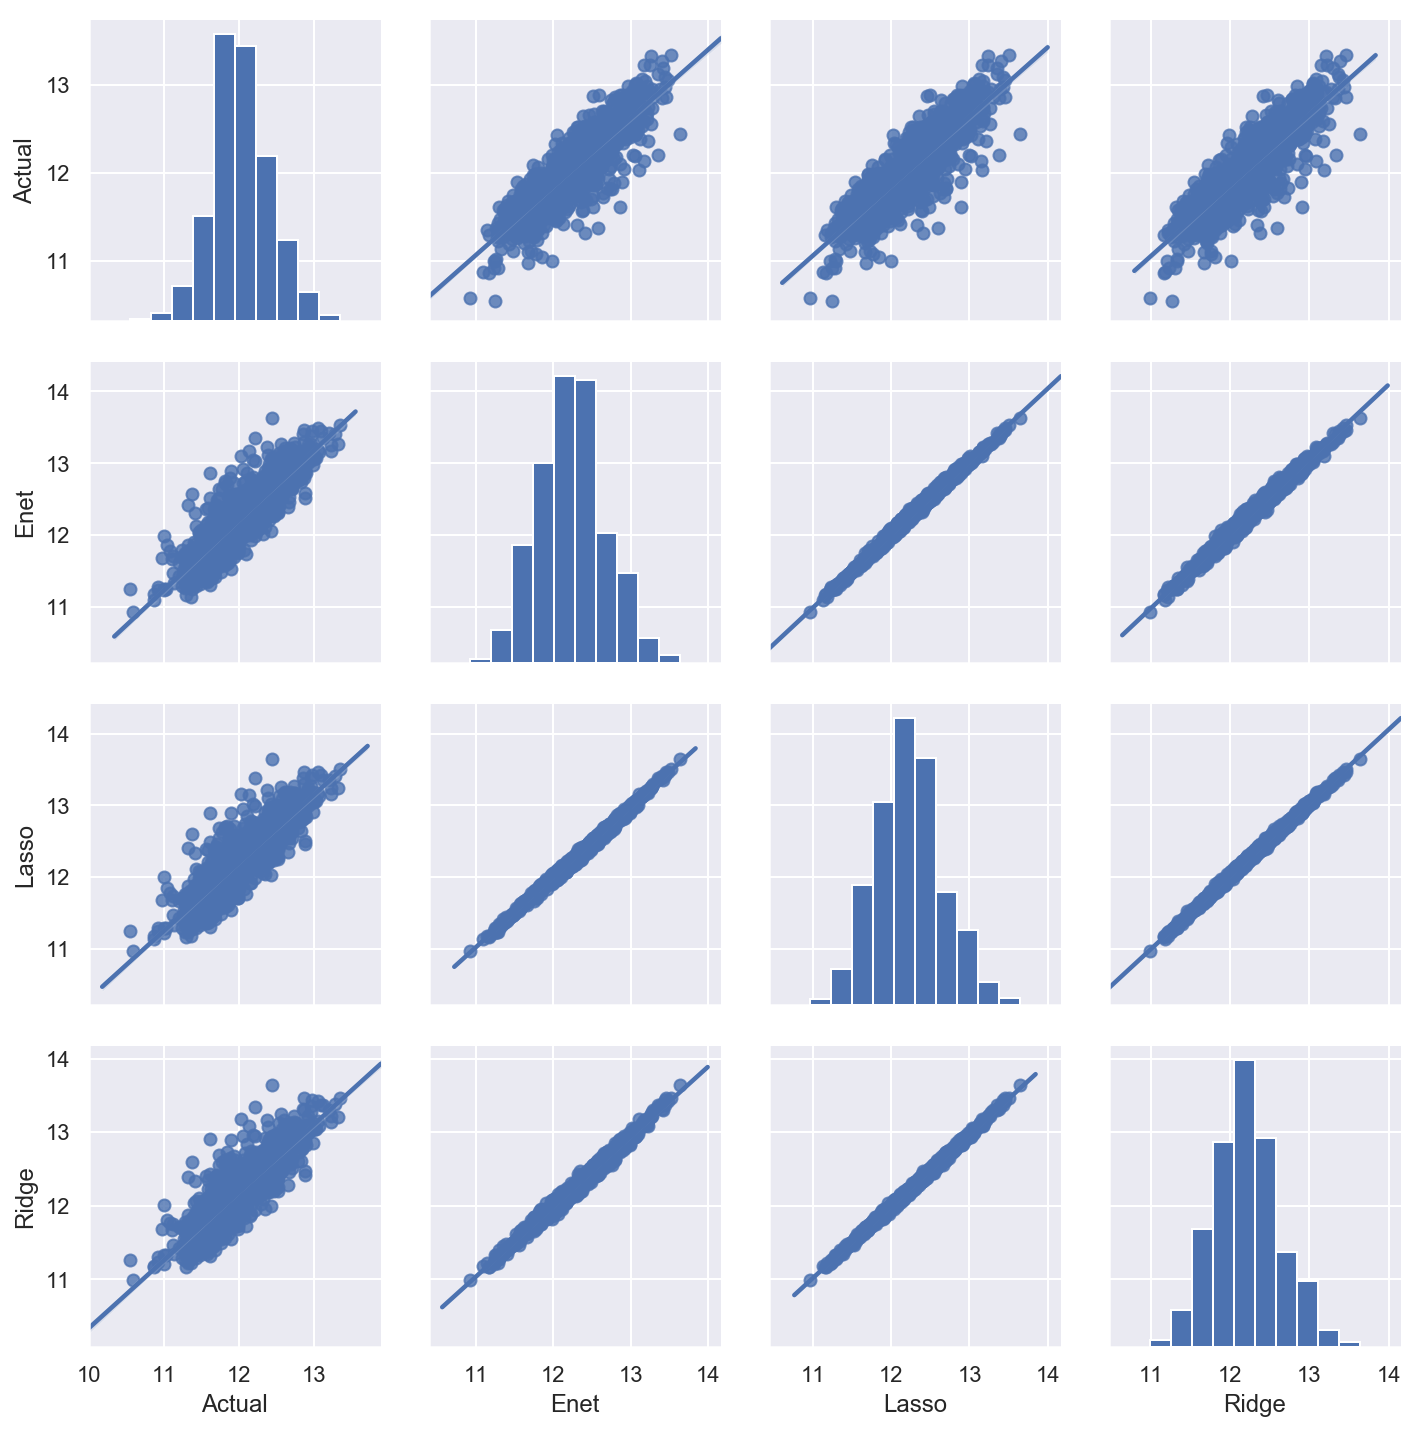

In [122]:
saleprice_pred_enet = optimal_enet.predict(house[features])
saleprice_pred_lasso = optimal_lasso.predict(house[features])
saleprice_pred_ridge = optimal_ridge.predict(house[features])
df = pd.DataFrame({'Actual':saleprice_actual, 
                   'Enet':saleprice_pred_enet,
                   'Lasso':saleprice_pred_lasso,
                   'Ridge':saleprice_pred_ridge
                  })
sns.pairplot(df,kind="reg")

In [123]:
Xprice = df[['Enet','Lasso','Ridge']].values
yprice = df.Actual.values
fixed_model = sm.OLS(yprice,Xprice)
result = fixed_model.fit()

total_abs_coef = abs(result.params[0])+abs(result.params[1])+abs(result.params[2])

enet_coef  = result.params[0]  
lasso_coef = result.params[1] 
ridge_coef = result.params[2]

enet_ratio = abs(result.params[0])  / total_abs_coef
lasso_ratio = abs(result.params[1]) / total_abs_coef
ridge_ratio = abs(result.params[2]) / total_abs_coef

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.607e+06
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        01:17:33   Log-Likelihood:                 217.98
No. Observations:                1445   AIC:                            -430.0
Df Residuals:                    1442   BIC:                            -414.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4485      0.245      5.903      0.000       0.967       1.930
x2            -2.1747      0.474     -4.586      0.000      -3.105      -1.244
x3             1.7108      0.280      6.112      0.000       1.162       2.260
==============================================================================
Omnibus:                      195.565   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              435.977
Skew:                          -0.782   Prob(JB):                     2.13e-95
Kurtosis:                       5.189   Cond. No.                     2.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [124]:
YPred_Formula =  "Enet *" + str(enet_ratio) + \
        "+ Lasso *" + str(lasso_ratio) + " + Ridge *" + str(ridge_ratio) 
print(YPred_Formula)

Enet *0.271554759023101+ Lasso *0.40770400705756765 + Ridge *0.3207412339193314


In [125]:
df['Ypred'] = df.eval(YPred_Formula)
df['Residuals'] = df.eval( "Ypred - Actual")

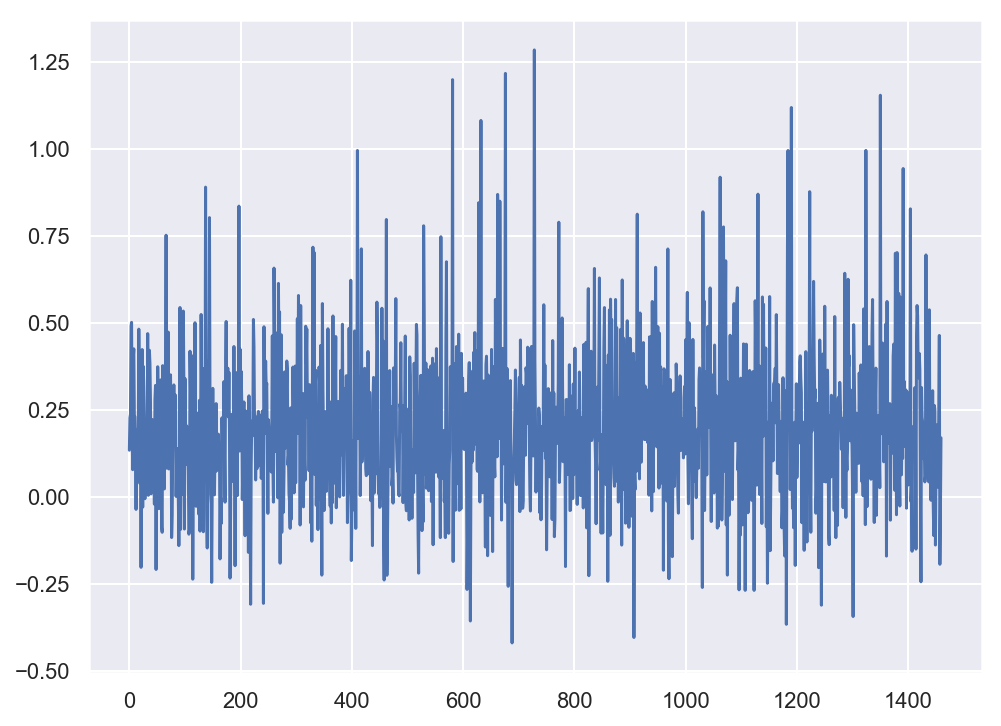

In [126]:
df['Residuals'].plot()

In [127]:
fixed_df = df.copy()
fixed_df.describe()

Actual         Enet        Lasso        Ridge        Ypred  \
count  1445.000000  1445.000000  1445.000000  1445.000000  1445.000000   
mean     12.028250    12.236377    12.227365    12.211862    12.224840   
std       0.388470     0.434172     0.425533     0.415380     0.424229   
min      10.542706    10.924724    10.965723    10.993505    10.963500   
25%      11.775290    11.931219    11.925793    11.919234    11.922597   
50%      12.007012    12.240255    12.226138    12.199598    12.221317   
75%      12.273731    12.496579    12.479008    12.458507    12.477480   
max      13.345507    13.636261    13.644530    13.639086    13.640538   

         Residuals  
count  1445.000000  
mean      0.196589  
std       0.213017  
min      -0.419580  
25%       0.057354  
50%       0.181658  
75%       0.315381  
max       1.283633

In [128]:
df_train = fixed_df.sample(1000).copy()
df_test = fixed_df[~fixed_df.index.isin(df_train.index)].copy()
fixed_df.shape, df_train.shape, df_test.shape

((1445, 6), (1000, 6), (445, 6))

In [129]:
X_test = df_test[['Enet', 'Lasso', 'Ridge', 'Ypred']]
y_test = df_test['Actual']

X_train = df_train[['Enet', 'Lasso', 'Ridge', 'Ypred']]
y_train = df_train['Actual']

In [130]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)

In [131]:
r2_score(y_test,y_test_pred)

0.7569276978626227

In [132]:
mean_squared_error(y_test,y_test_pred)

0.03523885222028552

<a id='qn2'></a>
<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<a id='qn2_1'></a>
## Section 2.1
Evaluate the effect in dollars of the renovate-able features.
- [Back to top](#top)
- [Section 2.1](#qn2_1)
- [Section 2.2](#qn2_2)
- [Section 2.3](#qn2_3)
- [Section 2.4](#qn2_4)

<a id='qn2a'></a>
## Analyzing the data
- [Back to top](#top)
- [Revised Data Description](#columns)

In [134]:
# Creating a list of the 'renovate-able' characteristics
list_cols = ['Utilities', 'OverallQuality', 'RatingCondition', \
 'RoofStyle', 'RoofMaterial', 'Exterior1st', 'Exterior2nd', 'MasonryType', \
 'MasonryArea', 'ExteriorQuality', 'ExterCond', 'BasementCondition', \
 'BasementExposure','RatingBasement1', 'RatingBasement2', 'Heating', \
 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', \
 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', \
 'GarageCond', 'PavedDrive', 'WoodDeckArea', 'OpenPorchArea', \
 'EnclosedPorchArea', 'SeasonPorchArea', 'ScreenPorch', 'PoolArea', \
 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']

In [135]:
# translated into current structure, 162 columns:
newcols=[]
for col in house.columns:
    if col in list_cols:
        newcols.append(col)
    else:
        c = col.split('_')[0]
        if c in list_cols:
            newcols.append(col)
list_df( newcols )

0                      1                     2
0           OverallQuality        RatingCondition           MasonryArea
1             WoodDeckArea          OpenPorchArea     EnclosedPorchArea
2          SeasonPorchArea            ScreenPorch              PoolArea
3                  MiscVal   BasementCondition_Fa  BasementCondition_Gd
4   BasementCondition_None   BasementCondition_Po  BasementCondition_TA
5      BasementExposure_Av    BasementExposure_Gd   BasementExposure_Mn
6      BasementExposure_No  BasementExposure_None          CentralAir_N
7             CentralAir_Y       Electrical_FuseA      Electrical_FuseF
8         Electrical_FuseP         Electrical_Mix       Electrical_None
9         Electrical_SBrkr           ExterCond_Ex          ExterCond_Fa
10            ExterCond_Gd           ExterCond_Po          ExterCond_TA
11     Exterior1st_AsbShng    Exterior1st_AsphShn   Exterior1st_BrkComm
12     Exterior1st_BrkFace     Exterior1st_CBlock   Exterior1st_CemntBd
13     Exterior1st_HdBoard    Exterior1st_ImStucc   Exterior1st_MetalSd
14     Exterior1st_Plywood      Exterior1st_Stone    Exterior1st_Stucco
15     Exterior1st_VinylSd    Exterior1st_Wd Sdng   Exterior1st_WdShing
16     Exterior2nd_AsbShng    Exterior2nd_AsphShn   Exterior2nd_Brk Cmn
17     Exterior2nd_BrkFace     Exterior2nd_CBlock   Exterior2nd_CmentBd
18     Exterior2nd_HdBoard    Exterior2nd_ImStucc   Exterior2nd_MetalSd
19       Exterior2nd_Other    Exterior2nd_Plywood     Exterior2nd_Stone
20      Exterior2nd_Stucco    Exterior2nd_VinylSd   Exterior2nd_Wd Sdng
21     Exterior2nd_Wd Shng     ExteriorQuality_Ex    ExteriorQuality_Fa
22      ExteriorQuality_Gd     ExteriorQuality_TA           Fence_GdPrv
23              Fence_GdWo            Fence_MnPrv            Fence_MnWw
24              Fence_None         FireplaceQu_Ex        FireplaceQu_Fa
25          FireplaceQu_Gd       FireplaceQu_None        FireplaceQu_Po
26          FireplaceQu_TA        Functional_Maj1       Functional_Maj2
27         Functional_Min1        Functional_Min2        Functional_Mod
28          Functional_Sev         Functional_Typ         GarageCond_Ex
29           GarageCond_Fa          GarageCond_Gd       GarageCond_None
30           GarageCond_Po          GarageCond_TA        GarageFinish_0
31        GarageFinish_Fin       GarageFinish_RFn      GarageFinish_Unf
32           GarageQual_Ex          GarageQual_Fa         GarageQual_Gd
33         GarageQual_None          GarageQual_Po         GarageQual_TA
34           Heating_Floor           Heating_GasA          Heating_GasW
35            Heating_Grav           Heating_OthW          Heating_Wall
36            HeatingQC_Ex           HeatingQC_Fa          HeatingQC_Gd
37            HeatingQC_Po           HeatingQC_TA        KitchenQual_Ex
38          KitchenQual_Fa         KitchenQual_Gd        KitchenQual_TA
39      MasonryType_BrkCmn    MasonryType_BrkFace      MasonryType_None
40       MasonryType_Stone       MiscFeature_Gar2      MiscFeature_None
41        MiscFeature_Othr       MiscFeature_Shed      MiscFeature_TenC
42            PavedDrive_N           PavedDrive_P          PavedDrive_Y
43               PoolQC_Ex              PoolQC_Fa             PoolQC_Gd
44             PoolQC_None    RatingBasement1_ALQ   RatingBasement1_BLQ
45     RatingBasement1_GLQ    RatingBasement1_LwQ  RatingBasement1_None
46     RatingBasement1_Rec    RatingBasement1_Unf   RatingBasement2_ALQ
47     RatingBasement2_BLQ    RatingBasement2_GLQ   RatingBasement2_LwQ
48    RatingBasement2_None    RatingBasement2_Rec   RatingBasement2_Unf
49    RoofMaterial_CompShg   RoofMaterial_Membran    RoofMaterial_Metal
50       RoofMaterial_Roll    RoofMaterial_TarGrv  RoofMaterial_WdShake
51    RoofMaterial_WdShngl         RoofStyle_Flat       RoofStyle_Gable
52       RoofStyle_Gambrel          RoofStyle_Hip     RoofStyle_Mansard
53          RoofStyle_Shed       Utilities_AllPub      Utilities_NoSeWa

<a id='qn2b'></a>
## Identifying Features
[Back to top](#top)

In [136]:
target = 'SalePrice'
list_cols = newcols + [target]
house[list_cols].corr()

Cols                    OverallQuality  RatingCondition  MasonryArea  \
Cols                                                                   
OverallQuality                1.000000        -0.106736     0.393740   
RatingCondition              -0.106736         1.000000    -0.132224   
MasonryArea                   0.393740        -0.132224     1.000000   
WoodDeckArea                  0.228223        -0.007735     0.147284   
OpenPorchArea                 0.309932        -0.030819     0.105983   
EnclosedPorchArea            -0.102831         0.079075    -0.106360   
SeasonPorchArea               0.030662         0.024953     0.020138   
ScreenPorch                   0.065600         0.053089     0.065754   
PoolArea                      0.017668         0.007807    -0.016100   
MiscVal                      -0.030573         0.069974    -0.029326   
BasementCondition_Fa         -0.130215        -0.040624    -0.070249   
BasementCondition_Gd          0.098865         0.072670    -0.008441   
BasementCondition_None       -0.215419        -0.085218    -0.060559   
BasementCondition_Po         -0.085000        -0.137126    -0.021468   
BasementCondition_TA          0.128423         0.034402     0.079558   
BasementExposure_Av           0.148446        -0.066336     0.051779   
BasementExposure_Gd           0.183331        -0.046390     0.146977   
BasementExposure_Mn           0.036883         0.048420    -0.011256   
BasementExposure_No          -0.172590         0.079792    -0.101624   
BasementExposure_None        -0.209790        -0.086393    -0.058762   
CentralAir_N                 -0.260955        -0.103515    -0.122228   
CentralAir_Y                  0.260955         0.103515     0.122228   
Electrical_FuseA             -0.202941        -0.016645    -0.101306   
Electrical_FuseF             -0.138358        -0.095594    -0.027832   
Electrical_FuseP             -0.037035         0.017172    -0.026303   
Electrical_Mix               -0.021367        -0.085058    -0.015175   
Electrical_None              -0.021367        -0.013834    -0.015175   
Electrical_SBrkr              0.253892         0.067568     0.108789   
ExterCond_Ex                  0.041253         0.140621    -0.026303   
ExterCond_Fa                 -0.140546        -0.122825    -0.049532   
...                                ...              ...          ...   
RatingBasement1_ALQ          -0.172641         0.164758    -0.043530   
RatingBasement1_BLQ          -0.180627         0.042016    -0.041993   
RatingBasement1_GLQ           0.425631        -0.161892     0.210059   
RatingBasement1_LwQ          -0.096262         0.030817    -0.063254   
RatingBasement1_None         -0.215419        -0.085218    -0.060559   
RatingBasement1_Rec          -0.170305         0.054372     0.002946   
RatingBasement1_Unf           0.061475        -0.016542    -0.096572   
RatingBasement2_ALQ           0.004593         0.081823     0.000593   
RatingBasement2_BLQ          -0.079829         0.036657    -0.023813   
RatingBasement2_GLQ          -0.002356         0.005368    -0.050228   
RatingBasement2_LwQ          -0.048643         0.025591    -0.029082   
RatingBasement2_None         -0.206608        -0.086393    -0.055056   
RatingBasement2_Rec          -0.082145         0.041260    -0.023307   
RatingBasement2_Unf           0.197626        -0.039679     0.076811   
RoofMaterial_CompShg         -0.045842        -0.024501     0.000250   
RoofMaterial_Membran          0.017348         0.033649    -0.015175   
RoofMaterial_Metal           -0.002009        -0.013834    -0.015175   
RoofMaterial_Roll            -0.021367        -0.013834     0.068934   
RoofMaterial_TarGrv          -0.024259         0.004240    -0.020524   
RoofMaterial_WdShake          0.056185         0.032816     0.029330   
RoofMaterial_WdShngl          0.082192         0.011552    -0.016774   
RoofStyle_Flat               -0.018058         0.022646    -0.039947   
RoofStyle_Gable              -0.156649  

In [137]:
house_info = overview(house[list_cols] , target)

# looking correlation value to SalesPrice
house_info.sort_values(by='corr',ascending=False)['corr'][:25]

Data shape: (1445, 163)
Data type
uint8      152
int64        3
float64      8
Name: Data type, dtype: int64




Cols
SalePrice              1.000000
OverallQuality         0.818874
ExteriorQuality_Gd     0.515088
HeatingQC_Ex           0.464022
RatingBasement1_GLQ    0.438883
MasonryArea            0.427122
GarageFinish_Fin       0.416477
KitchenQual_Gd         0.412800
KitchenQual_Ex         0.411338
GarageCond_TA          0.362809
ExteriorQuality_Ex     0.361360
OpenPorchArea          0.355540
FireplaceQu_Gd         0.352732
Exterior2nd_VinylSd    0.341825
Exterior1st_VinylSd    0.340371
GarageQual_TA          0.334282
CentralAir_Y           0.329154
WoodDeckArea           0.327566
MasonryType_Stone      0.320559
Electrical_SBrkr       0.290509
PavedDrive_Y           0.284936
BasementExposure_Gd    0.269862
GarageFinish_RFn       0.247647
MasonryType_BrkFace    0.226882
FireplaceQu_TA         0.207950
Name: corr, dtype: float64

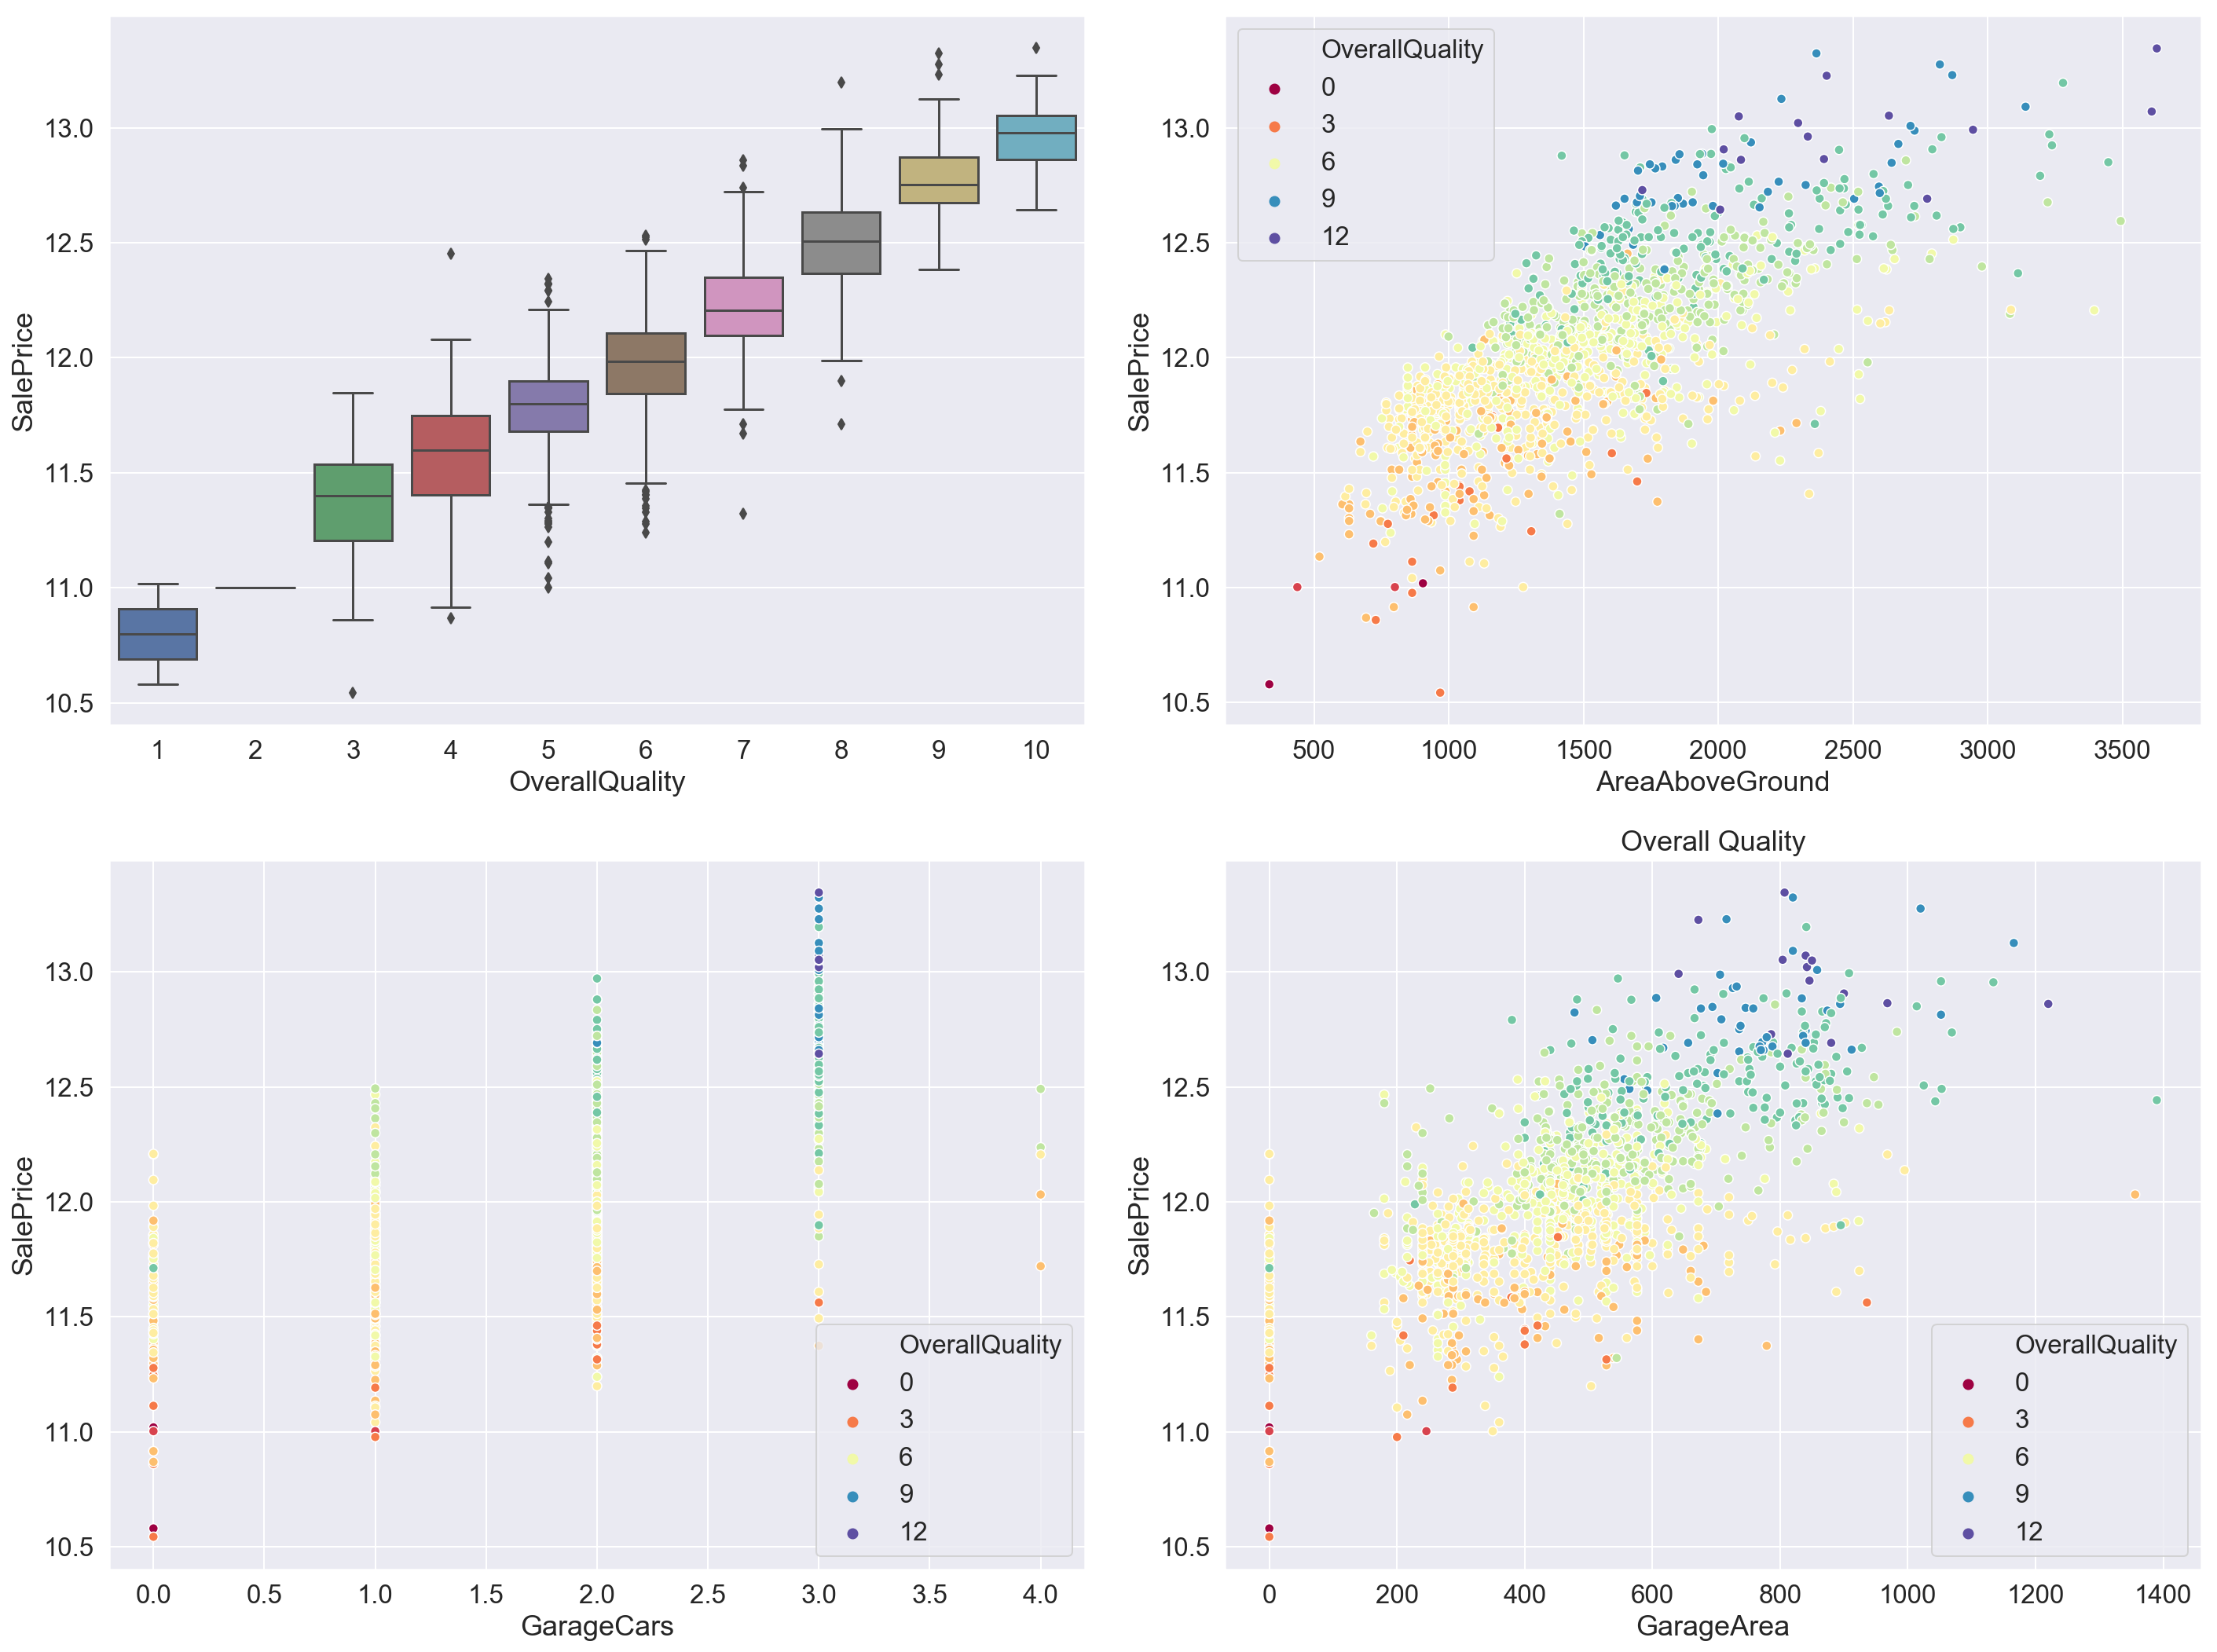

In [138]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig1 = fig.add_subplot(221); 
sns.boxplot(x='OverallQuality', y='SalePrice', data=house[['SalePrice', 'OverallQuality']])
fig2 = fig.add_subplot(222); 
sns.scatterplot(x = house.AreaAboveGround, y = house.SalePrice, hue=house.OverallQuality, palette= 'Spectral')
fig3 = fig.add_subplot(223); 
sns.scatterplot(x = house.GarageCars, y = house.SalePrice, hue=house.OverallQuality, palette= 'Spectral')
fig4 = fig.add_subplot(224); 
sns.scatterplot(x = house.GarageArea, y = house.SalePrice, hue=house.OverallQuality, palette= 'Spectral')


plt.title("Overall Quality")
plt.tight_layout(); plt.show()


<a id='qn2c'></a>
## Model Preparation
[Back to top](#top)

In [139]:
# same training data with renovate-able features in X
X = house_train[newcols]
y = house_train[target]
xTrain = hTrain[newcols]
xTest = hTest[newcols]
house_train.shape, X.shape, y.shape, hTrain.shape, xTrain.shape, xTest.shape

((1365, 303), (1365, 162), (1365,), (1092, 303), (1092, 162), (273, 162))

In [140]:
# standardize them
std = StandardScaler()
X_train_std = std.fit_transform(xTrain)
X_test_std = std.transform(xTest)
print(X_train_std.shape, X_test_std.shape)

(1092, 162) (273, 162)


<a id='qn2d'></a>
## Regularization
[Back to top](#top)

In [141]:
# alpha: array of alpha values to try; must be positive, increase for more regularization
# create an array of alpha values and select the best one with RidgeCV

alpha_range = 10. ** np.arange(-2, 3)
ridge_coefs, ridge_alpha = best_alpha(RidgeCV,alpha_range,0,0,X_train_std, yTrain, X_test_std, yTest)

coefficients:
 [ 1.17715592e-01  1.60167438e-02  4.06097109e-02  3.14948664e-02
  3.15724580e-02  5.88860740e-03  6.78486711e-03  1.36794709e-02
  3.91691498e-03  1.31084145e-03 -1.25695094e-02  9.45555404e-03
 -5.78643287e-03 -7.55209916e-03  3.71402562e-03 -7.91385581e-04
  2.29564779e-02  2.90337274e-03 -1.22135170e-02 -9.84175629e-03
 -8.69974695e-03  8.69974695e-03  7.82867072e-05  2.12777793e-04
 -1.08887064e-02 -7.55209916e-03  5.08043207e-03  1.87605742e-03
 -5.39148267e-03  3.98652539e-03 -2.72041232e-03  0.00000000e+00
  1.86470255e-03 -3.65185545e-04  0.00000000e+00 -7.89326463e-05
  2.26754558e-02 -9.15591023e-04  2.38189482e-03 -1.00639959e-02
  0.00000000e+00  1.54611267e-05  2.93631929e-03  7.17631412e-03
 -2.51089680e-03  2.68737749e-03 -6.17957365e-03 -8.36923531e-03
 -4.08498831e-03 -7.07276931e-03 -7.59150110e-04 -8.16362401e-03
 -9.15591023e-04 -5.98978271e-03  3.41545893e-03 -5.67580674e-03
 -1.06660281e-02  2.58998766e-03  8.21808193e-03  1.74838449e-03
 -5.188733

In [142]:
# n_alphas: number of alpha values (automatically chosen) to try
# select the best alpha with LassoCV

lasso_coefs, lasso_alpha = best_alpha(LassoCV, [], 10, 0, X_train_std, yTrain, X_test_std, yTest)

coefficients:
 [ 1.56843285e-01  9.93545298e-03  2.87287091e-02  3.15434400e-02
  2.95535882e-02  0.00000000e+00  0.00000000e+00  1.03136715e-02
  1.06477207e-03  0.00000000e+00 -8.85342001e-03  0.00000000e+00
 -0.00000000e+00 -3.16459834e-03  0.00000000e+00  0.00000000e+00
  2.27263484e-02  0.00000000e+00 -9.98013773e-03 -7.57886391e-03
 -1.43437014e-02  9.76020241e-18 -0.00000000e+00 -0.00000000e+00
 -3.14284976e-04 -8.17518955e-05  3.11778439e-04  1.70783460e-03
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  1.81264200e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  2.22904546e-03
 -0.00000000e+00  7.87928613e-04 -0.00000000e+00 -2.48232009e-04
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.59383571e-03  0.00000000e+00  7.91735679e-03  0.00000000e+00
 -0.000000

In [143]:
# Similar things for ElasticNet
l1_ratios = np.linspace(0.01, 1.0, 25)
enet_coefs, enet_alpha = best_alpha(ElasticNetCV, l1_ratios, 30, 10000, X_train_std, yTrain, X_test_std, yTest)

coefficients:
 [ 1.44114186e-01  1.23886122e-02  3.29620312e-02  3.14586498e-02
  3.03590082e-02  0.00000000e+00  2.43618618e-03  1.15127791e-02
  2.44264458e-03  0.00000000e+00 -1.06040798e-02  1.23868059e-03
 -1.66202496e-04 -2.43514202e-03  0.00000000e+00  0.00000000e+00
  2.27547474e-02  0.00000000e+00 -1.15339069e-02 -1.11035613e-02
 -7.82720912e-03  7.29948544e-03 -0.00000000e+00 -0.00000000e+00
 -2.47326950e-03 -2.28223772e-03  2.15385785e-03  1.28458744e-03
 -1.04663830e-03 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  1.93206254e-02 -0.00000000e+00  0.00000000e+00 -1.22587474e-03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  4.50471585e-03
 -5.86700797e-04  3.40765917e-03 -0.00000000e+00 -3.11030253e-03
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -9.34668031e-04
 -4.43115529e-03  0.00000000e+00  9.32671498e-03  0.00000000e+00
 -0.000000

In [144]:
# now we have regularization done, with following paratemers
# ridge_coefs ridge_alpha lasso_coefs lasso_alpha enet_coefs enet_alpha

<a id='qn2e'></a>
## Model Accuray
[Back to top](#top)

In [145]:
model_list  = []
model_score = []
model_acc   = []
model_rmse   = []

In [146]:
cv = Ridge(ridge_alpha)
mode_accuracy('Ridge', cv, X_train_std, yTrain, X_test_std, yTest)

cross_val_score :  [0.77459351 0.80128428 0.76375098 0.74962489 0.85294832 0.77907666
 0.7373532  0.74771291 0.79071357 0.78492678]
Mean Score ; 0.7781985111449033
Model accuracy on test data: 0.7722065439972899
RMSE = 0.18440777075939943


In [147]:
cv = Lasso(lasso_alpha)
mode_accuracy('Lasso', cv, X_train_std, yTrain, X_test_std, yTest)

cross_val_score :  [0.76964682 0.81389717 0.78295921 0.75319848 0.84664263 0.78983184
 0.7354999  0.75767016 0.80224249 0.78723953]
Mean Score ; 0.7838828236498678
Model accuracy on test data: 0.7811894406805268
RMSE = 0.18073519589932432


In [148]:
cv = ElasticNet(enet_alpha)
mode_accuracy('ElasticNet', cv, X_train_std, yTrain, X_test_std, yTest)

cross_val_score :  [0.7498232  0.79358994 0.77947987 0.733673   0.81938211 0.77370812
 0.72123285 0.74230582 0.79915489 0.76864276]
Mean Score ; 0.7680992550989443
Model accuracy on test data: 0.7687577229808175
RMSE = 0.18579850475888832


In [149]:
models_performance = pd.DataFrame({'Model':model_list, 'mean score':model_score, 'accurary':model_acc, 'RMSE':model_rmse}).sort_values("accurary", ascending=False)
models_performance

Model  mean score  accurary      RMSE
1       Lasso    0.783883  0.781189  0.180735
0       Ridge    0.778199  0.772207  0.184408
2  ElasticNet    0.768099  0.768758  0.185799

<a id='qn2f'></a>
## Features Elimination
[Back to top](#top)

In [150]:
optimal_ridge = Ridge(ridge_alpha)
rfecv = RFECV(estimator=optimal_ridge, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)
selector = rfecv.fit(xTrain, yTrain)

select_features_rfecv = selector.support_
print(selector.ranking_)

# The column names correspond to the ones below. RFECV only excluded a few features.
ridge_columns = np.array(newcols)[select_features_rfecv]


[ 1  1  1  1  1  3  1  1  1  6  1  1  1  1  1  1  1  4  1  1  1  1  1  1
  1  1  1  1  1  1  1 10  1  1 17  1  1  1  1  1 15  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 13  1  1 11  1  1  8  1  1  1
 16  1  1 14  1  1  1  1  1  1  5  1  1  1  1  9  1  1  1  1  1  1  1  1
  1  1  1  1  1  2  1  1  1  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 12  1  1  1  1  1  1  1  1  1  1  1  1]


In [151]:
print(f"eliminated some, left with: {ridge_columns.shape[0]} columns")

eliminated some, left with: 146 columns


In [152]:
optimal_lasso = Lasso(alpha = lasso_alpha)
rfecv = RFECV(estimator = optimal_lasso, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)
selector = rfecv.fit(xTrain, yTrain)

select_features_rfecv = selector.support_
print(selector.ranking_)

# The column names correspond to the ones below. RFECV only excluded a few features.
lasso_columns = np.array(newcols)[selector.support_]

[  1   1   1   1   1   2   1   1   1   3  10  12  14  16  18  20   1  24
   1  33  28  37  39  38  43  46  47  49  51  45  30  52  54  56  58  60
  62  64  66  68  70  72  74  76  78   1  81  83  85  87  90  91  93  95
  97  99 101 103 105 107 109 111 113 115  89   7  21   1 119 121 122 123
 125 127 129 131   1 135 137 139 141 140 138 136 134 120 118  88  86  84
  82  80  50   1  44   1   6   8   9  11  13  15  17  19   5  27  23  25
   1  29  32  34  35   1  40  41   1  48   1  53  55  57  59  61  63  65
  67  69  71  73  75  77  79  26  31   1  22  36  42   1  92  94  96  98
 100 102 104 106 108 110 112 114 116 117   4   1 124 126 128 130 132 133]


In [153]:
print(f"eliminated some, left with: {lasso_columns.shape[0]} columns")

eliminated some, left with: 22 columns


In [154]:
optimal_enet = ElasticNet(enet_alpha)
rfecv = RFECV(estimator = optimal_enet, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)
selector = rfecv.fit(xTrain, yTrain)

select_features_rfecv = selector.support_
print(selector.ranking_)

# The column names correspond to the ones below. RFECV only excluded a few features.
enet_columns = np.array(newcols)[select_features_rfecv]

[  1   9   1   1   1   1   1   1   1   2  14  16  18  21  23  25  27  20
   1  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62
  64  66  68  69  71  73  75  77  79  81  83  85  87  89  90  91  93  95
  97  99 101 103 105 107 109 111 113 115 117 119 121 123 125 127 129 131
 133 135 137 139   1 143 145 147 149 148 146 144 142  88  86  84  82  80
  78  76  74  72  70   1   3   4   5  10  11  12   6  13  15  17  19   8
   1  22  24  26  28  29  31  33   1  35  37  39  41  43  45  47  49  51
  53  55  57  59  61  63  65  67   7   1  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 141]


In [155]:
print(f"eliminated some, left with: {enet_columns.shape[0]} columns")

eliminated some, left with: 14 columns


In [156]:
rfecv_columns = enet_columns
features = rfecv_columns
reno_features = rfecv_columns
reno_coefs = optimal_enet.l1_ratio
house_train[features].head()

Cols  OverallQuality  MasonryArea  WoodDeckArea  OpenPorchArea  \
                                                                 
0                  7        196.0           0.0           61.0   
1                  6          0.0         298.0            0.0   
2                  7        162.0           0.0           42.0   
3                  7          0.0           0.0           35.0   
4                  8        350.0         192.0           84.0   

Cols  EnclosedPorchArea  SeasonPorchArea  ScreenPorch  PoolArea  \
                                                                  
0                   0.0              0.0          0.0       0.0   
1                   0.0              0.0          0.0       0.0   
2                   0.0              0.0          0.0       0.0   
3                 272.0              0.0          0.0       0.0   
4                   0.0              0.0          0.0       0.0   

Cols  BasementExposure_No  FireplaceQu_None  GarageFinish_Unf  HeatingQC_Ex  \
                                                                              
0                       1                 1                 0             1   
1                       0                 0                 0             1   
2                       0                 0                 0             1   
3                       1                 0                 1             0   
4                       0                 0                 0             1   

Cols  KitchenQual_TA  RatingBasement1_GLQ  
                                           
0                  0                    1  
1                  1                    0  
2                  0                    1  
3                  0                    0  
4                  0                    1

In [157]:
list_df(features, 4)

0                    1                 2              3
0       OverallQuality          MasonryArea      WoodDeckArea  OpenPorchArea
1    EnclosedPorchArea      SeasonPorchArea       ScreenPorch       PoolArea
2  BasementExposure_No     FireplaceQu_None  GarageFinish_Unf   HeatingQC_Ex
3       KitchenQual_TA  RatingBasement1_GLQ

In [158]:
features

array(['OverallQuality', 'MasonryArea', 'WoodDeckArea', 'OpenPorchArea',
       'EnclosedPorchArea', 'SeasonPorchArea', 'ScreenPorch', 'PoolArea',
       'BasementExposure_No', 'FireplaceQu_None', 'GarageFinish_Unf',
       'HeatingQC_Ex', 'KitchenQual_TA', 'RatingBasement1_GLQ'],
      dtype='<U22')

<a id='qn2g'></a>
## Model Validation
[Back to top](#top)

In [159]:
# same training data with renovate-able features in X
X = house_train[features]
y = house_train[target]
xTrain = hTrain[features]
xTest = hTest[features]
X.shape, y.shape, hTrain.shape, xTrain.shape, xTest.shape

((1365, 14), (1365,), (1092, 303), (1092, 14), (273, 14))

In [160]:
# standardize them
std = StandardScaler()
X_train_std = std.fit_transform(xTrain)
X_test_std = std.transform(xTest)
print(X_train_std.shape, X_test_std.shape)

(1092, 14) (273, 14)


In [161]:
model_list  = []
model_score = []
model_acc   = []
model_rmse   = []

In [162]:
mode_fit_test('Ridge', optimal_ridge, TrainXstd, yTrain, TestXstd, yTest)

Mean Score ; 0.7816247892944931
Model accuracy on test data: []
RMSE = 0.16778120916337447


In [163]:
mode_fit_test('Lasso', optimal_lasso, TrainXstd, yTrain, TestXstd, yTest)

Mean Score ; 0.7931657336535192
Model accuracy on test data: [0.7816247892944931]
RMSE = 0.16923795872769642


In [164]:
mode_fit_test('ElasticNet', optimal_enet, TrainXstd, yTrain, TestXstd, yTest)

Mean Score ; 0.7805852204392306
Model accuracy on test data: [0.7816247892944931, 0.7931657336535192]
RMSE = 0.17933643306809255


In [165]:
models_performance = pd.DataFrame({'Model':model_list, 'Mean score':model_score, 'Accurary':model_acc, 'RMSE':model_rmse}).sort_values("RMSE", ascending=True)
models_performance

Model  Mean score  Accurary      RMSE
0       Ridge    0.781625  0.811431  0.167781
1       Lasso    0.793166  0.808143  0.169238
2  ElasticNet    0.780585  0.784563  0.179336

<a id='qn2h'></a>
## Holdout Test
[Back to top](#top)

In [166]:
Xh = house_holdout[features].values
yh = house_holdout[target].values
Xh.shape

(80, 14)

In [167]:
model_name = []
model_rmse  = []
model_mae  = []
model_r2s  = []
model_mrs  = []

In [168]:
model_test('ElasticNet',optimal_enet, Xh, yh)

RMSE = 0.2647124204480982
Mean Abs-Error R2: 22400.588317515365
Cross-Predicted R2: 0.44673957933627784
Mean residuals 1.1102230246251565e-15


In [169]:
model_test('Lasso',optimal_lasso, Xh, yh)

RMSE = 0.25950924706906003
Mean Abs-Error R2: 22292.543347907536
Cross-Predicted R2: 0.46827553902201036
Mean residuals 1.2434497875801752e-15


In [170]:
model_test('Ridge',optimal_ridge, Xh, yh)

RMSE = 0.2795944552240547
Mean Abs-Error R2: 23118.82371048341
Cross-Predicted R2: 0.3827827243216031
Mean residuals 5.329070518200751e-16


In [171]:
models_performance =  pd.DataFrame({'Model':model_name, 'R2 score':model_r2s, 'Mean Abs Err':model_mae, 'RMSE':model_rmse, 'Mean Residuals':model_mrs}).sort_values("Mean Abs Err", ascending=False)
models_performance

Model  R2 score  Mean Abs Err      RMSE  Mean Residuals
2       Ridge  0.382783  23118.823710  0.279594    5.329071e-16
0  ElasticNet  0.446740  22400.588318  0.264712    1.110223e-15
1       Lasso  0.468276  22292.543348  0.259509    1.243450e-15

In [172]:
# backup global variables
reno_features = enet_columns
reno_coefs  = optimal_lasso.coef_
reno_alpha = optimal_lasso,alpha

<a id='qn2i'></a>
## Conclusion
[Back to top](#top)

In [173]:
score = models_performance['Mean Abs Err'].min()
print(f"the best estimates of price is ${score}")

the best estimates of price is $22292.543347907536


In [174]:
print("the alpha for the formula/estimator\n", reno_alpha )
print("the beta's for the formula/estimator\n", reno_coefs )

the alpha for the formula/estimator
 (Lasso(alpha=0.006368346797032063, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False), 10000)
the beta's for the formula/estimator
 [ 1.59042655e-01  6.46257342e-04  7.40838204e-04  1.27804833e-04
 -9.14006320e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -7.51021578e-02  0.00000000e+00  6.26477769e-02
 -0.00000000e+00  4.07153866e-03]


In [175]:
print("the feature variables for the formula/estimator\n")
list_df(reno_features)

the feature variables for the formula/estimator



0                    1                    2
0    OverallQuality          MasonryArea         WoodDeckArea
1     OpenPorchArea    EnclosedPorchArea      SeasonPorchArea
2       ScreenPorch             PoolArea  BasementExposure_No
3  FireplaceQu_None     GarageFinish_Unf         HeatingQC_Ex
4    KitchenQual_TA  RatingBasement1_GLQ

In [176]:
#Convert to old column names for the update features
print("Features converted to old column names\n")
for x in column_dict:
    col=column_dict[x]
    if col in features:
        print(f"'{x}'")
    else:
        for f in features:
            if f.find(col)>=0:
                val = f.split('_')[1]
                print(f"'{x}' with value = {val}")

Features converted to old column names

'OverallQual'
'MasVnrArea'
'BsmtExposure' with value = No
'BsmtFinType1' with value = GLQ
'Heating' with value = Ex
'HeatingQC' with value = Ex
'KitchenQual' with value = TA
'FireplaceQu' with value = None
'GarageFinish' with value = Unf
'WoodDeckSF'
'OpenPorchSF'
'EnclosedPorch'
'3SsnPorch'
'ScreenPorch'
'PoolArea'


<a id='qn2j'></a>
## Model Optimization
[Back to top](#top)

In [177]:
saleprice_actual = house.SalePrice

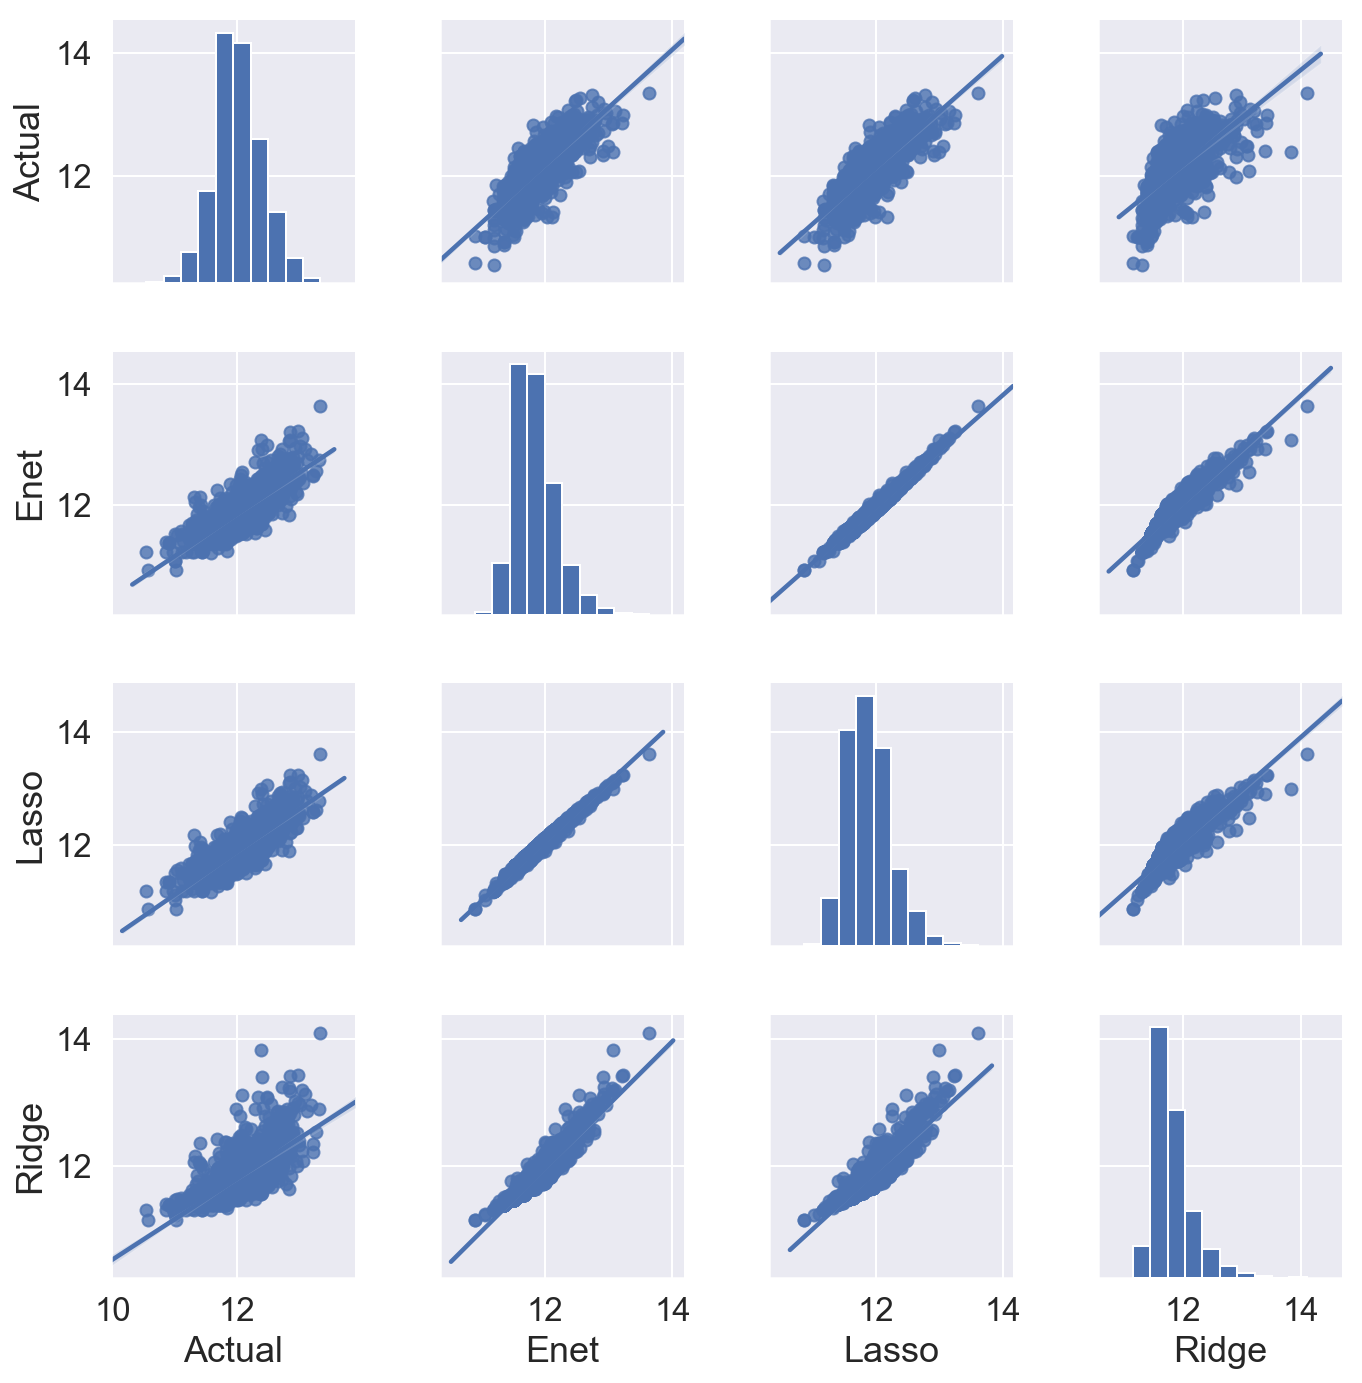

In [178]:
saleprice_pred_enet = optimal_enet.predict(house[features])
saleprice_pred_lasso = optimal_lasso.predict(house[features])
saleprice_pred_ridge = optimal_ridge.predict(house[features])
df = pd.DataFrame({'Actual':saleprice_actual, 
                   'Enet':saleprice_pred_enet,
                   'Lasso':saleprice_pred_lasso,
                   'Ridge':saleprice_pred_ridge
                  })
sns.pairplot(df,kind="reg")

In [179]:
Xprice = df[['Enet','Lasso','Ridge']].values
yprice = df.Actual.values
fixed_model = sm.OLS(yprice,Xprice)
result = fixed_model.fit()

total_abs_coef = abs(result.params[0])+abs(result.params[1])+abs(result.params[2])

enet_coef  = result.params[0]  
lasso_coef = result.params[1] 
ridge_coef = result.params[2]

enet_ratio = abs(result.params[0])  / total_abs_coef
lasso_ratio = abs(result.params[1]) / total_abs_coef
ridge_ratio = abs(result.params[2]) / total_abs_coef

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.589e+06
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        01:20:38   Log-Likelihood:                 209.97
No. Observations:                1445   AIC:                            -413.9
Df Residuals:                    1442   BIC:                            -398.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2089      0.168      1.241      0.215      -0.121       0.539
x2             1.2414      0.132      9.407      0.000       0.983       1.500
x3            -0.4412      0.057     -7.705      0.000      -0.554      -0.329
==============================================================================
Omnibus:                       29.451   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.908
Skew:                          -0.234   Prob(JB):                     2.16e-09
Kurtosis:                       3.667   Cond. No.                         801.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [180]:
YPred_Formula =  "Enet *" + str(enet_ratio) + \
        "+ Lasso *" + str(lasso_ratio) + " + Ridge *" + str(ridge_ratio) 
print(YPred_Formula)

Enet *0.11043531866863637+ Lasso *0.6563164655996829 + Ridge *0.23324821573168072


In [181]:
df['Ypred'] = df.eval(YPred_Formula)
df['Residuals'] = df.eval( "Ypred - Actual")

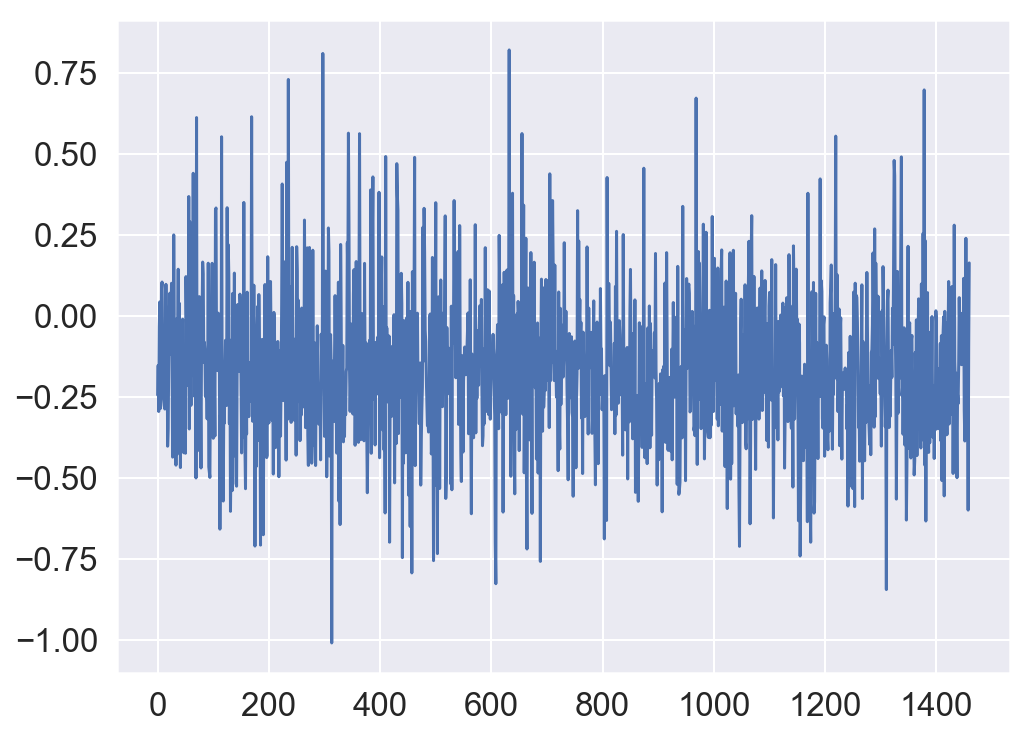

In [182]:
df['Residuals'].plot()

In [183]:
reno_df = df.copy()
reno_df.describe()

Actual         Enet        Lasso        Ridge        Ypred  \
count  1445.000000  1445.000000  1445.000000  1445.000000  1445.000000   
mean     12.028250    11.852460    11.891609    11.811700    11.868647   
std       0.388470     0.332353     0.353026     0.351192     0.345253   
min      10.542706    10.908349    10.867068    11.143559    10.936118   
25%      11.775290    11.601762    11.617327    11.557246    11.603865   
50%      12.007012    11.824329    11.879227    11.733182    11.834217   
75%      12.273731    12.023568    12.090564    11.963317    12.048818   
max      13.345507    13.637412    13.607971    14.096857    13.725254   

         Residuals  
count  1445.000000  
mean     -0.159603  
std       0.228124  
min      -1.008434  
25%      -0.305492  
50%      -0.171916  
75%      -0.027593  
max       0.822118

<a id='qn2_2'></a>
## Section 2.2

How would your company use this second model and its coefficients to determine whether they should buy a property or not? 

Explain how the company can use the two models you have built to determine if they can make money.
- [Back to top](#top)
- [Section 2.1](#qn2_1)
- [Section 2.2](#qn2_2)
- [Section 2.3](#qn2_3)
- [Section 2.4](#qn2_4)

In [184]:
df = fixed_df[['Actual']].copy()
df['Fixed'] = fixed_df['Ypred']
df['Reno'] = reno_df['Ypred']

In [185]:
Xprice = df[['Fixed','Reno']].values
yprice = df.Actual.values

fixed_model = sm.OLS(yprice,Xprice)
result = fixed_model.fit()

total_abs_coef = abs(result.params[0]) + abs(result.params[1])

fixed_coef  = result.params[0]  
reno_coef = result.params[1] 

fixed_ratio = abs(result.params[0])  / total_abs_coef
reno_ratio = abs(result.params[1]) / total_abs_coef

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.730e+06
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        01:20:39   Log-Likelihood:                 532.78
No. Observations:                1445   AIC:                            -1062.
Df Residuals:                    1443   BIC:                            -1051.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5417      0.015     35.377      0.000       0.512       0.572
x2             0.4555      0.016     28.872      0.000       0.425       0.486
==============================================================================
Omnibus:                      126.954   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              312.215
Skew:                          -0.502   Prob(JB):                     1.60e-68
Kurtosis:                       5.044   Cond. No.                         85.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
YPred_Formula =  "Fixed *" + str(fixed_ratio) + " + Reno *" + str(reno_ratio) 
print(YPred_Formula)

Fixed *0.543248659489196 + Reno *0.456751340510804


In [187]:
df['Ypred'] = df.eval(YPred_Formula)
df['Residuals'] = df.eval( "Ypred - Actual")

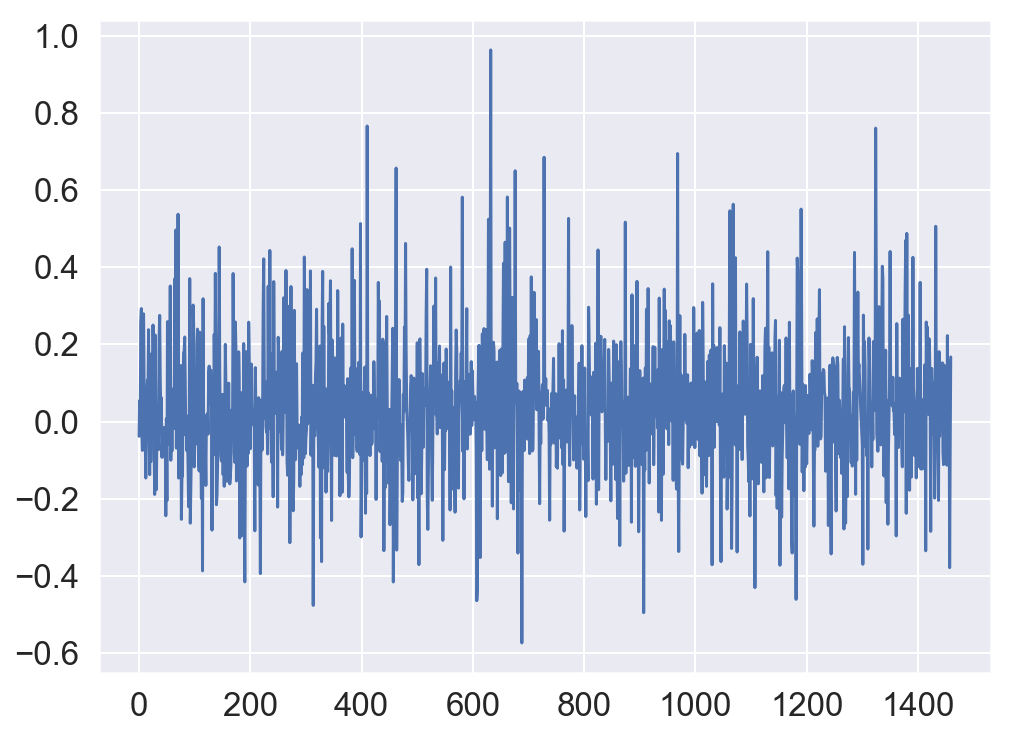

In [188]:
df['Residuals'].plot()

In [189]:
df.describe()

Actual        Fixed         Reno        Ypred    Residuals
count  1445.000000  1445.000000  1445.000000  1445.000000  1445.000000
mean     12.028250    12.224840    11.868647    12.062148     0.033898
std       0.388470     0.424229     0.345253     0.363103     0.167484
min      10.542706    10.963500    10.936118    10.950993    -0.573584
25%      11.775290    11.922597    11.603865    11.801957    -0.066454
50%      12.007012    12.221317    11.834217    12.044603     0.021729
75%      12.273731    12.477480    12.048818    12.263278     0.122595
max      13.345507    13.640538    13.725254    13.602761     0.962831

<a id='qn2_3'></a>
## Section 2.3

Investigate how much of the variance in price remaining is explained by these features.

- [Back to top](#top)
- [Section 2.1](#qn2_1)
- [Section 2.2](#qn2_2)
- [Section 2.3](#qn2_3)
- [Section 2.4](#qn2_4)

In [190]:
def resilduals_plots(lr, X, Y, log=False):
    y_pred = lr.predict(X)
    residual = pd.DataFrame()
    residual['Predict'] = y_pred
    residual['Residual'] = Y - y_pred
    residual['Predicted'] = np.expm1(residual.Predict)
    residual['StdResidual'] = np.expm1(Y) - residual.Predicted
    residual.StdResidual = residual.StdResidual / residual.StdResidual.std()
    residual['IDX'] = X.index
    
    if log:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(121)
        g = sns.regplot(y='Residual', x='Predict', data = residual, order=1, ax = ax) 
        plt.xlabel('Log Predicted Values')
        plt.ylabel('Log Residuals')
        plt.hlines(y=0, xmin=min(Y)-1, xmax=max(Y)+1, lw=2, color='red')
        plt.xlim([min(Y)-1, max(Y)+1])

        ax = fig.add_subplot(122)
        g = sns.regplot(y='StdResidual', x='Predicted', data = residual, order=1, ax = ax) 
        plt.xlabel('Predicted Values')
        plt.ylabel('Standardized Residuals')
        plt.hlines(y=0, xmin=np.expm1(min(Y))-1, xmax=np.expm1(max(Y))+1, lw=2, color='red')
        plt.xlim([np.expm1(min(Y))-1, np.expm1(max(Y))+1])
    else:
        residual.StdResidual = residual.Residual / residual.Residual.std()
        residual.drop(['Residual', 'Predicted'], axis = 1, inplace=True)
        g = sns.regplot(y='StdResidual', x='Predict', data = residual, order=1) 
        plt.xlabel('Predicted Values')
        plt.ylabel('Standardized Residuals')
        plt.hlines(y=0, xmin=min(Y)-1, xmax=max(Y)+1, lw=2, color='red')
        plt.xlim([min(Y)-1, max(Y)+1])

    plt.show()  

    return residual

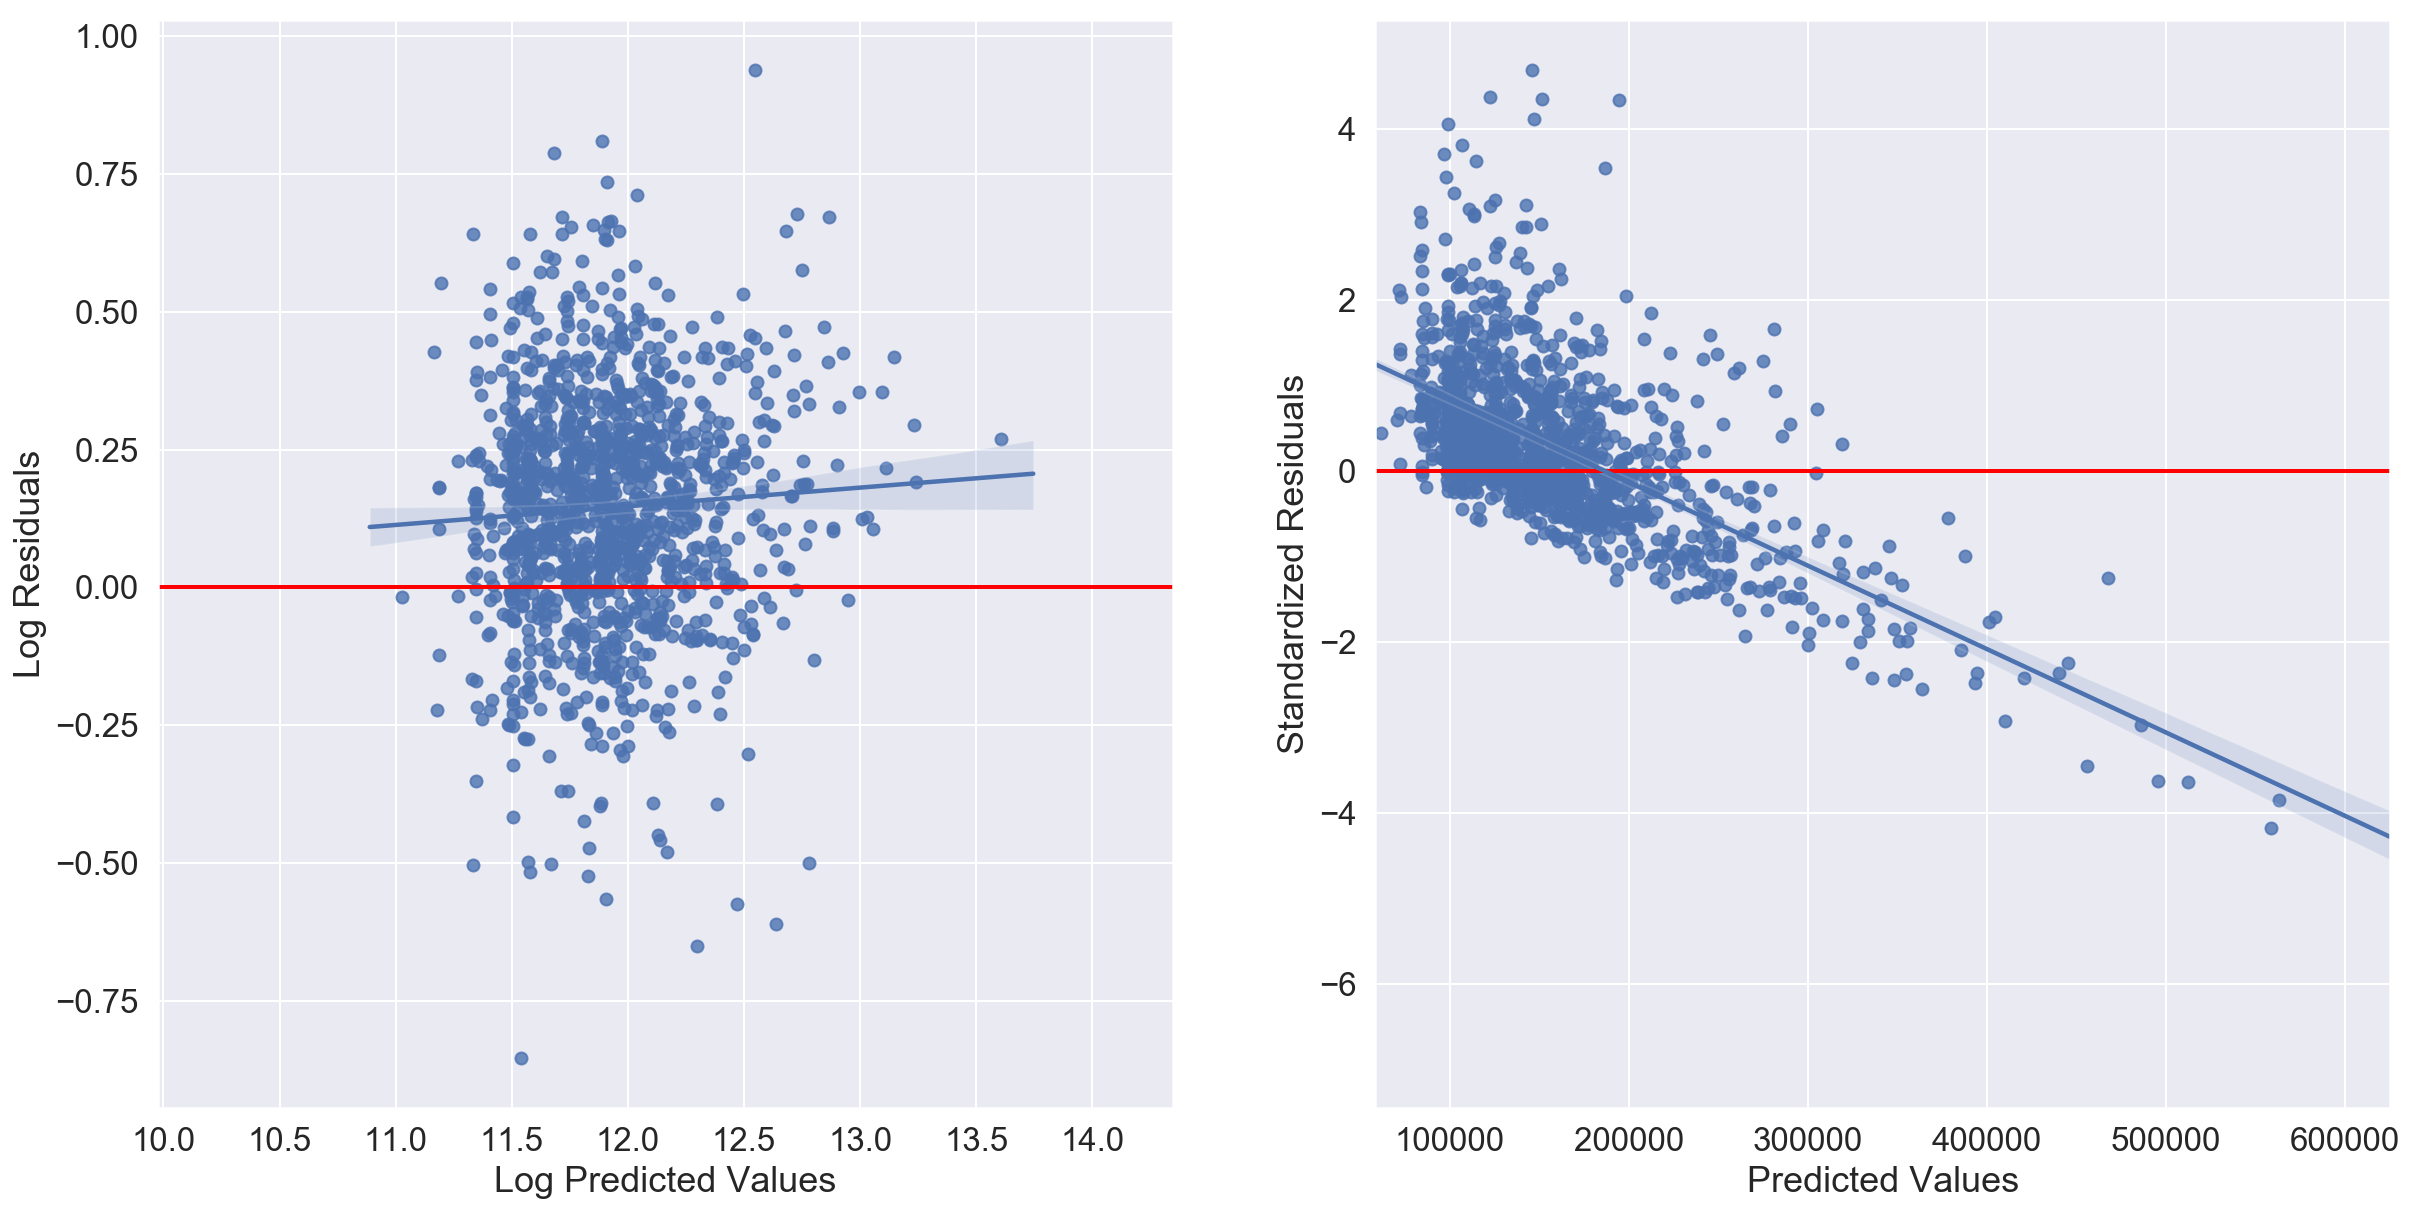

In [191]:
resilduals_lasso = resilduals_plots(optimal_lasso, X, y, log=True)

In [192]:
resilduals_lasso.head()

Predict  Residual      Predicted  StdResidual  IDX
0  12.022505  0.225189  166458.184848     0.422894    0
1  12.020801  0.088210  166174.649502     0.154149    1
2  12.073207  0.243960  175115.463739     0.486696    2
3  11.876038 -0.026640  143778.754913    -0.038021    3
4  12.501354 -0.072138  268699.945078    -0.188115    4

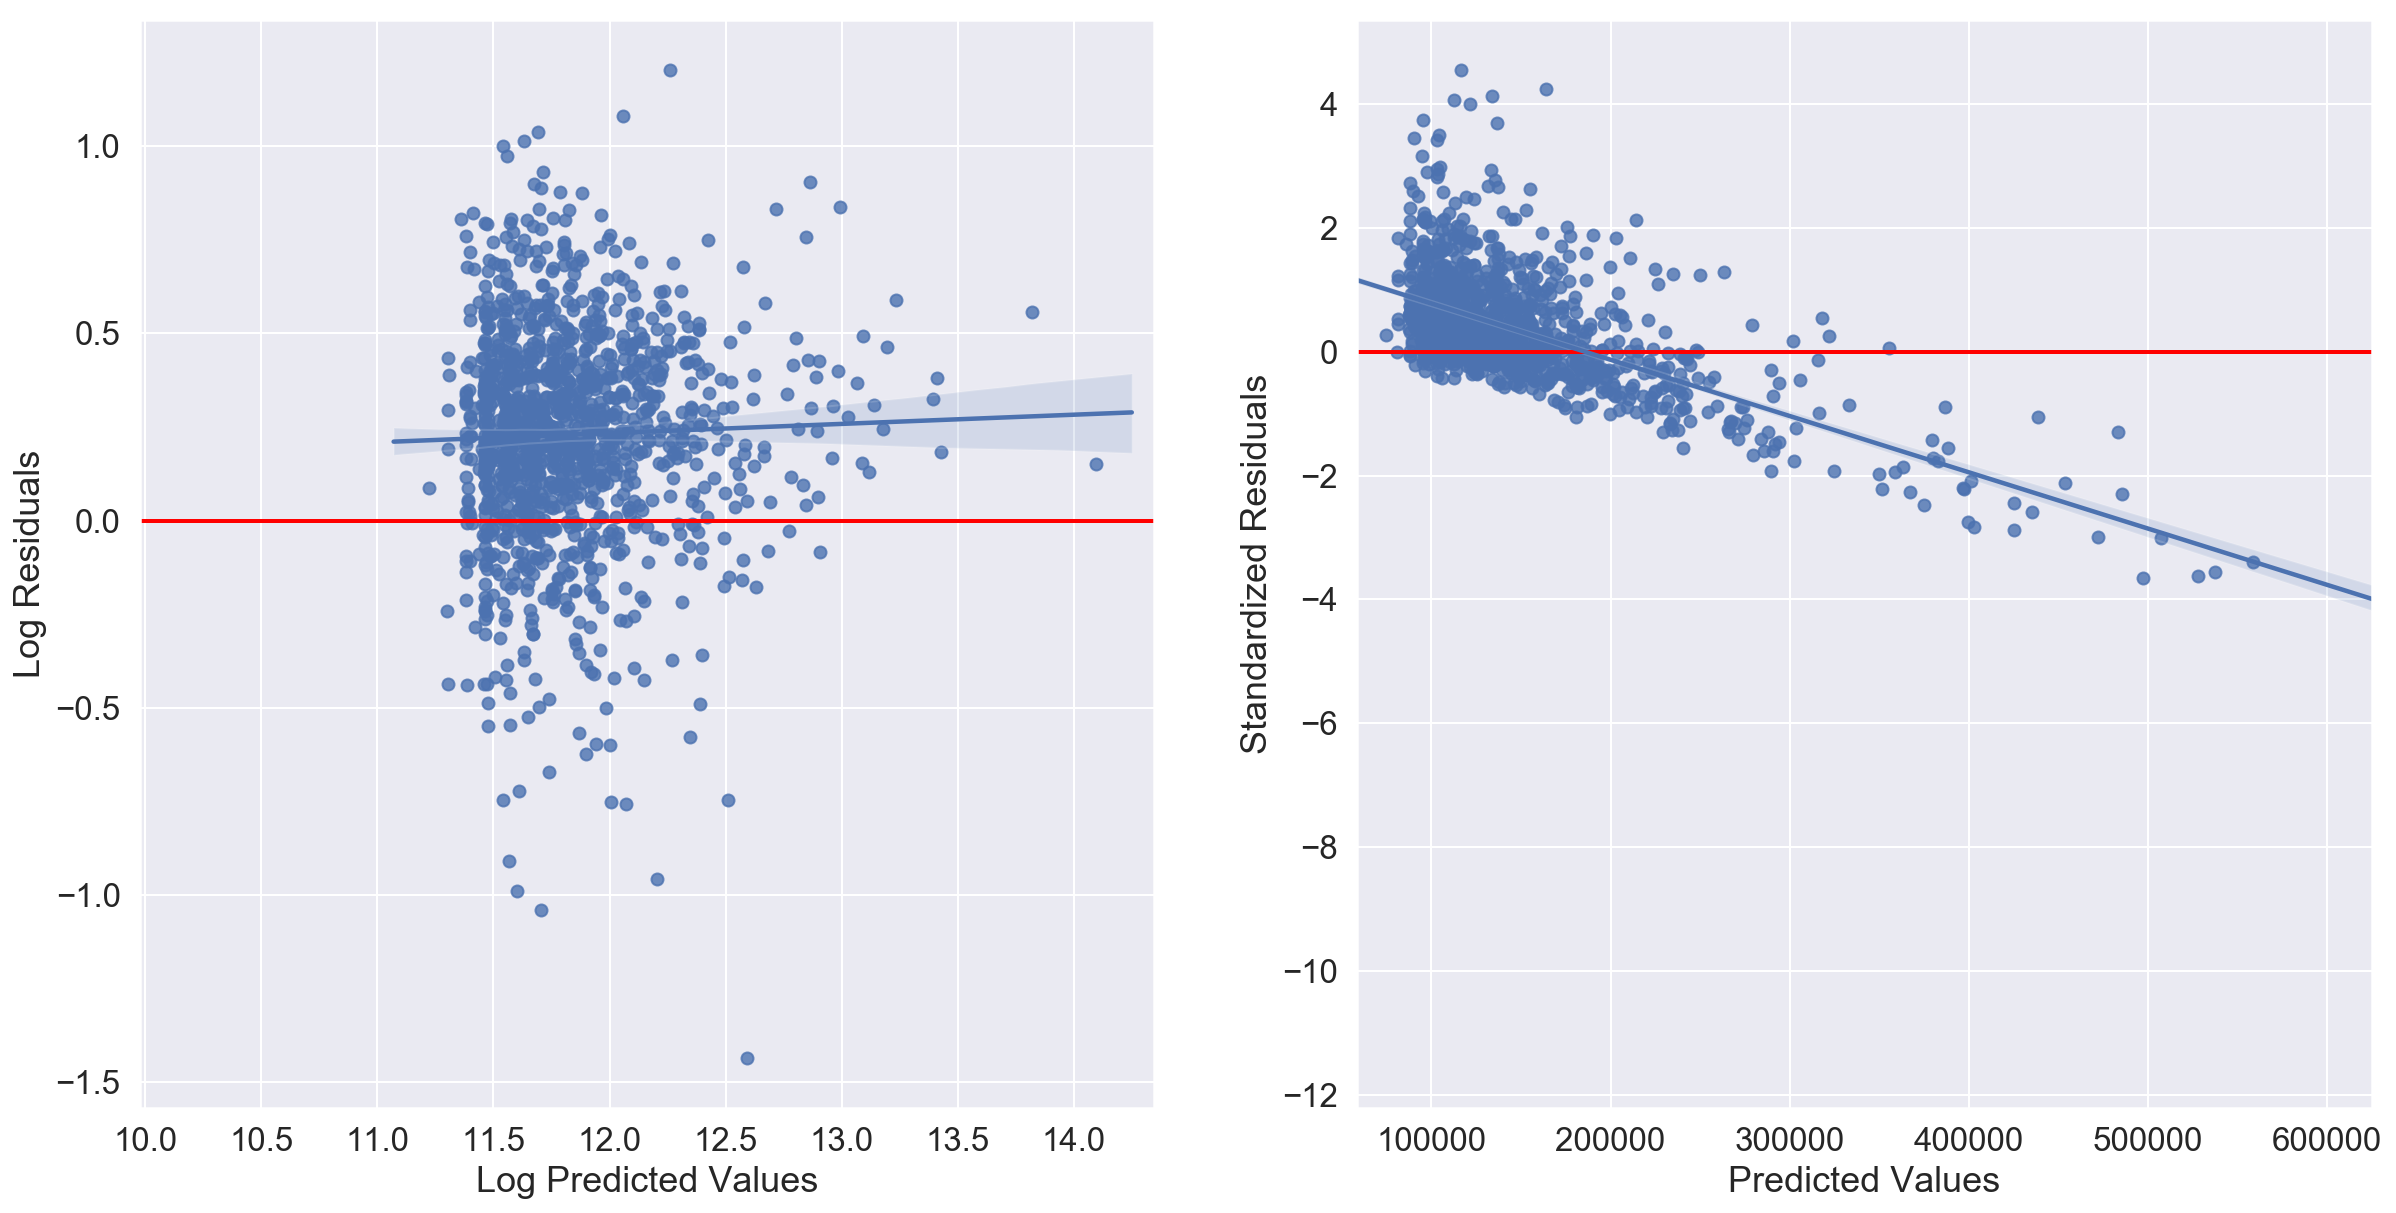

In [193]:
resilduals_ridge = resilduals_plots(optimal_ridge, X, y, log=True)

In [194]:
resilduals_ridge.head()

Predict  Residual      Predicted  StdResidual  IDX
0  11.953207  0.294488  155313.367797     0.489099    0
1  11.802641  0.306370  133603.701647     0.440449    1
2  11.904611  0.412556  147946.177436     0.694790    2
3  11.656651  0.192747  115455.681753     0.225702    3
4  12.419545  0.009671  247592.906710     0.022127    4

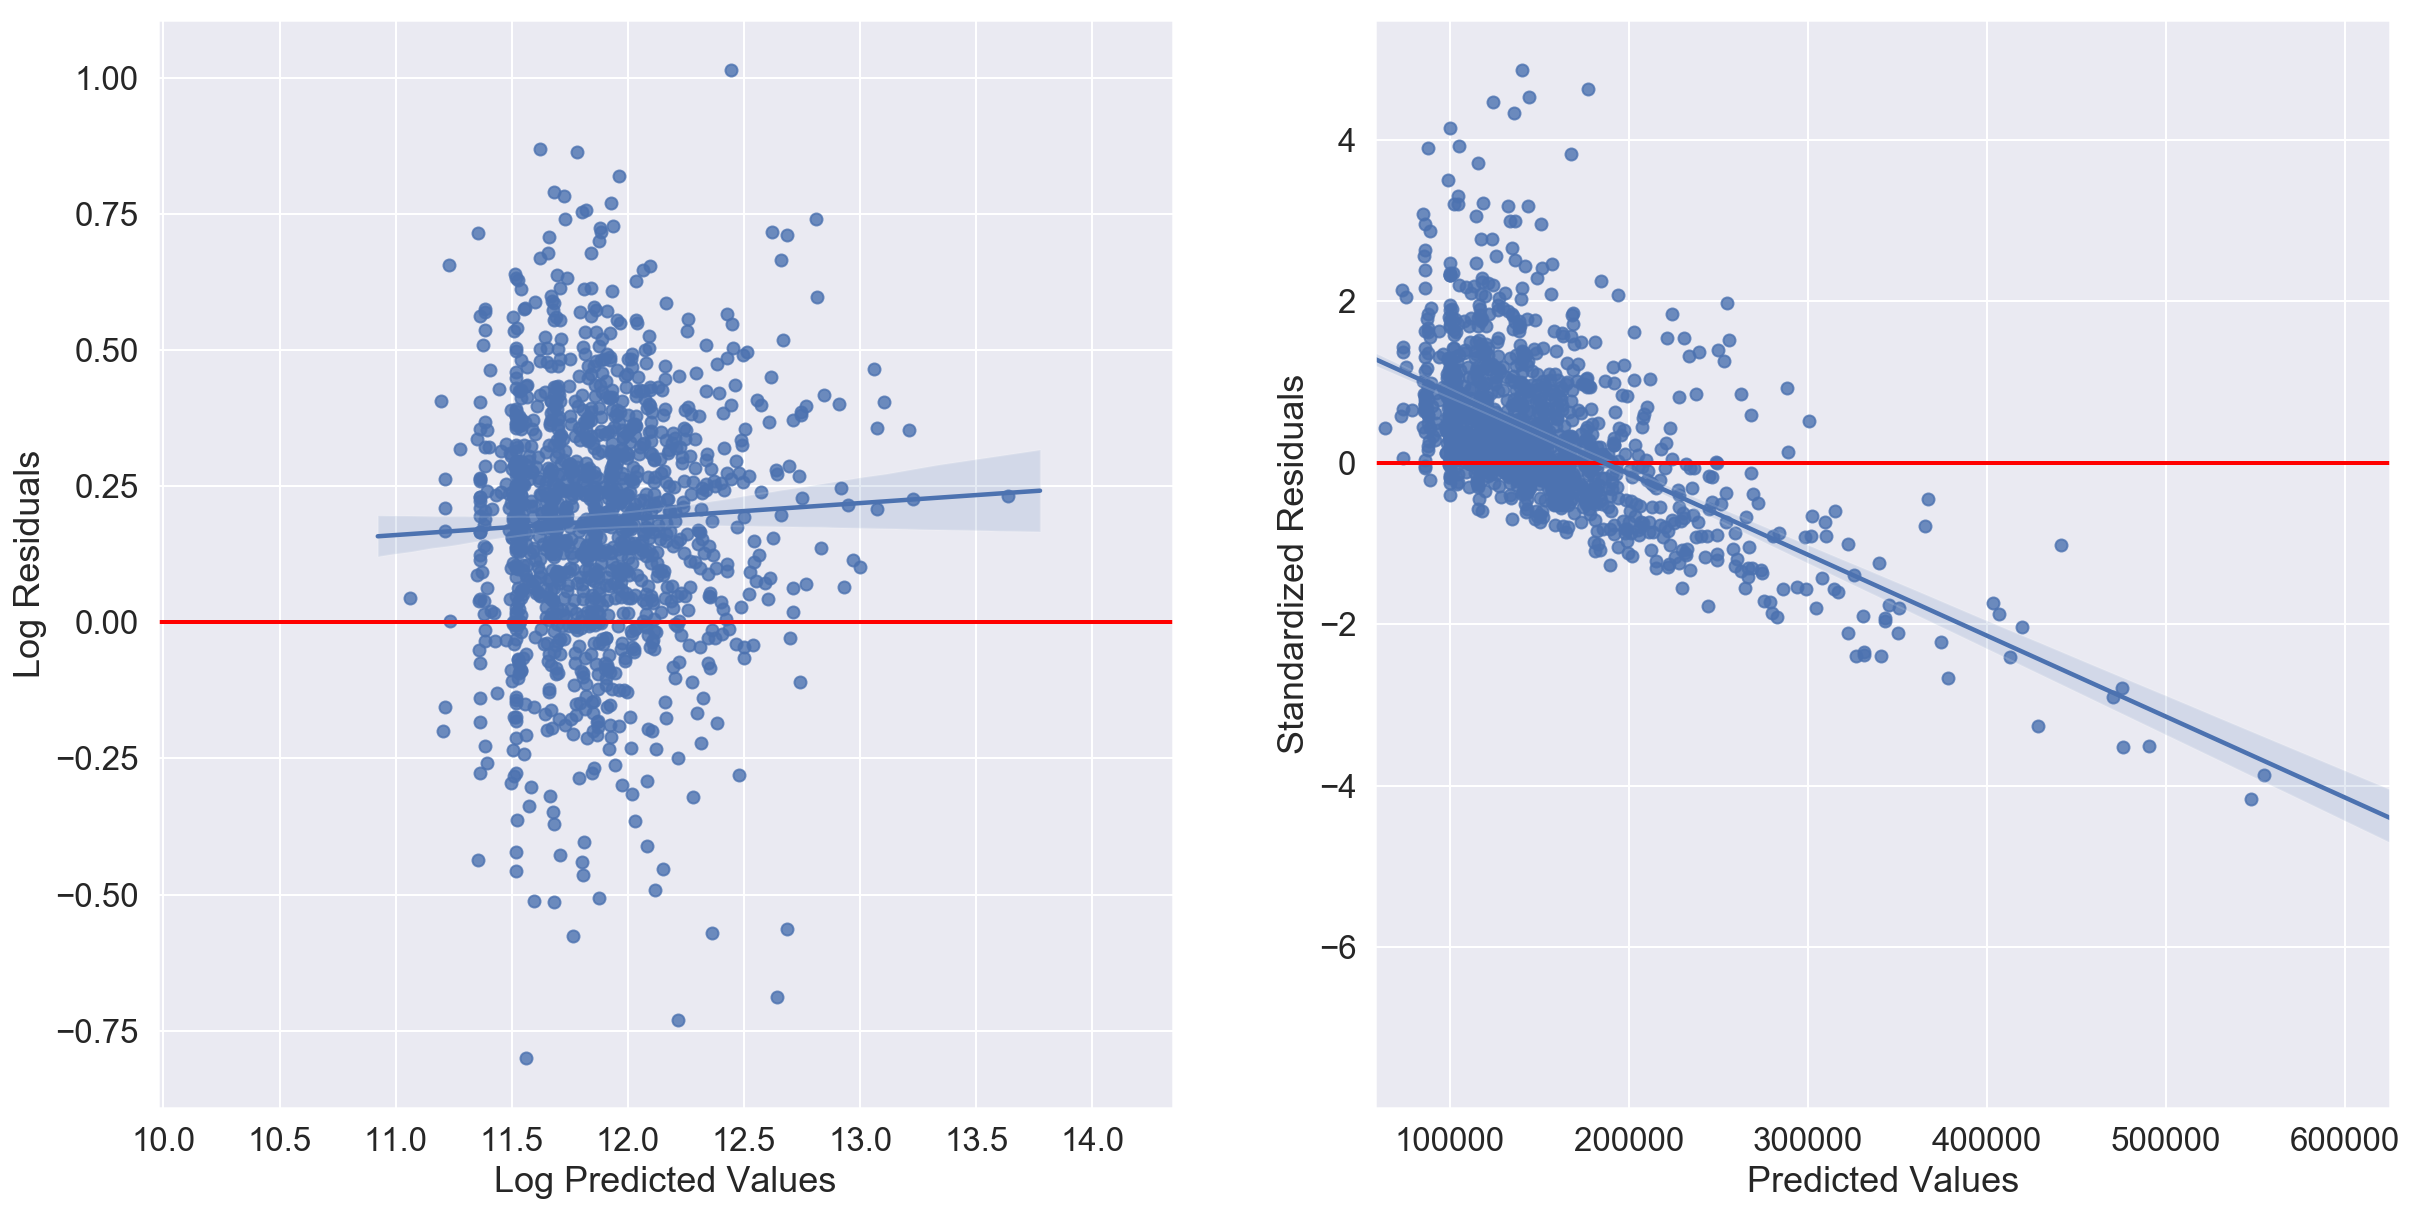

In [195]:
resilduals_enet = resilduals_plots(optimal_enet, X, y, log=True)

In [196]:
resilduals_enet.head()

Predict  Residual      Predicted  StdResidual  IDX
0  12.007830  0.239864  164033.188164     0.459426    0
1  11.907368  0.201643  148354.735876     0.342451    1
2  11.976991  0.340175  159051.752645     0.665877    2
3  11.807396  0.042002  134240.529679     0.059497    3
4  12.423683  0.005533  248619.584501     0.014252    4

<a id='qn2_4'></a>
## Section 2.4

Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

- [Back to top](#top)
- [Section 2.1](#qn2_1)
- [Section 2.2](#qn2_2)
- [Section 2.3](#qn2_3)
- [Section 2.4](#qn2_4)

In [197]:
df_train = reno_df.sample(1000).copy()
df_test = reno_df[~reno_df.index.isin(df_train.index)].copy()

In [198]:
reno_df.shape, df_train.shape, df_test.shape

((1445, 6), (1000, 6), (445, 6))

In [199]:
X_test = df_test[['Enet', 'Lasso', 'Ridge', 'Ypred']]
y_test = df_test['Actual']

X_train = df_train[['Enet', 'Lasso', 'Ridge', 'Ypred']]
y_train = df_train['Actual']

In [200]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)

In [201]:
r2_score(y_test,y_test_pred)

0.699308971904572

In [202]:
mean_squared_error(y_test,y_test_pred)

0.04325624728157441

<a id='qn3'></a>
<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.


<a id='qn3_1'></a>
## Section 3.1

Determine which features predict the Abnorml category in the SaleCondition feature.

- [Back to top](#top)
- [Section 3.1](#qn3_1)
- [Section 3.2](#qn3_2)
- [Section 3.3](#qn3_3)

<a id='qn3a'></a>
## Analyzing the data
[Back to top](#top)

In [203]:
tgt = 'SaleCondition_Abnorml'
abnormal_cnt = list(house.groupby(tgt)[tgt].sum())[1]
total_cnt = list(house.shape)[0]
abn_ratio = int(abnormal_cnt*10000/total_cnt)/100

print(f"Total = {total_cnt} Abnormal sales cond = {abnormal_cnt}")
print(f"Ratio of abnormal home sales is: {abn_ratio}%")
print("\nAscii Chart:")
print('[' + '#'*4 + '_'*57 + ']')
print("# is 'Abnormal sales'\t\t _ is 'normal sales'")

Total = 1445 Abnormal sales cond = 95
Ratio of abnormal home sales is: 6.57%

Ascii Chart:
[####_________________________________________________________]
# is 'Abnormal sales'		 _ is 'normal sales'


<a id='qn3b'></a>
## Data Modelling - Random Forest
[Back to top](#top)

In [204]:
X = house._get_numeric_data().drop(tgt, axis=1)
y = house[tgt]
X.shape, y.shape, house.shape

((1445, 302), (1445,), (1445, 303))

In [205]:
# For the train test split we stratify on y to
# ensure that the distribution of classes is the same
# in both the test set & the training set.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.5, 
                                                    random_state = 77,
                                                    stratify = y)

In [206]:
# confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

base_preds = np.full(len(y_test), 0)
baseline_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, base_preds)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
baseline_confusion

predicted_not_abnormal  predicted_abnormal
is_not_abnormal                     675                   0
is_abnormal                          48                   0

In [207]:
# baseline accurarcy
base_acc = (960 + 0) / (960 + 0 + 66 + 0)
base_acc

0.935672514619883

In [208]:
# sensitivity == recall

base_recall = (0) / (0 + 66)
base_recall

0.0

In [209]:
# Applying Random Forest Model 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

rfc = RandomForestClassifier(random_state=620)

rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_recall = recall_score(y_test, rfc_predict)

print ("Random Forest Test Score:", rfc_recall)
rfc_sum = rfc_predict.sum()
train_cnt = len(rfc_predict)
abn_ratio = int(rfc_sum*10000/train_cnt)/100
print( f"Predicted {rfc_sum} abnormal cases out of {train_cnt}" )
print(f"Ratio of abnormal home sales is: {abn_ratio}%")
print("\nAscii Chart:")
print('[#' + '_'*60 + ']')
print("# is 'Abnormal sales'\t\t _ is 'normal sales'")

Random Forest Test Score: 0.08333333333333333
Predicted 6 abnormal cases out of 723
Ratio of abnormal home sales is: 0.82%

Ascii Chart:
[#____________________________________________________________]
# is 'Abnormal sales'		 _ is 'normal sales'


In [210]:
# Model Evaluation
rfc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, rfc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
rfc_confusion

predicted_not_abnormal  predicted_abnormal
is_not_abnormal                     673                   2
is_abnormal                          44                   4

In [211]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       675
           1       0.67      0.08      0.15        48

   micro avg       0.94      0.94      0.94       723
   macro avg       0.80      0.54      0.56       723
weighted avg       0.92      0.94      0.91       723



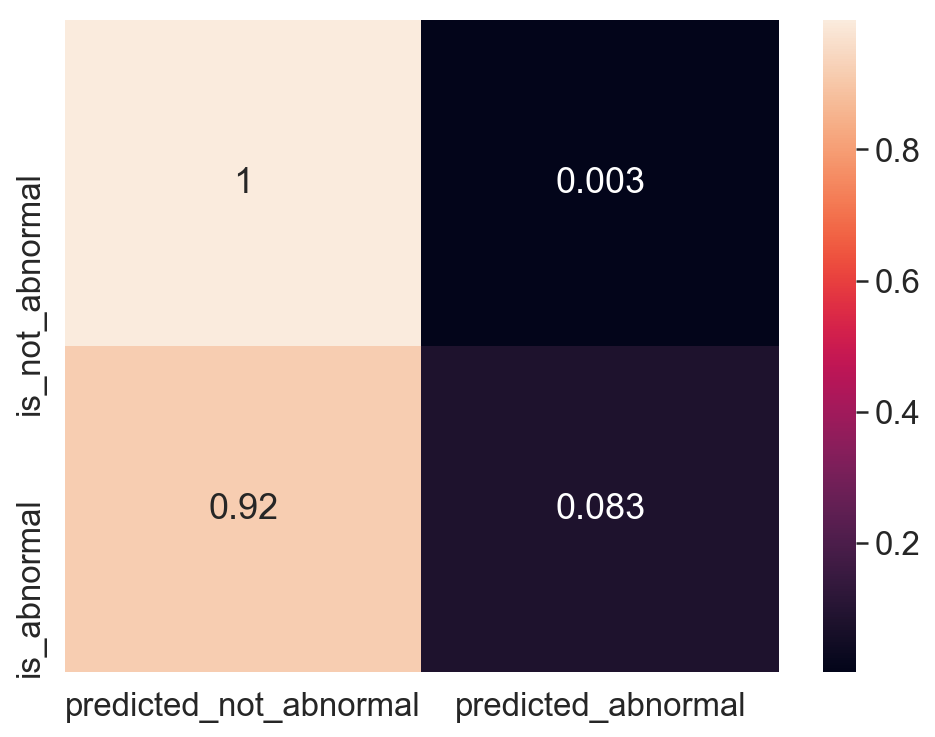

In [212]:
sns.heatmap(rfc_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True)

<a id='qn3c'></a>
## Conclusion
[Back to top](#top)

In [213]:
list_cols = list(house.columns)
features_cols = []
features_coefs = []
print("these are the features contributing to abnormal sales:")    
for x in  [ x for x,v in enumerate(rfc.feature_importances_) if (v>=0.02) and (list_cols[x][:13]!='SaleCondition')]:
    col = list_cols[x]
    coef = rfc.feature_importances_[x]
    features_cols.append(col)
    features_coefs.append(coef)
    col = (col + "           ")[:15]
    print(f"{col}\t\t\t{coef}")
    
list_df(features_cols,4)

these are the features contributing to abnormal sales:
YearBuilt      			0.04294747063044883
MasonryArea    			0.02235431138262773
BasementArea1  			0.024993948001544426
BasementUnfinis			0.03111013843066842
FirstFloor     			0.025137755222526613
SalePrice      			0.046905654438691824
Yrs_Sold       			0.0207338575128932


0            1              2                   3
0   YearBuilt  MasonryArea  BasementArea1  BasementUnfinished
1  FirstFloor    SalePrice       Yrs_Sold

<a id='qn3_2'></a>
## Section 3.2

Justify the results using undersampling techniques

- [Back to top](#top)
- [Section 3.1](#qn3_1)
- [Section 3.2](#qn3_2)
- [Section 3.3](#qn3_3)

In [214]:
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, TomekLinks

smomek = SMOTETomek(random_state = 61451,
                    smote = SMOTE(k_neighbors = 35, random_state=625),
                    tomek = TomekLinks(ratio='majority', random_state=936))

X_smomek, y_smomek = smomek.fit_sample(X_train, y_train)

In [215]:
rfc.fit(X_smomek,y_smomek)
smomek_predict = rfc.predict(X_test)
smomek_recall = recall_score(y_test, smomek_predict)

print ("SMOTETomek Test Score:", smomek_recall)

SMOTETomek Test Score: 0.10416666666666667


In [216]:
smomek_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, smomek_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
smomek_confusion

predicted_not_abnormal  predicted_abnormal
is_not_abnormal                     673                   2
is_abnormal                          43                   5

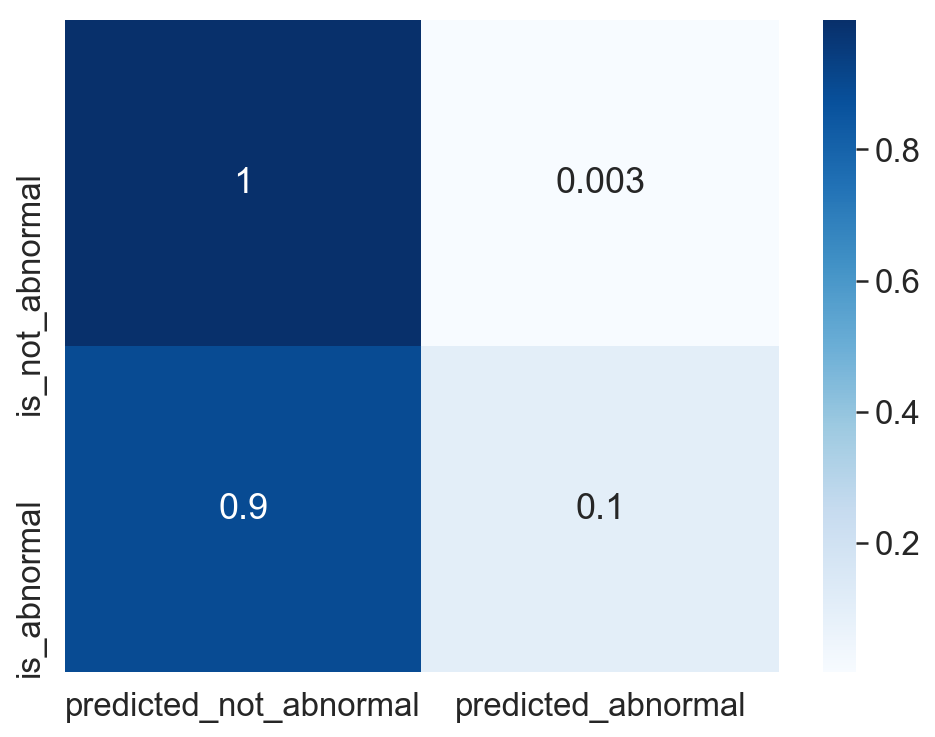

In [217]:
sns.heatmap(smomek_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

In [218]:
df = pd.DataFrame({'Random Forest':[rfc_recall],'SMote Tomek':[smomek_recall] })
df.name = "Comparison"
df.index = ['Score']
df

Random Forest  SMote Tomek
Score       0.083333     0.104167

<a id='qn3_3'></a>
## Section 3.3

Other Finding

- [Back to top](#top)
- [Section 3.1](#qn3_1)
- [Section 3.2](#qn3_2)
- [Section 3.3](#qn3_3)

In [219]:
from scipy.stats import chi2_contingency

def hypothese_test(df, var1, var2):
    df2 = pd.crosstab(df[var1] , df[var2])
    chi2, p, dof, ex = chi2_contingency(df2)
    return p

print("There is a relationship between :\n")
level_signif = 0.05

list_cols = house.columns
for col in features_cols:
    if col == tgt:
        continue
    pv = hypothese_test(house, col, tgt)
    if pv <= level_signif:
        print(f"{col} and {tgt}, P = {pv}")    

There is a relationship between :



[Goto bookmarks](#top)